# Reproducing Figure 4 Brown et al. 2015

In [ ]:
import agama
import numpy as np
from astropy.coordinates import SkyCoord, Galactocentric
from astropy import units as u
from tqdm import tqdm
import os
import sys
import pandas as pd
from astropy.table import Table

# set current directory to /app/data so we can work with relative paths
os.chdir('/app/data/')

# Add the path to the 'scripts' folder directly
sys.path.append('/app/data/')

from scripts import orbit_integration_agama as oia


In [2]:
import agama
agama.setUnits(mass=1, length=1, velocity=1)

# Loading the catalog of HVS candidates

This catalog contains both Gaia measurements and their HST based proper motion and radial velocity measurements

In [3]:

# Load the star data
brown_data = pd.read_csv('Data/Brown_targets/brown_stars_gaia.csv')

# Load the same potential used in Brown et al. 2015

This potential is composed of 3 components, a Plummer sphere of $3.76 \times 10^9 M_{\odot}$ for the Bulge, a MiyamotoNagai disk with a scale radius of $2.75$ kpc, scale height of $0.3$ and a mass of $6 \times 10^{10} M_{\odot}$, the halo is modeled as a NFW potential with a scale radius of 20 kpc and a mass of $10^{11} M_{\odot}$

In [4]:
potential = agama.Potential(file='Agama/brown2015.pot')  # Adjust file path if needed


# Compute plane crossing positions for all Brown stars using their HST measurements

In [5]:
# compute orbits for all brown stars using HST proper motions, this should give the exact same contours as Figure 4 in the paper
plane_crossings = []
for i in range(len(brown_data)):
    star = brown_data.iloc[[i]]
    plane_crossings.append(oia.integrate_orbits_to_plane_crossing_agama_parallel(star, n_samples=10000,
                                                        integration_time=-0.5,  
                                                        pmra_col='mu_ra',
                                                        pmdec_col='mu_dec',
                                                        pmra_error_col='mu_ra_error',
                                                        pmdec_error_col='mu_dec_error', 
                                                        potential_file='Agama/brown2015.pot'))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1200.00it/s]


## Plot the density level thresholds that contain 68.26 and 95.44% of all the crossings within them.

In [4]:
# plotting function
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def scatter_plot_origin(origins, xlim=(-60, 60), ylim=(-60, 60),
  bw_method='scott', save = False, star_name='star',
  save_path = 'Plots/brown_stars/scatterplots/brown_potential'
  ):
  """
    Plot the 1σ and 2σ contours of closest approach points in the X-Y plane.

    Parameters:
    - origins: list of tuples
      List of positions (X, Y, Z) at the closest approach for each sample.
    - xlim: tuple
      Limits for the X-axis (default: (-60, 60)).
    - ylim: tuple
      Limits for the Y-axis (default: (-60, 60)).
  """
  # Extract X, Y positions from origins
  x = np.array([origin[0] for origin in origins])
  y = np.array([origin[1] for origin in origins])

  plt.figure(figsize=(10, 10))
  
  plt.scatter(x, y, s=1)

  plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Galactic Center

  # Add solar circles
  circle1 = plt.Circle((0, 0), 8.21, color='r', fill=False, lw=2, label='8.21 kpc')
  circle2 = plt.Circle((0, 0), 20, color='g', fill=False, linestyle='--', label='20 kpc')
  plt.gca().add_artist(circle1)
  plt.gca().add_artist(circle2)

  # Customize plot
  plt.xlabel('X [kpc]')
  plt.ylabel('Y [kpc]')
  plt.xlim(xlim)
  plt.ylim(ylim)
  plt.title(f'1σ and 2σ Contours of Closest Approach Points in X-Y Plane')
  plt.legend(loc='upper right')
  plt.grid(True)

    #plt.show()
  if save:
    if not os.path.exists(save_path):
      os.makedirs(save_path)
    plt.savefig(os.path.join(save_path, star_name+'.png'))


def plot_sigma_contours(origins, xlim=(-60, 60), ylim=(-60, 60), bw_method='scott', save = False, star_name='star', save_path = 'Plots/brown_stars/brown_potential'):
    """
    Plot the 1σ and 2σ contours of closest approach points in the X-Y plane.

    Parameters:
    - origins: list of tuples
      List of positions (X, Y, Z) at the closest approach for each sample.
    - xlim: tuple
      Limits for the X-axis (default: (-60, 60)).
    - ylim: tuple
      Limits for the Y-axis (default: (-60, 60)).
    """
    # Extract X, Y positions from origins
    x = np.array([origin[0] for origin in origins])
    y = np.array([origin[1] for origin in origins])

    # Create a 2D KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method=bw_method)
    xi, yi = np.linspace(xlim[0], xlim[1], 300), np.linspace(ylim[0], ylim[1], 300)
    xi, yi = np.meshgrid(xi, yi)
    zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    
    # Normalize the KDE to get cumulative probabilities
    zi_flat = zi.flatten()
    sorted_zi = np.sort(zi_flat)
    cumsum_zi = np.cumsum(sorted_zi) / np.sum(sorted_zi)

    # Determine contour levels for 1σ (68.26%) and 2σ (95.44%)
    level_1sigma = sorted_zi[np.searchsorted(cumsum_zi, 1 - 0.6826)]
    level_2sigma = sorted_zi[np.searchsorted(cumsum_zi, 1- 0.9544)]
        

    # Find mode of the distribution
    mode_index = np.argmax(zi_flat)
    mode_x, mode_y = xi.flatten()[mode_index], yi.flatten()[mode_index]

    # Plot the KDE with contour levels
    plt.figure(figsize=(10, 10))
    #plt.contourf(xi, yi, zi, levels=100, cmap="Blues")
    #plt.colorbar(label="Density")
    # check if the levels are increasing

    try:
      plt.contour(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()], colors=['k', 'k', 'k'], 
                  linewidths=[2, 2, 2], linestyles=['--', '-','-'], labels=['1σ', '2σ', '0'])
      plt.contourf(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()], colors=['cyan', 'magenta', 'blue'], alpha=0.5)
    
    except ValueError:
      print('ValueError')
      print(level_2sigma, level_1sigma, zi.max())
      scatter_plot_origin(origins, xlim, ylim, save, star_name, save_path)
      return


    # Add annotations
    plt.scatter(mode_x, mode_y, color='black', label='Mode of Distribution', s=100, marker='x')
    plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Galactic Center

    # Add solar circles
    circle1 = plt.Circle((0, 0), 8.21, color='r', fill=False, lw=2, label='8.21 kpc')
    circle2 = plt.Circle((0, 0), 20, color='g', fill=False, linestyle='--', label='20 kpc')
    plt.gca().add_artist(circle1)
    plt.gca().add_artist(circle2)

    # Customize plot
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title('1σ and 2σ Contours of Closest Approach Points in X-Y Plane')
    plt.legend(loc='upper right')
    plt.grid(True)
    #plt.show()
    if save:
      os.makedirs(save_path, exist_ok=True)
      plt.savefig(os.path.join(save_path, star_name+'.png'))
    plt.show()


def plot_sigma_contours_m(origins, xlim=(-60, 60), ylim=(-60, 60), bw_method='scott',
 save = False, star_name='star', save_path = 'Plots/brown_stars/brown_potential'):
    """
    Plot the 1σ and 2σ contours of closest approach points in the X-Y plane.

    Parameters:
    - origins: list of tuples
      List of positions (X, Y, Z) at the closest approach for each sample.
    - xlim: tuple
      Limits for the X-axis (default: (-60, 60)).
    - ylim: tuple
      Limits for the Y-axis (default: (-60, 60)).
    """
    # Extract X, Y positions from origins
    x = np.array([origin[0] for origin in origins])
    y = np.array([origin[1] for origin in origins])

    # Create a 2D KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method=bw_method)
    xi, yi = np.linspace(xlim[0], xlim[1], 300), np.linspace(ylim[0], ylim[1], 300)
    xi, yi = np.meshgrid(xi, yi)
    zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    
    # Normalize the KDE to get cumulative probabilities
    zi_flat = zi.flatten()
    sorted_zi = np.sort(zi_flat)
    cumsum_zi = np.cumsum(sorted_zi) / np.sum(sorted_zi)

    # Determine contour levels for 1σ (68.26%) and 2σ (95.44%)
    level_1sigma = sorted_zi[np.searchsorted(cumsum_zi, 1 - 0.6826)]
    level_2sigma = sorted_zi[np.searchsorted(cumsum_zi, 1- 0.9544)]

    # Find mode of the distribution
    mode_index = np.argmax(zi_flat)
    mode_x, mode_y = xi.flatten()[mode_index], yi.flatten()[mode_index]

    # Plot the KDE with contour levels
    plt.figure(figsize=(10, 8))
    plt.contourf(xi, yi, zi, levels=100, cmap="Blues")
    plt.colorbar(label="Density")

    plt.contour(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()], colors=['red', 'darkorange', 'k'], 
                linewidths=[2, 2, 2], linestyles=['--', '-','-'])
    #plt.contourf(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()], colors=['cyan', 'magenta', 'blue'], alpha=0.5)
    
    # Add annotations
    plt.scatter(mode_x, mode_y, color='black', label='Mode of Distribution', s=100, marker='x')
    plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Galactic Center

    # Add solar circles
    circle1 = plt.Circle((0, 0), 8.21, color='r', fill=False, lw=2, label='8.21 kpc')
    circle2 = plt.Circle((0, 0), 20, color='g', fill=False, linestyle='--', label='20 kpc')
    plt.gca().add_artist(circle1)
    plt.gca().add_artist(circle2)

    # Customize plot
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(f'1σ and 2σ Contours of Closest Approach Points in X-Y Plane \n Probability of GC origin {prob_00:.2e}')
    plt.legend(loc='upper right')
    plt.grid(True)
    #plt.show()
    if save:
      if not os.path.exists(save_path):
        os.makedirs(save_path)
      plt.savefig(os.path.join(save_path, star_name+'.png'))




In [5]:
# testing other plotting function
def scatter_plot_origin(origins, xlim=(-60, 60), ylim=(-60, 60),
                        save=False, star_name='star',
                        save_path='Plots/brown_stars/scatterplots/brown_potential'):
    """
    Fallback: Scatter plot of X-Y positions of the closest approach.

    Parameters:
    - origins: list of tuples
      List of positions (X, Y, Z) at the closest approach for each sample.
    - xlim: tuple
      Limits for the X-axis (default: (-60, 60)).
    - ylim: tuple
      Limits for the Y-axis (default: (-60, 60)).
    """
    # Extract X, Y positions from origins
    x = np.array([origin[0] for origin in origins])
    y = np.array([origin[1] for origin in origins])

    plt.figure(figsize=(10, 10))
    plt.scatter(x, y, s=1, label='Samples')

    plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Galactic Center

    # Add solar circles
    circle1 = plt.Circle((0, 0), 8.21, color='r', fill=False, lw=2, label='8.21 kpc')
    circle2 = plt.Circle((0, 0), 20, color='g', fill=False, linestyle='--', label='20 kpc')
    plt.gca().add_artist(circle1)
    plt.gca().add_artist(circle2)

    # Customize plot
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title('Scatter Plot of Closest Approach Points in X-Y Plane')
    plt.legend(loc='upper right')
    plt.grid(True)

    if save:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, f"{star_name}.png"))

    plt.show()


def plot_sigma_contours(origins, xlim=(-60, 60), ylim=(-60, 60),
                        bw_method='scott', save=False, star_name='star',
                        save_path='Plots/brown_stars/brown_potential'):
    """
    Plot the 1σ and 2σ contours or fallback to scatter plot if KDE fails.

    Parameters:
    - origins: list of tuples
      List of positions (X, Y, Z) at the closest approach for each sample.
    - xlim: tuple
      Limits for the X-axis (default: (-60, 60)).
    - ylim: tuple
      Limits for the Y-axis (default: (-60, 60)).
    """
    # Extract X, Y positions from origins
    x = np.array([origin[0] for origin in origins])
    y = np.array([origin[1] for origin in origins])

    # Create a 2D KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method=bw_method)

    xi, yi = np.linspace(xlim[0], xlim[1], 300), np.linspace(ylim[0], ylim[1], 300)
    xi, yi = np.meshgrid(xi, yi)
    zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)

    try:
        # Normalize the KDE to get cumulative probabilities
        zi_flat = zi.flatten()
        sorted_zi = np.sort(zi_flat)
        cumsum_zi = np.cumsum(sorted_zi) / np.sum(sorted_zi)

        # Determine contour levels for 1σ (68.26%) and 2σ (95.44%)
        level_1sigma = sorted_zi[np.searchsorted(cumsum_zi, 1 - 0.6826)]
        level_2sigma = sorted_zi[np.searchsorted(cumsum_zi, 1 - 0.9544)]

        # Find mode of the distribution
        mode_index = np.argmax(zi_flat)
        mode_x, mode_y = xi.flatten()[mode_index], yi.flatten()[mode_index]

        # Plot the KDE with contour levels
        plt.figure(figsize=(10, 10))
        plt.contour(xi, yi, zi, levels=[level_2sigma, level_1sigma], colors=['k', 'k'], 
                    linewidths=[2, 2], linestyles=['--', '-'])
        plt.contourf(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()],
                     colors=['cyan', 'magenta', 'blue'], alpha=0.5)

        # Add annotations
        plt.scatter(mode_x, mode_y, color='black', label='Mode of Distribution', s=100, marker='x')
        plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Galactic Center

        # Add solar circles
        circle1 = plt.Circle((0, 0), 8.21, color='r', fill=False, lw=2, label='8.21 kpc')
        circle2 = plt.Circle((0, 0), 20, color='g', fill=False, linestyle='--', label='20 kpc')
        plt.gca().add_artist(circle1)
        plt.gca().add_artist(circle2)

        # Customize plot
        plt.xlabel('X [kpc]')
        plt.ylabel('Y [kpc]')
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.title('1σ and 2σ Contours of Closest Approach Points in X-Y Plane')
        plt.legend(loc='upper right')
        plt.grid(True)

        if save:
            os.makedirs(save_path, exist_ok=True)
            plt.savefig(os.path.join(save_path, f"{star_name}.png"))

        plt.show()

    except ValueError as e:
        print(f"ValueError during contour plotting: {e}")
        scatter_plot_origin(origins, xlim, ylim, save, star_name, save_path)


In [39]:
# remove NoneType tuples from plane_crossings
#plane_crossings = [x for x in plane_crossings if x is not None]

/app/data/scripts/orbit_integration_agama.py:83: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()], colors=['k', 'k', 'k'],


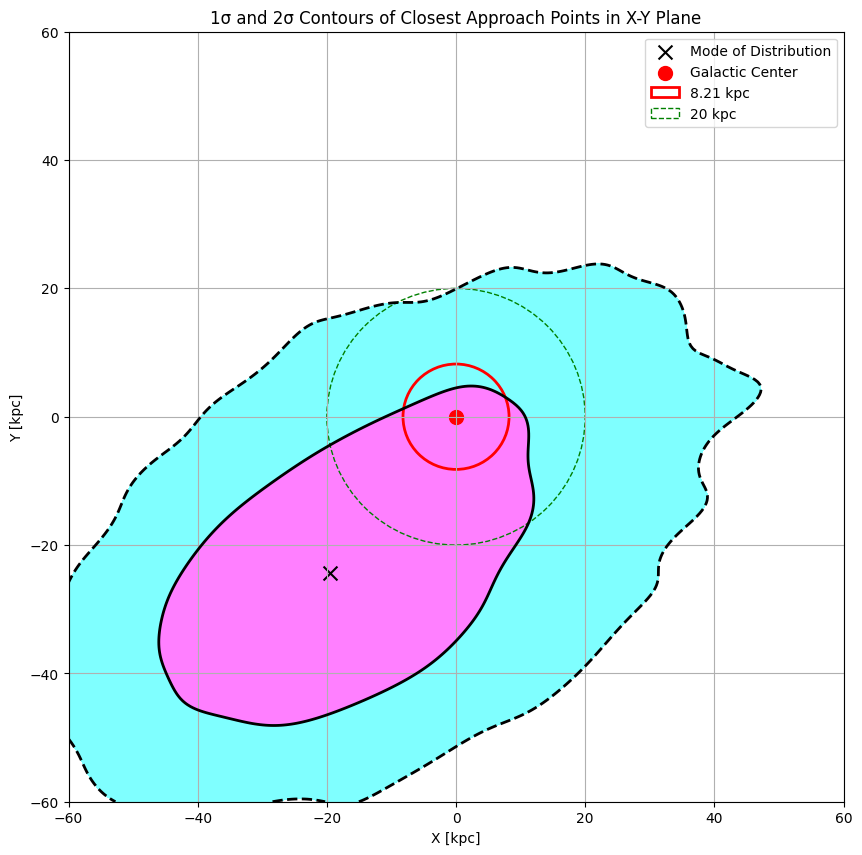

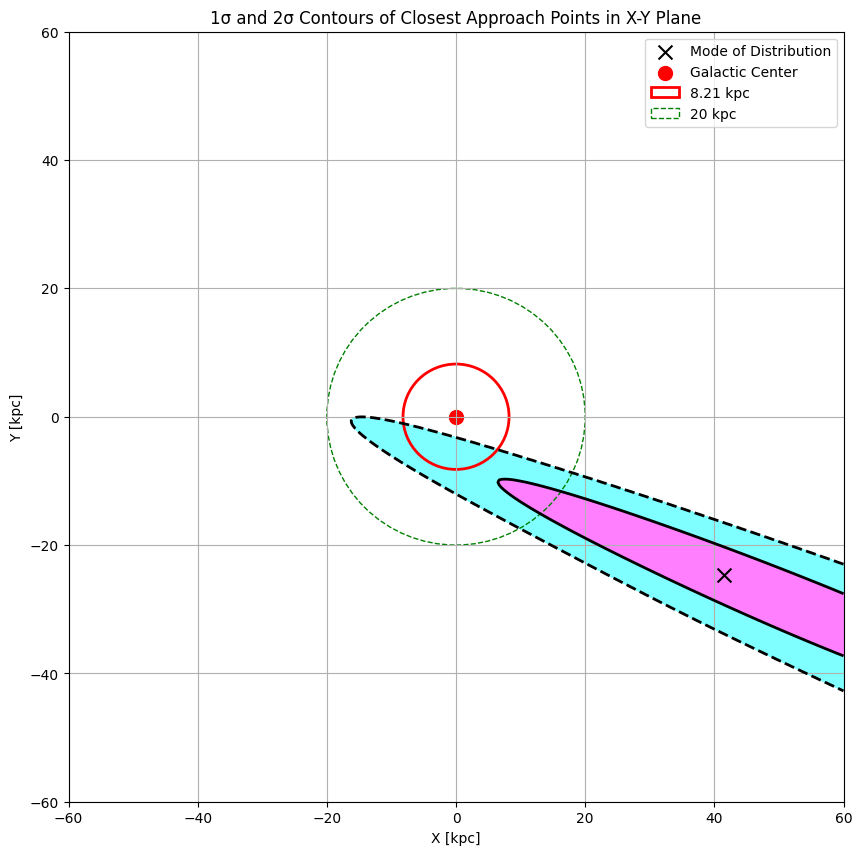

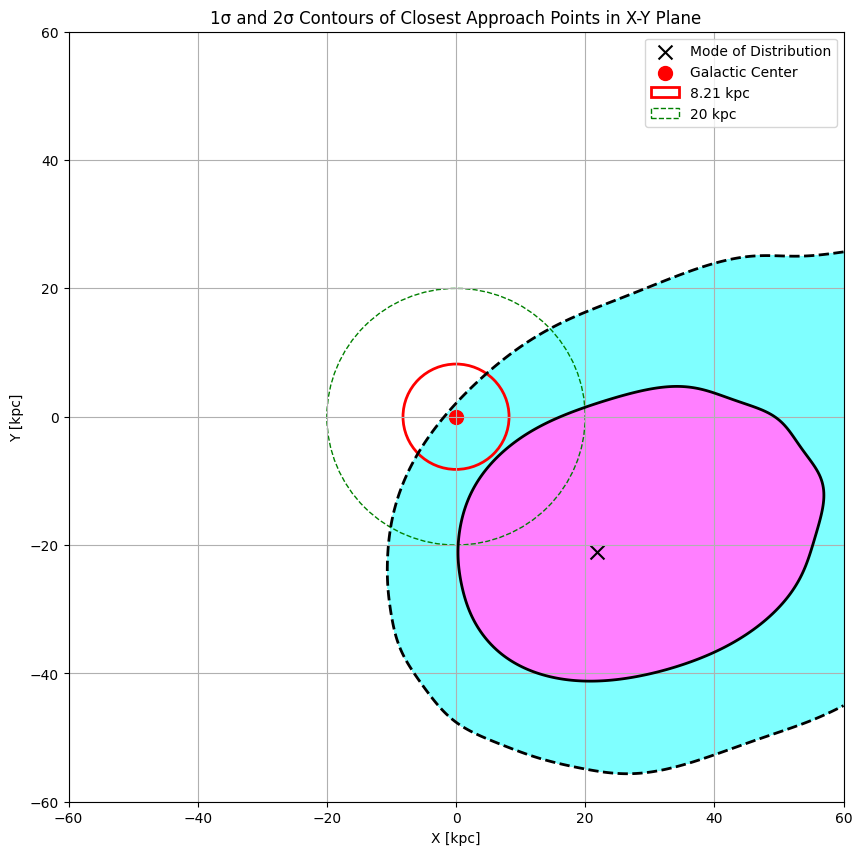

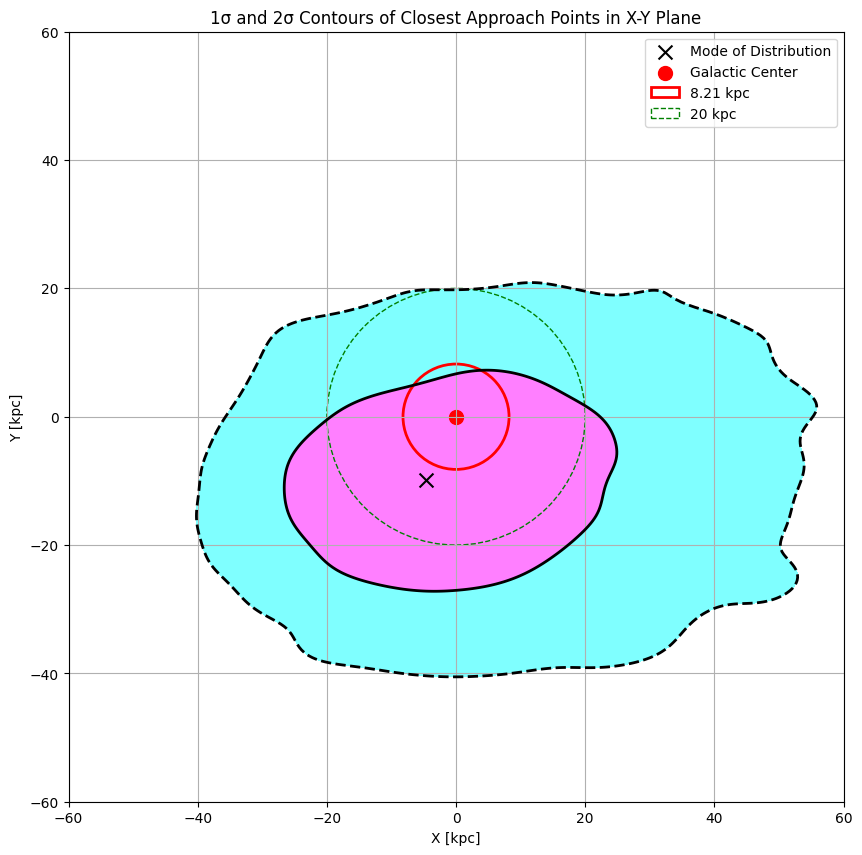

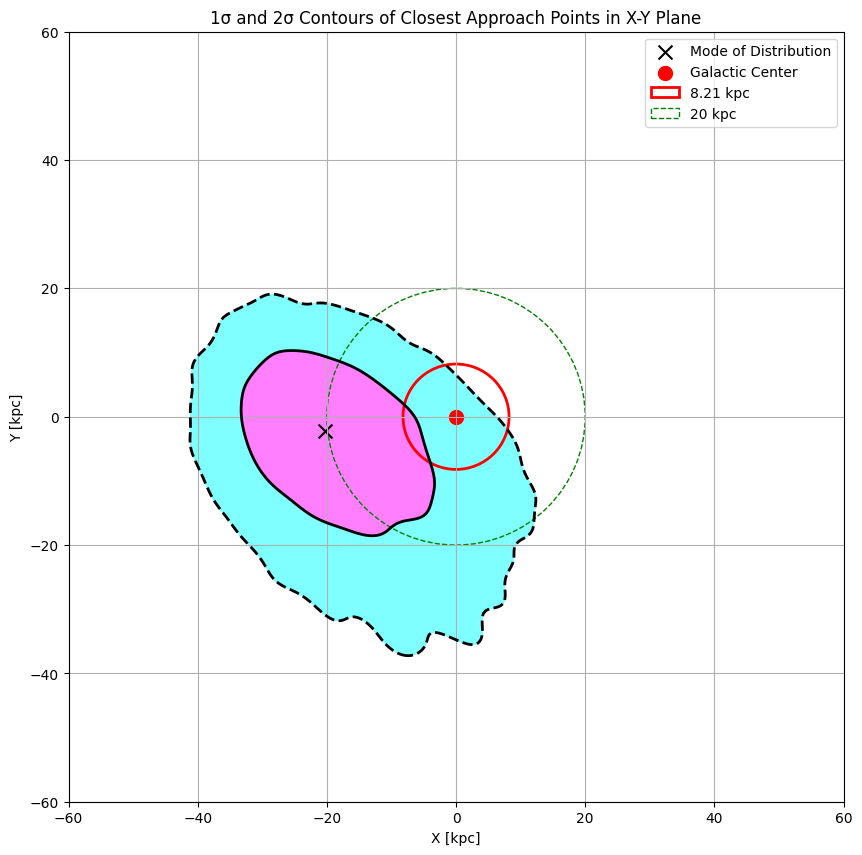

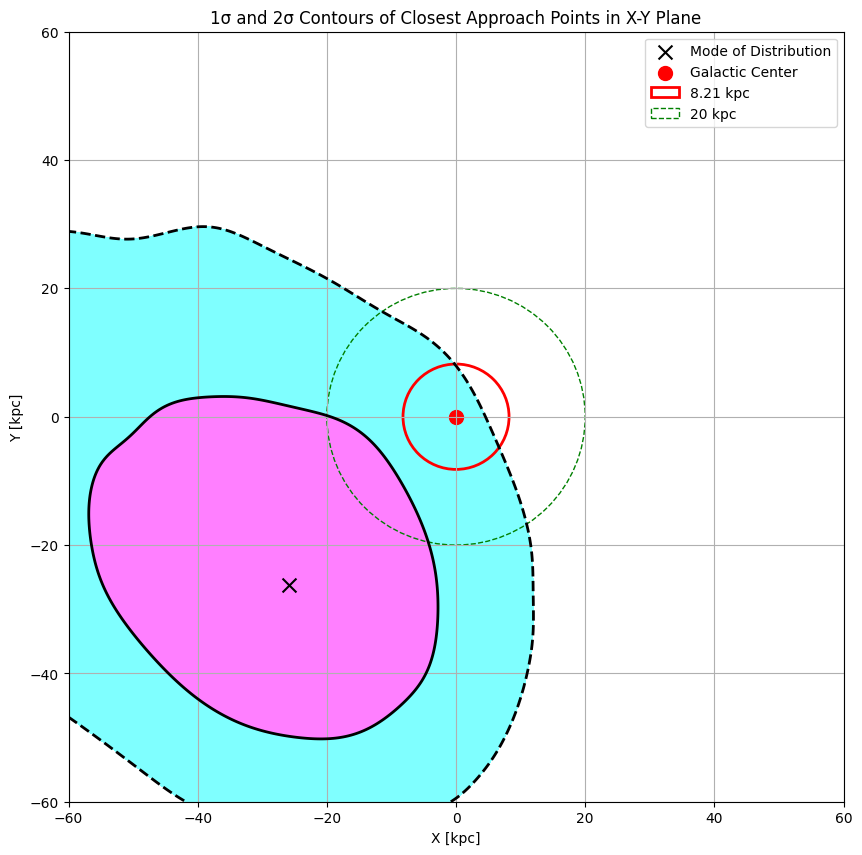

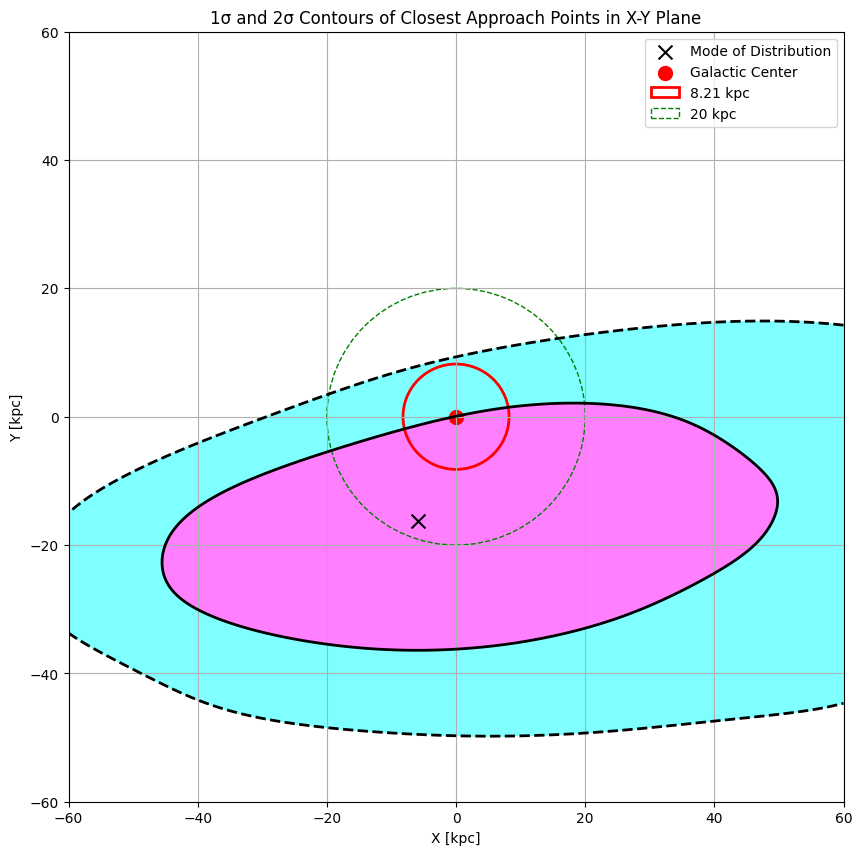

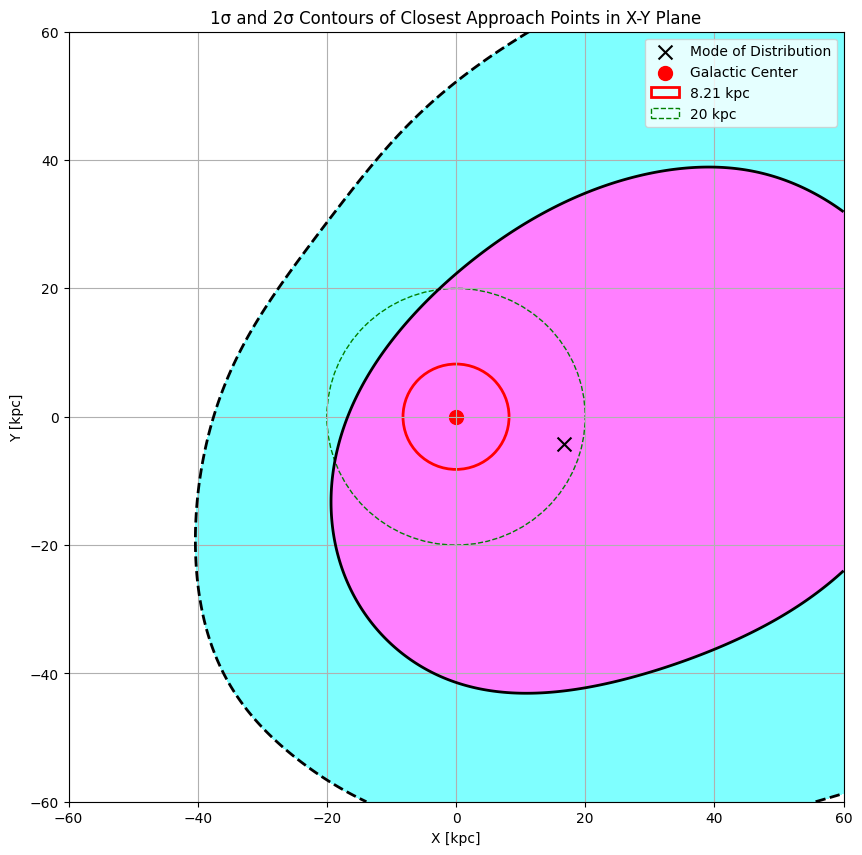

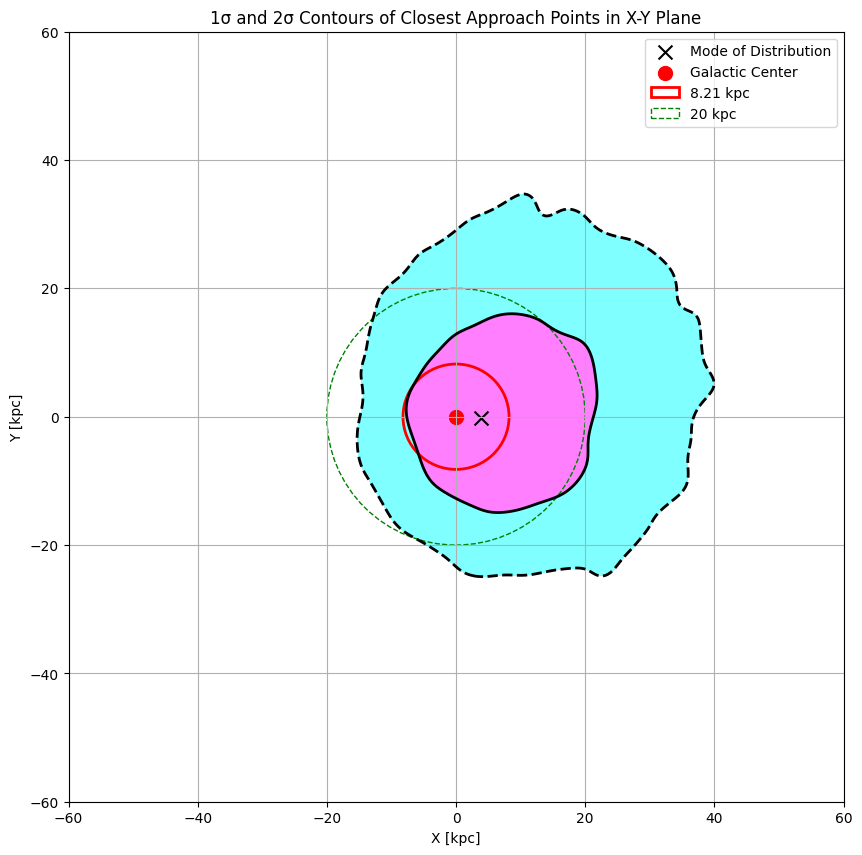

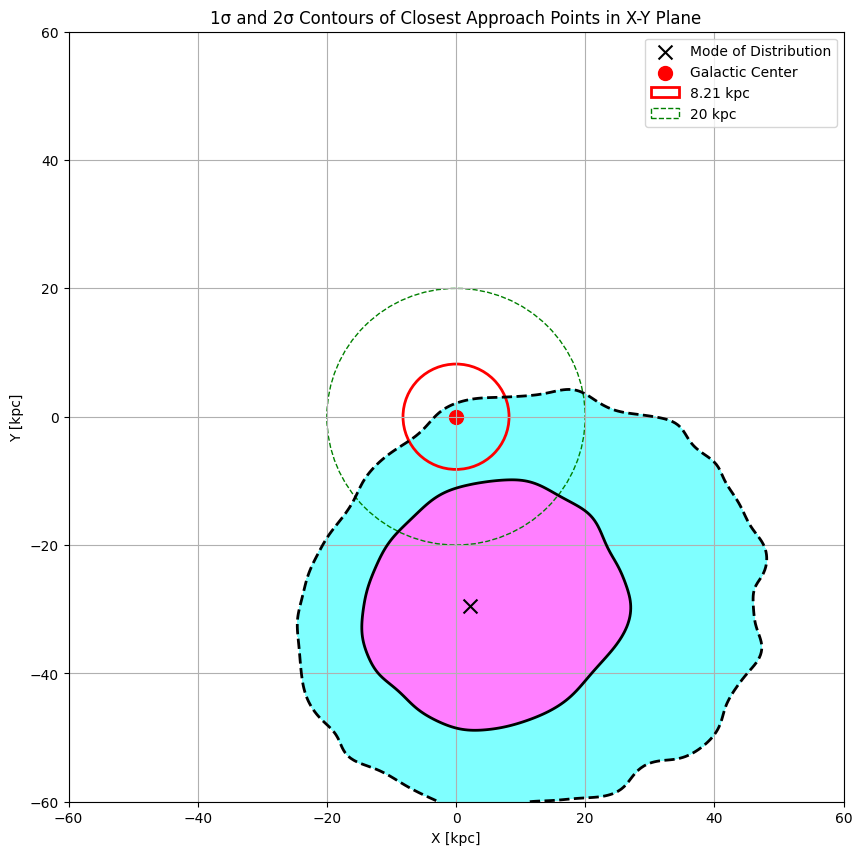

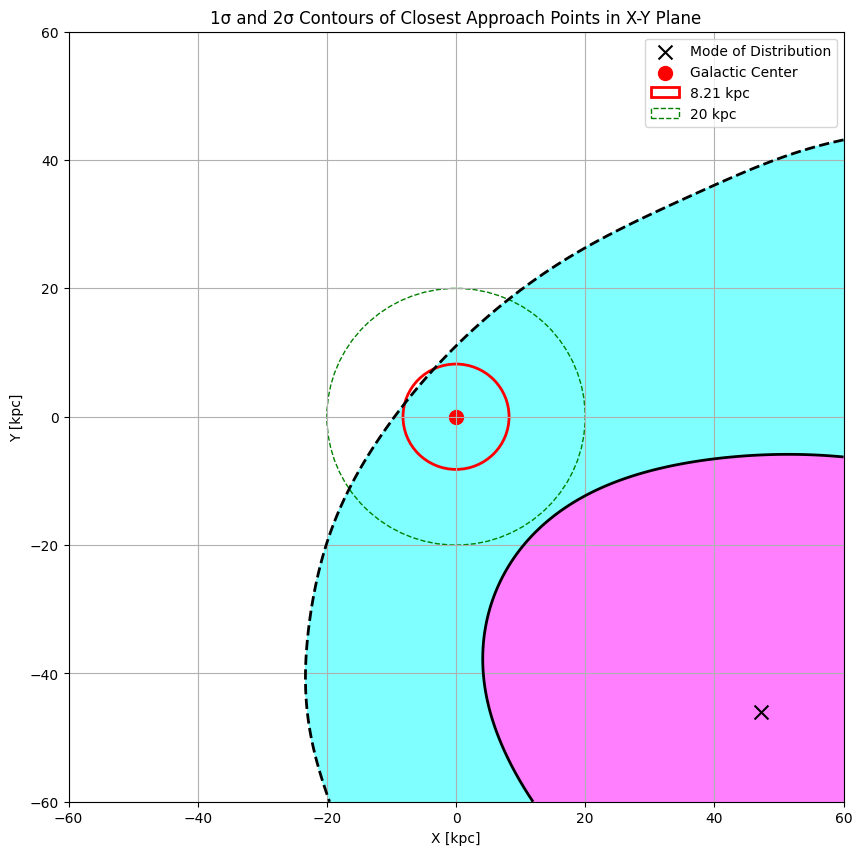

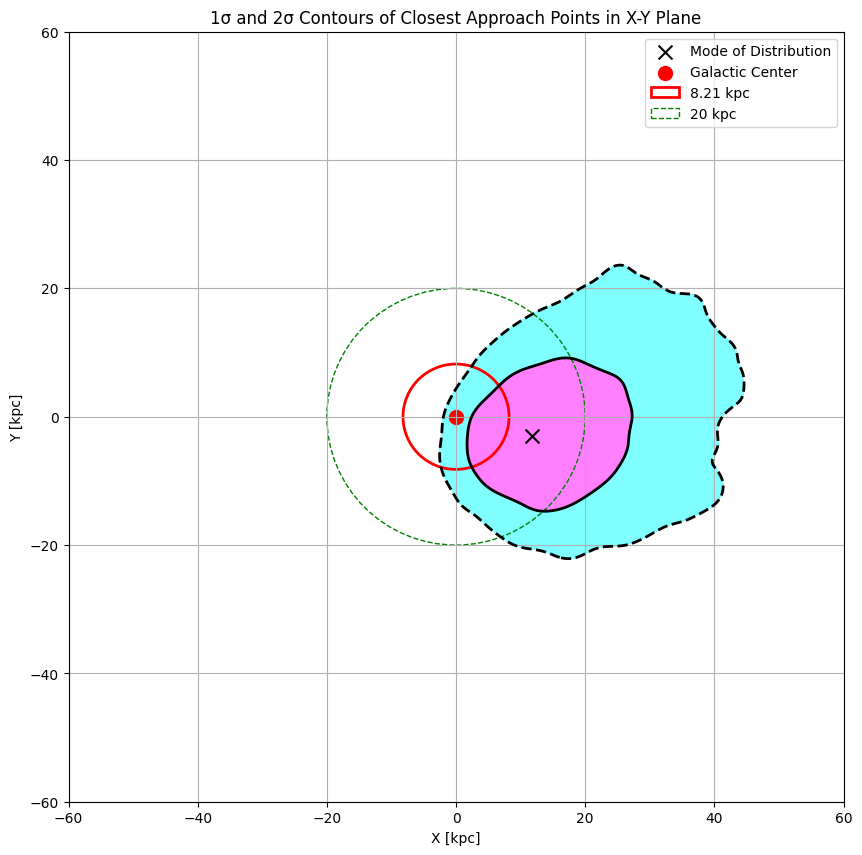

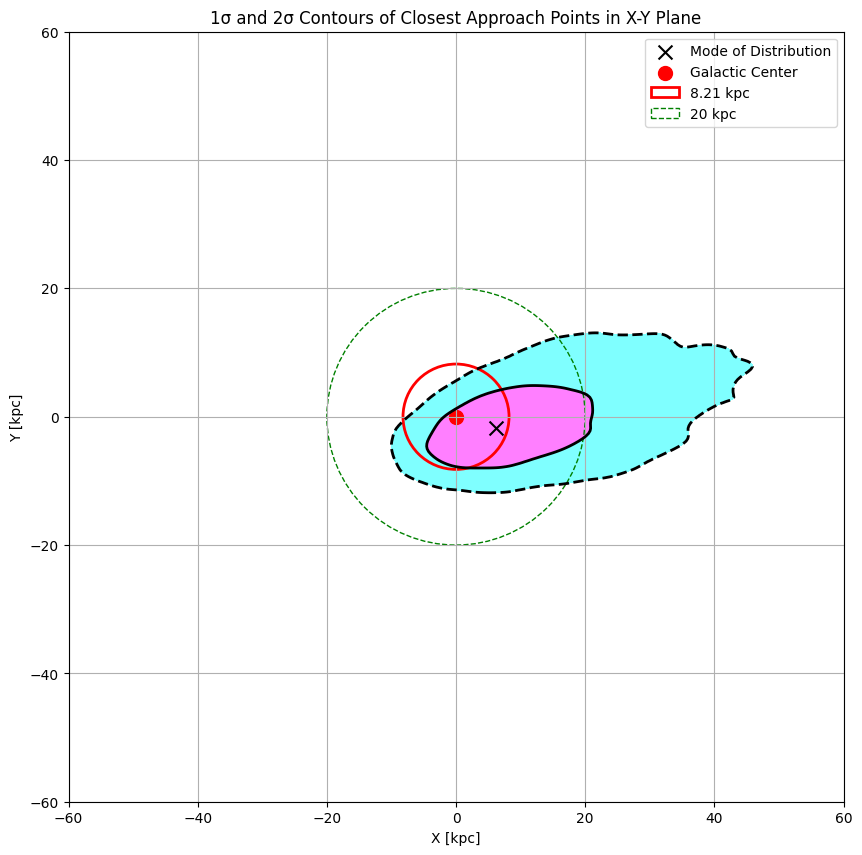

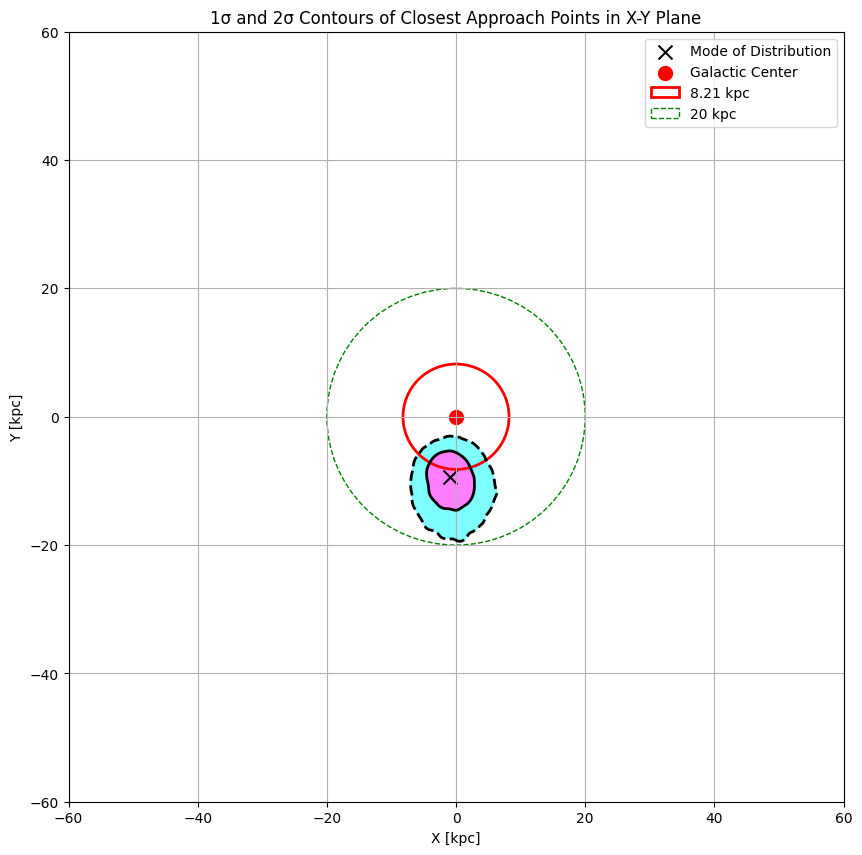

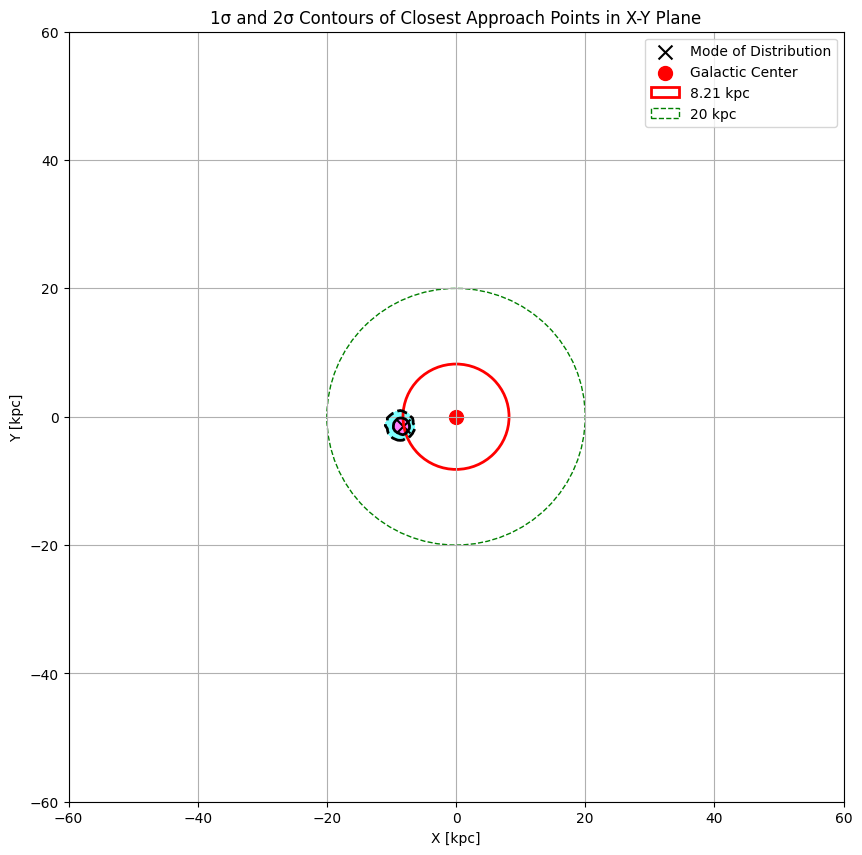

In [9]:
for i in range(len(brown_data)):
    oia.plot_sigma_contours(plane_crossings[i], star_name=brown_data.iloc[[i]].ID.values[0], save=True)

# McMillan17 potential and HST

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1018.13it/s]
/app/data/scripts/orbit_integration_agama.py:83: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()], colors=['k', 'k', 'k'],


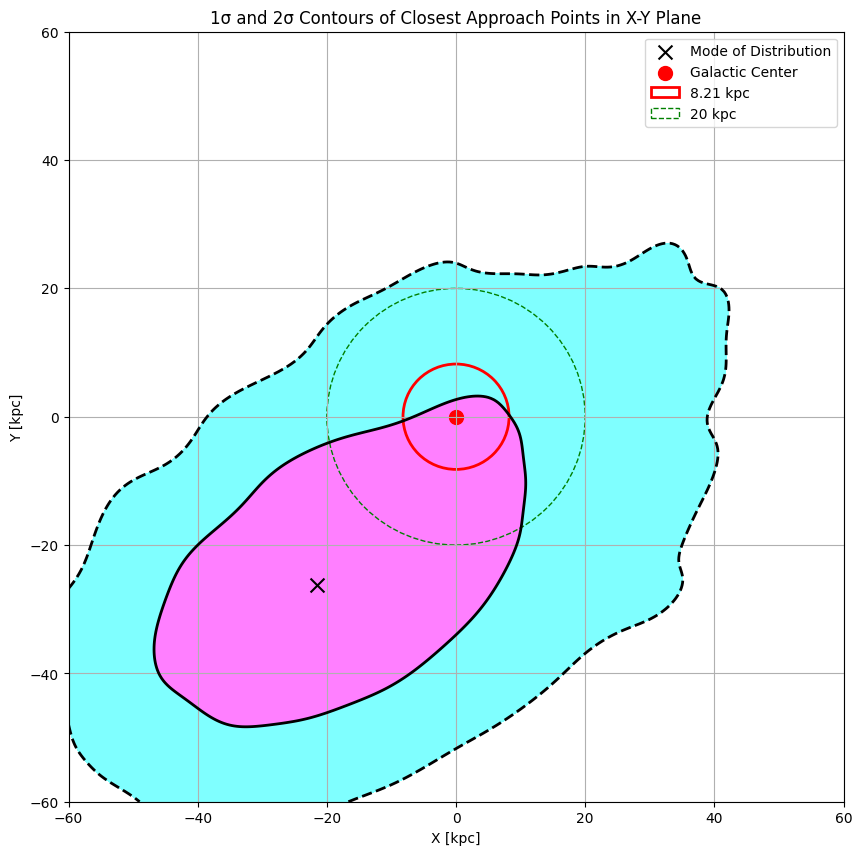

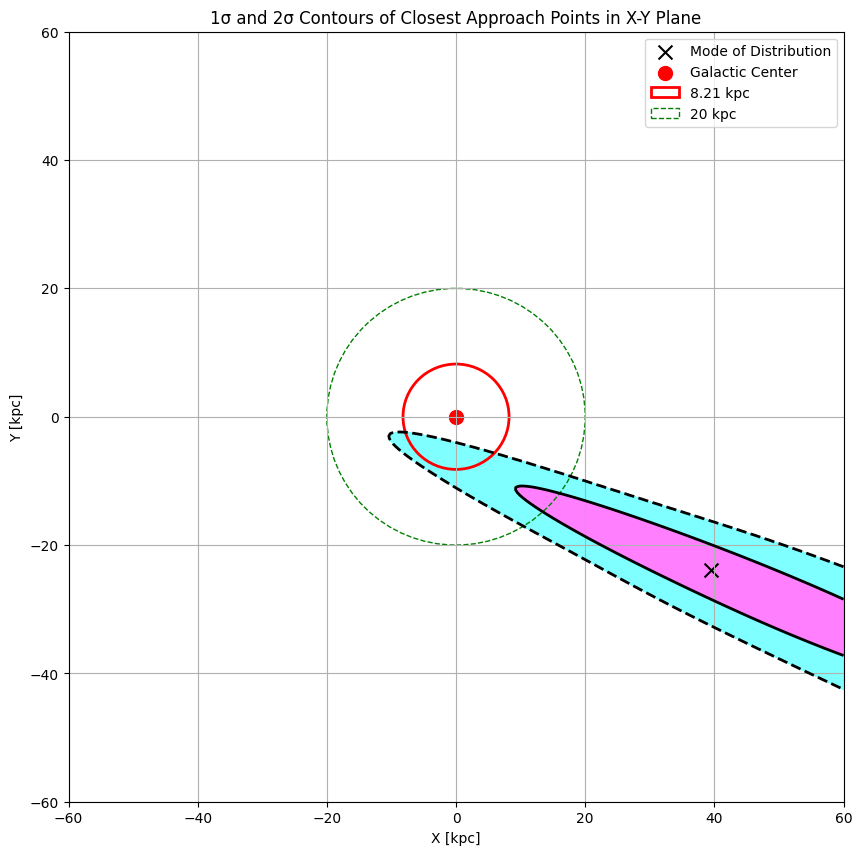

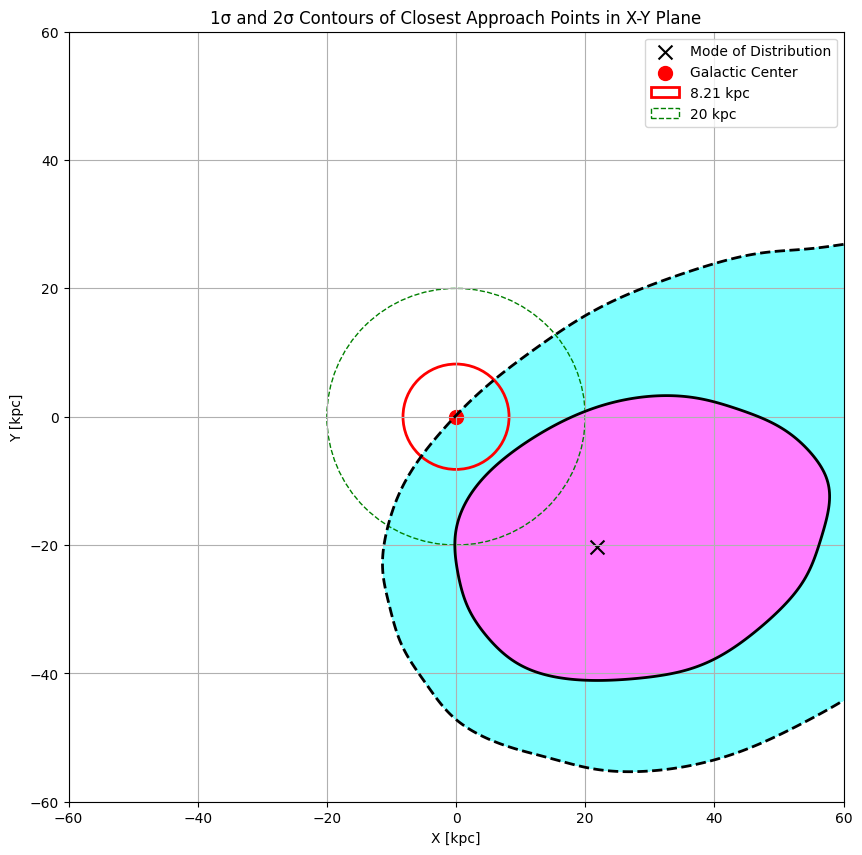

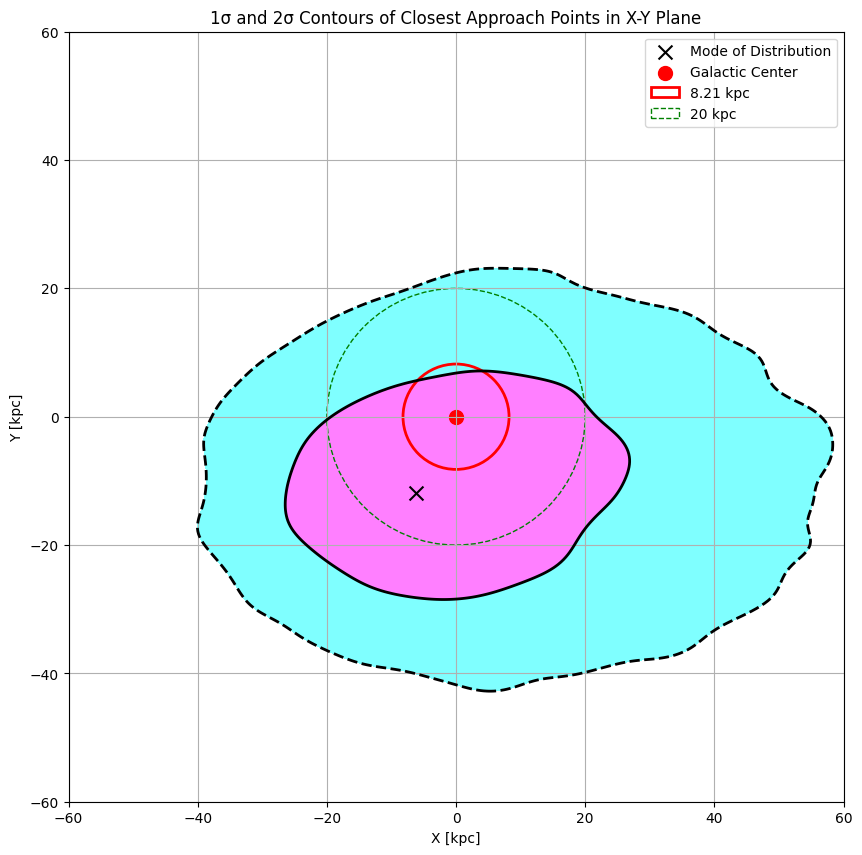

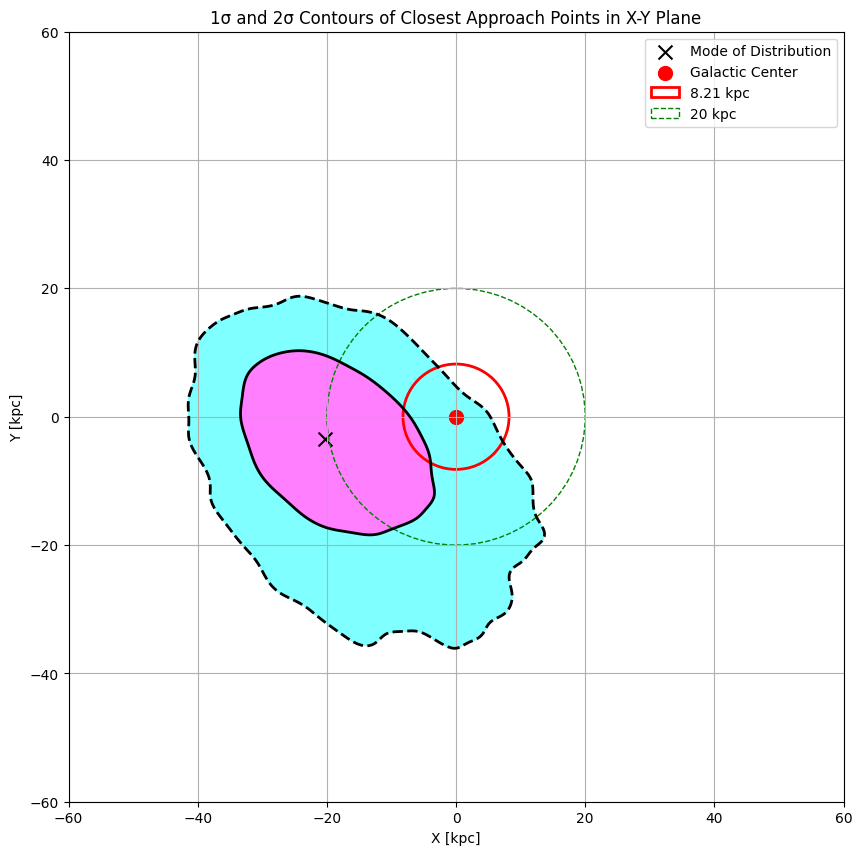

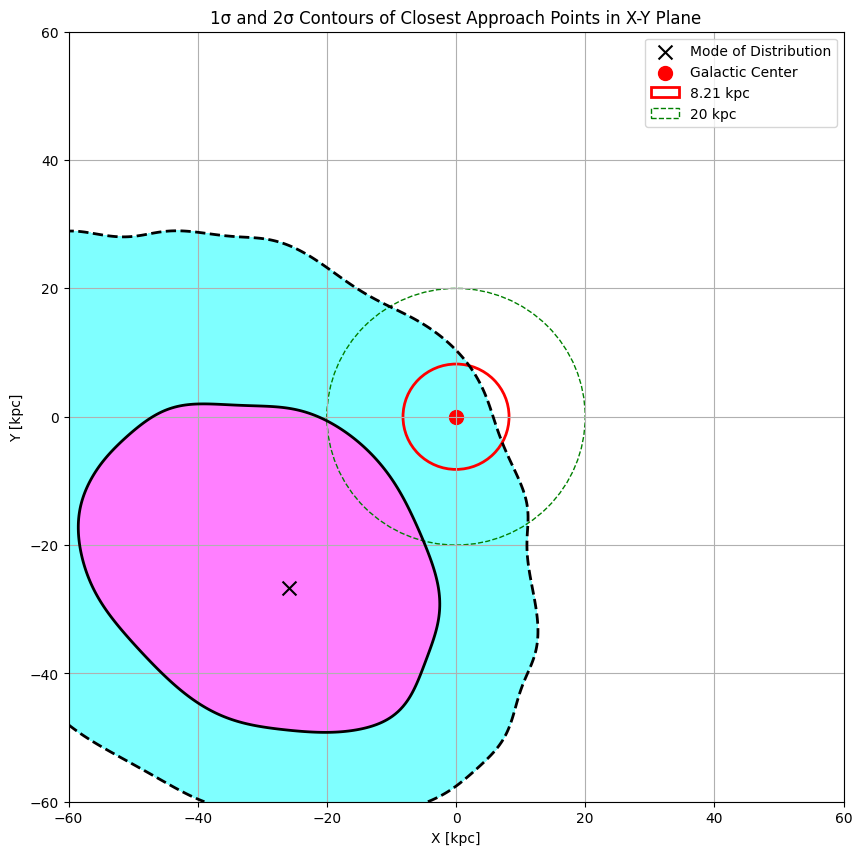

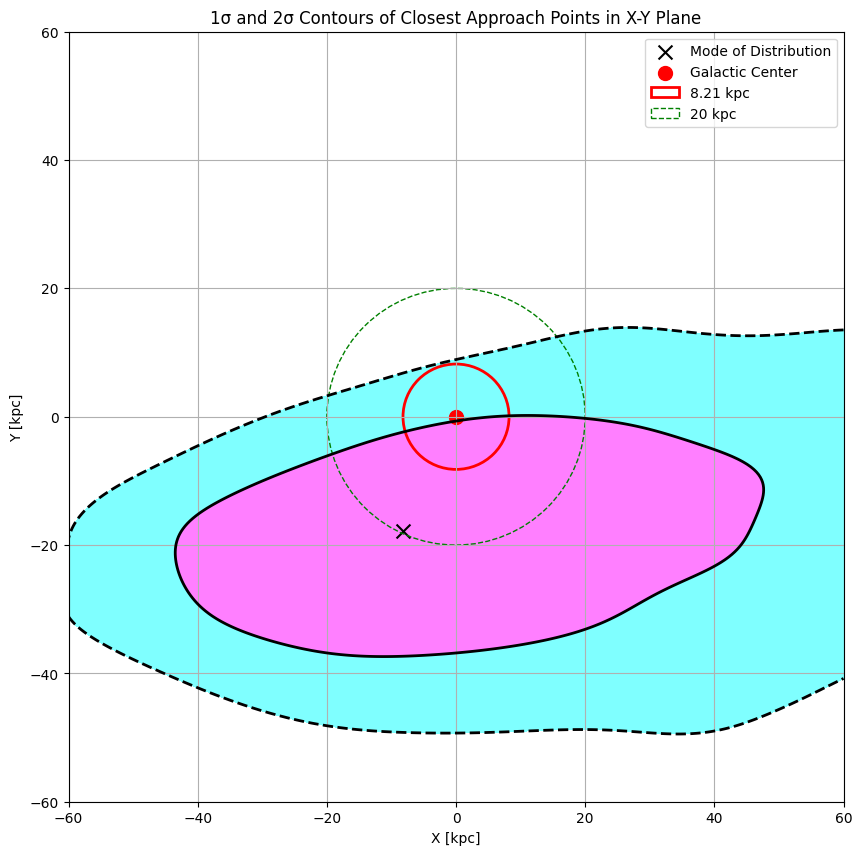

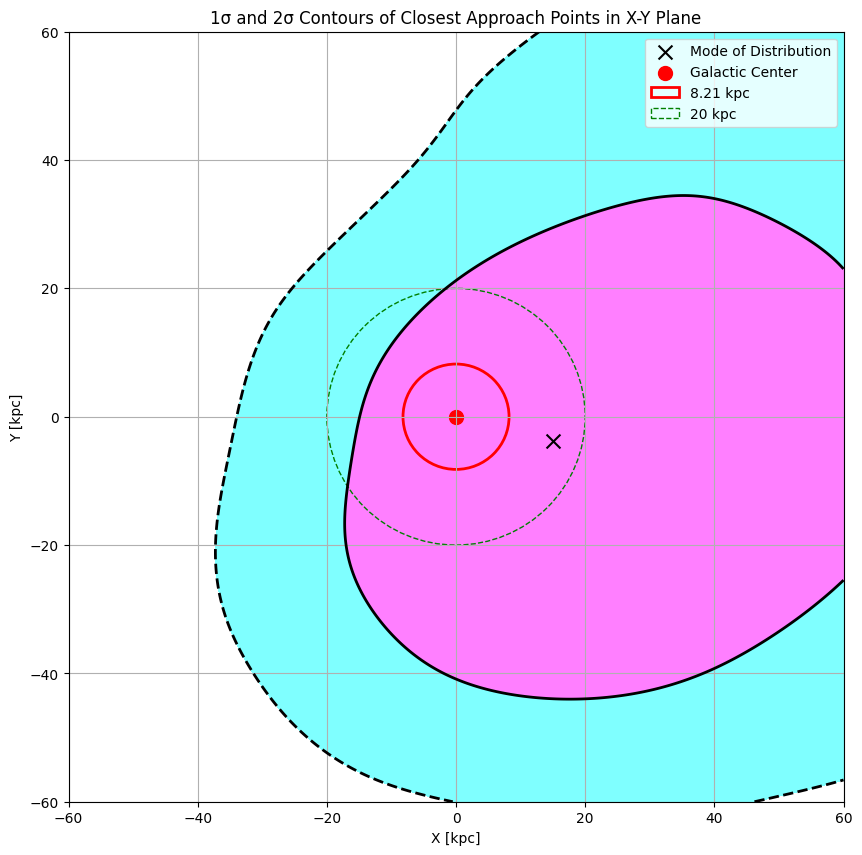

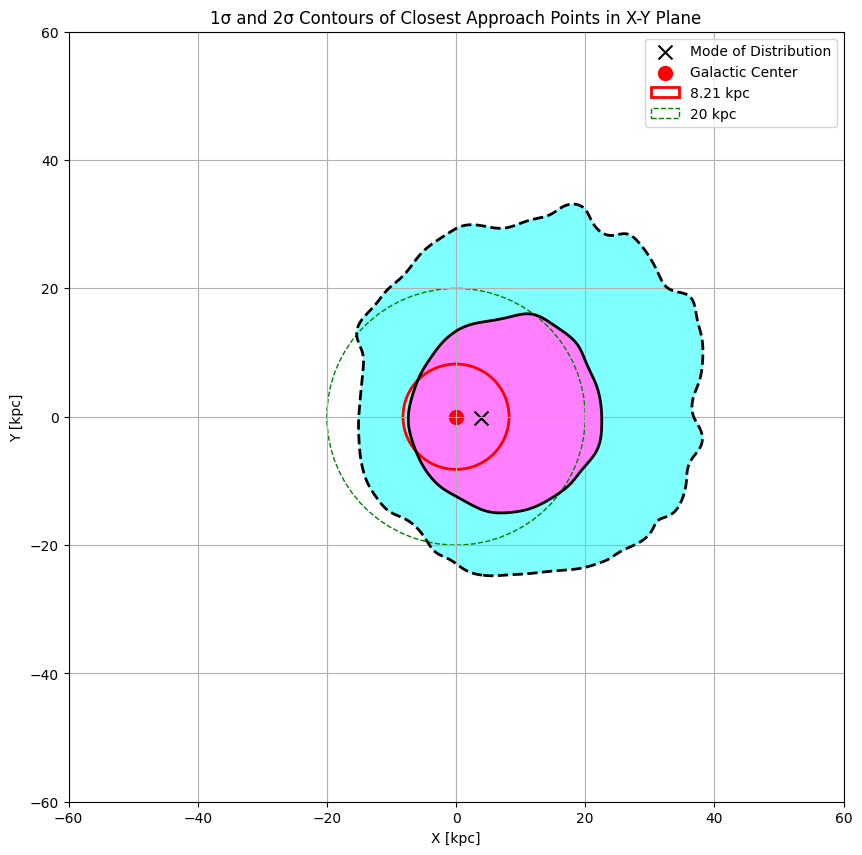

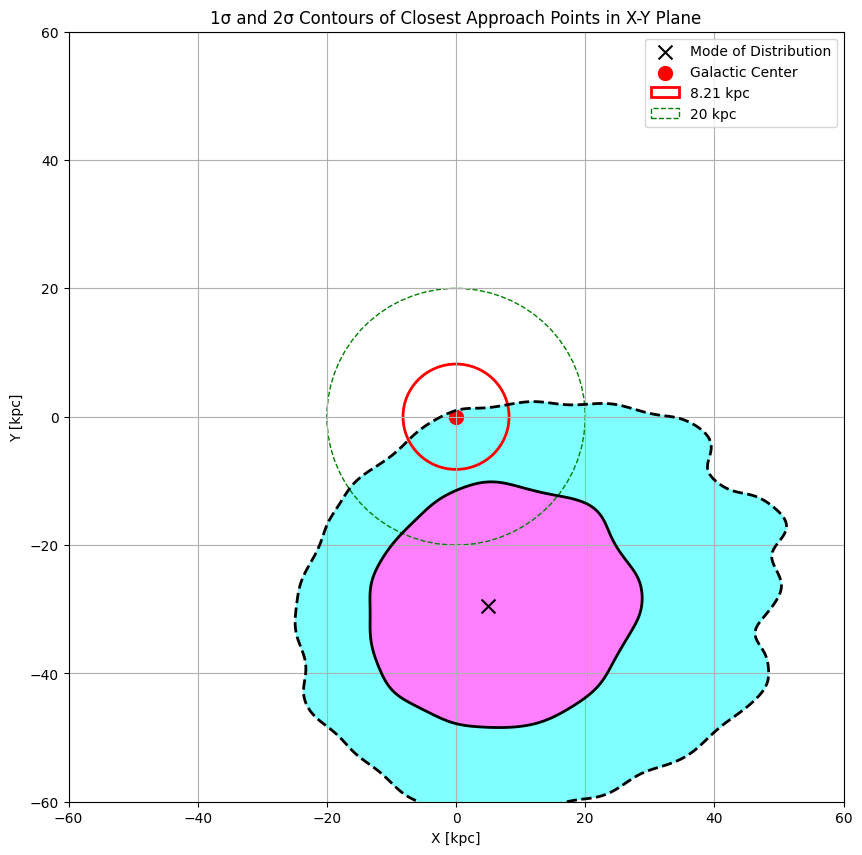

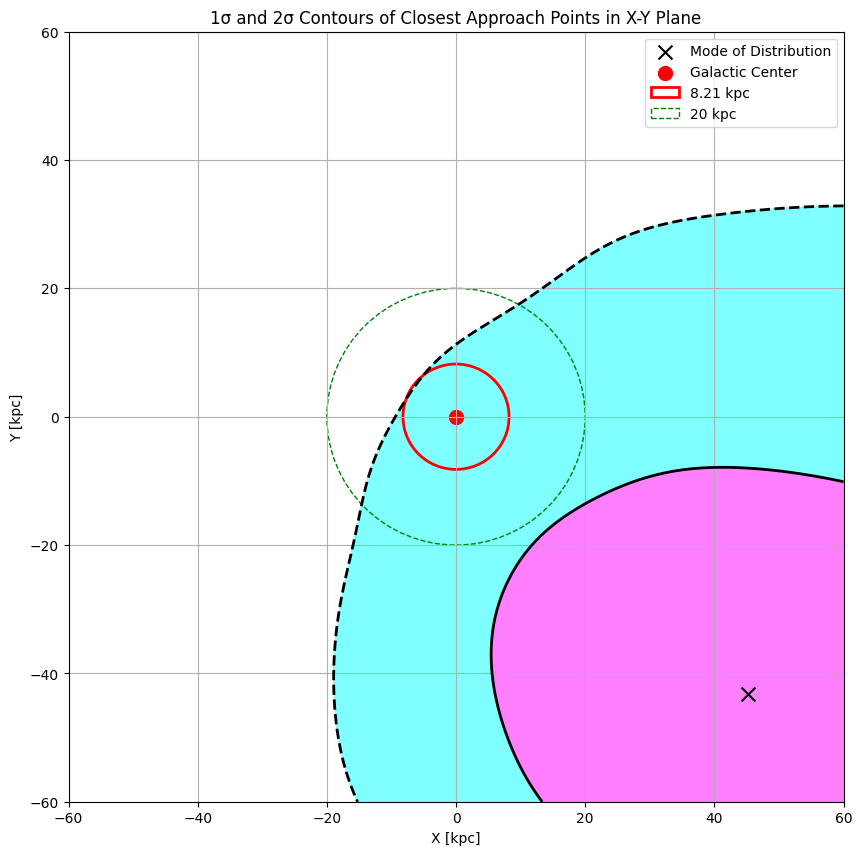

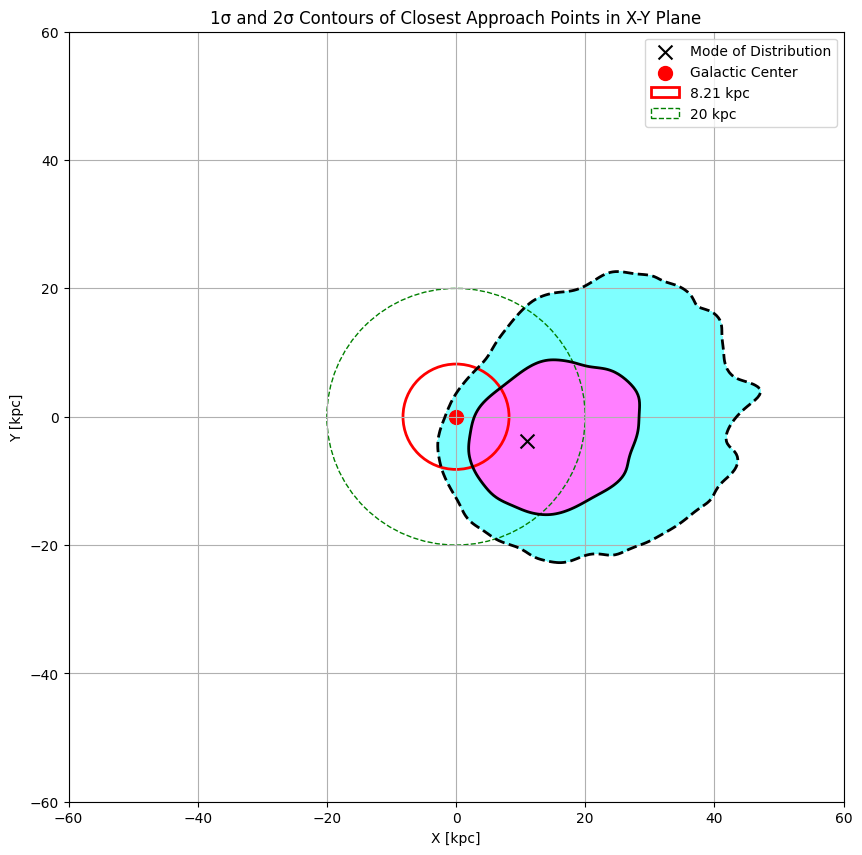

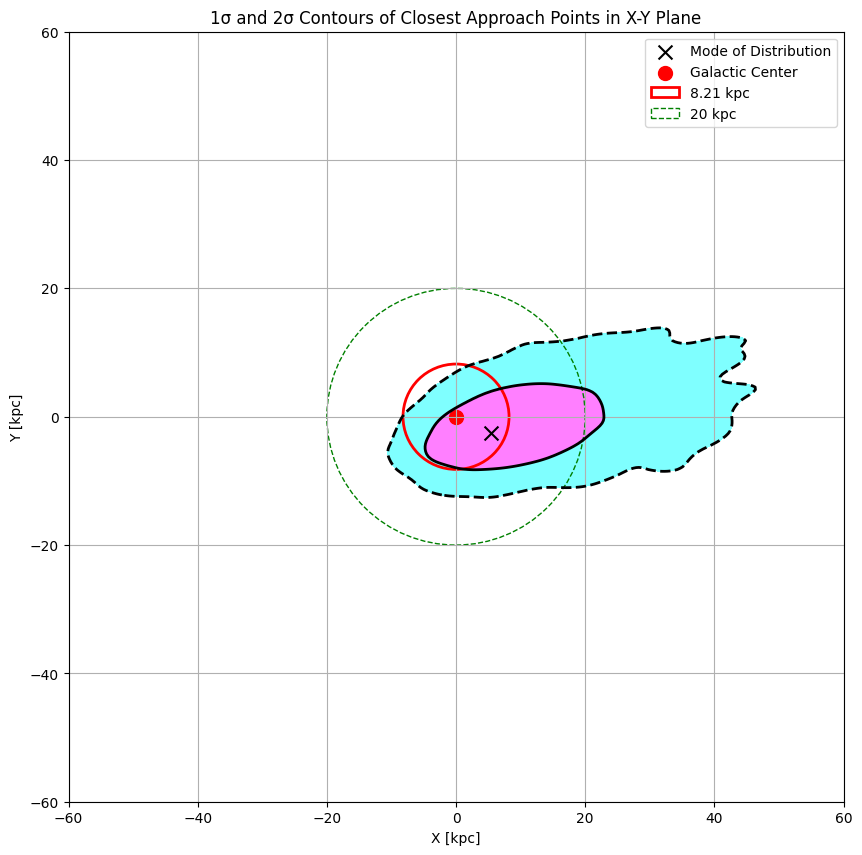

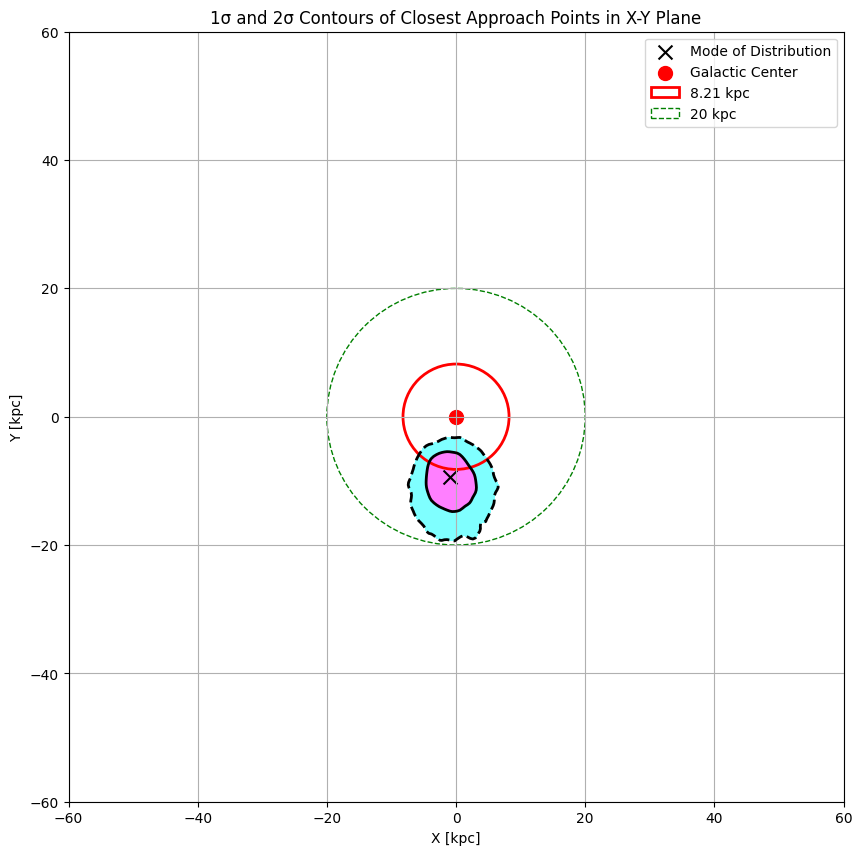

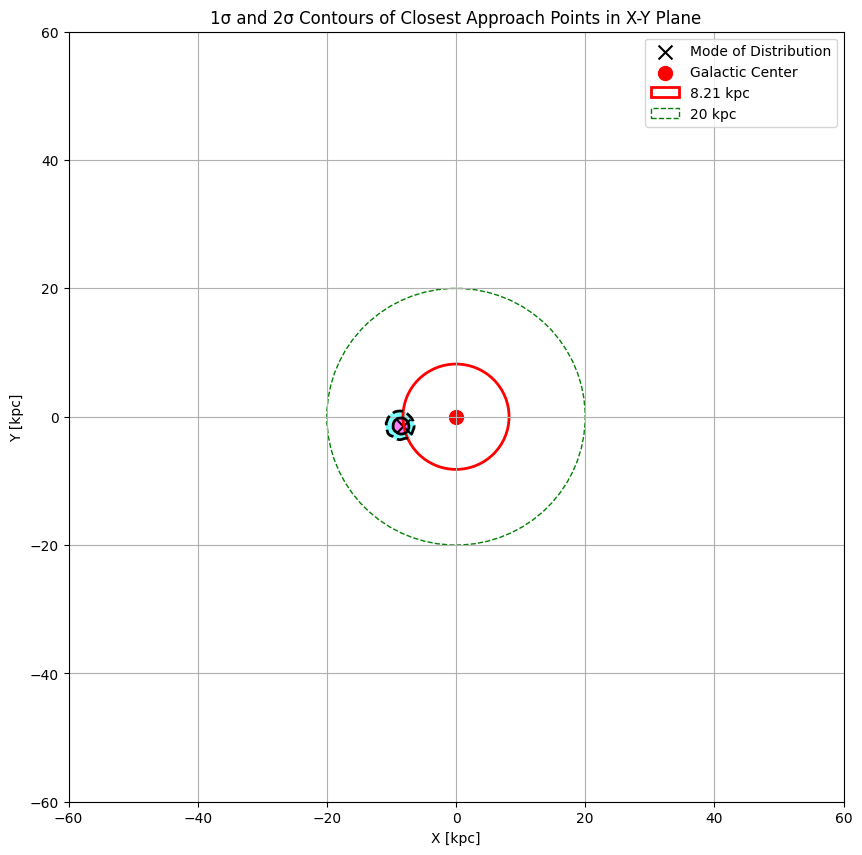

In [22]:
# compute orbits for all brown stars using HST proper motions, this should give the exact same contours as Figure 4 in the paper
plane_crossings = []
for i in range(len(brown_data)):
    star = brown_data.iloc[[i]]
    plane_crossings.append(oia.integrate_orbits_to_plane_crossing_agama_parallel(star, n_samples=10000,
                                                        integration_time=-0.3,  
                                                        pmra_col='mu_ra',
                                                        pmdec_col='mu_dec',
                                                        pmra_error_col='mu_ra_error',
                                                        pmdec_error_col='mu_dec_error', 
                                                        potential_file='Agama/McMillan2011.pot'))

save_path_plots = 'Plots/brown_stars/McMillan17_HST'
for i in range(len(brown_data)):
    oia.plot_sigma_contours(plane_crossings[i], star_name=brown_data.iloc[[i]].ID.values[0], save=True, save_path=save_path_plots)

# Compute plane crossing positions for all Brown stars using Gaia DR3 meaasurements

In [10]:
# compute orbits for all brown stars using HST proper motions, this should give the exact same contours as Figure 4 in the paper
plane_crossings = []
for i in range(len(brown_data)):
    star = brown_data.iloc[[i]]
    plane_crossings.append(oia.integrate_orbits_to_plane_crossing_agama_parallel(star, n_samples=10000,
                                                        integration_time=-0.3,  
                                                        pmra_col='pmra',
                                                        pmdec_col='pmdec',
                                                        pmra_error_col='pmra_error',
                                                        pmdec_error_col='pmdec_error', 
                                                        potential_file='Agama/brown2015.pot'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1216.36it/s]


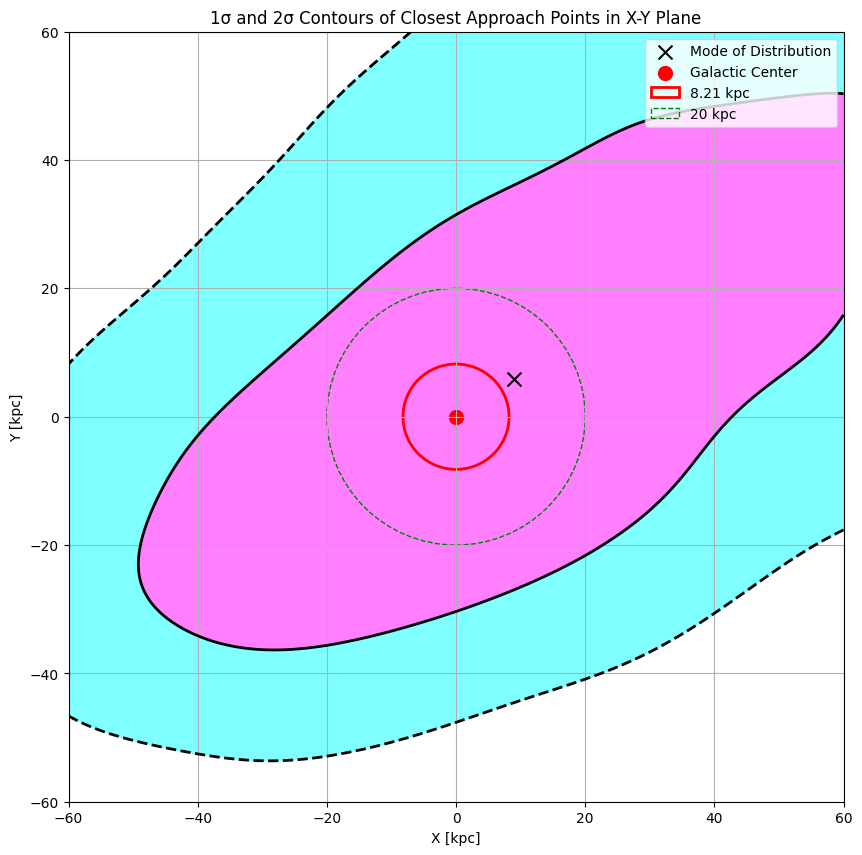

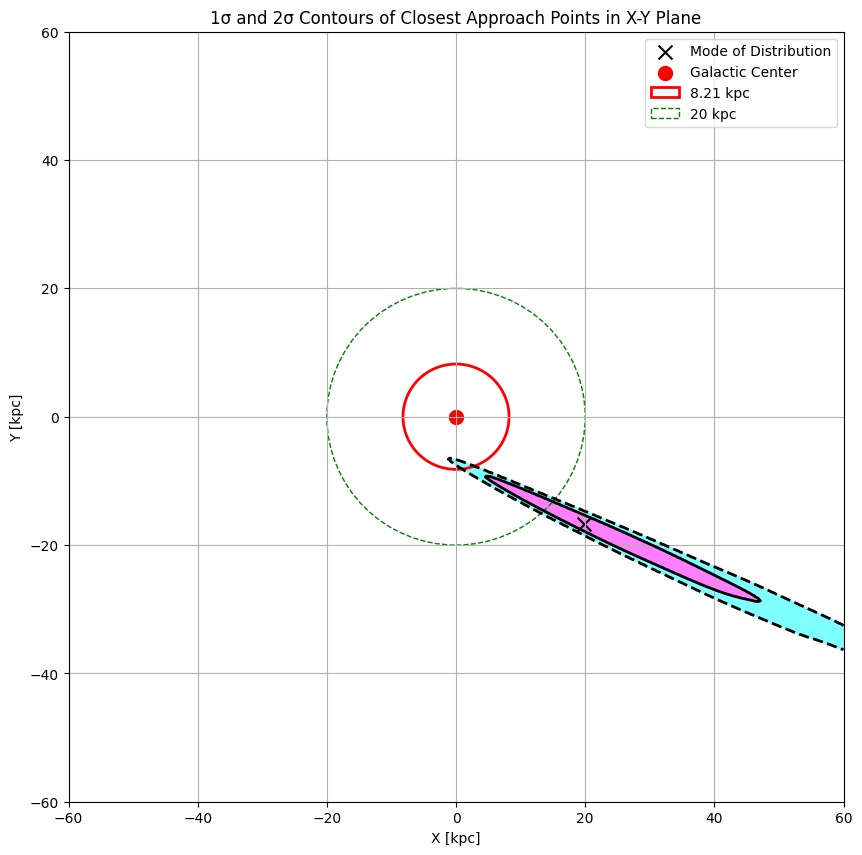

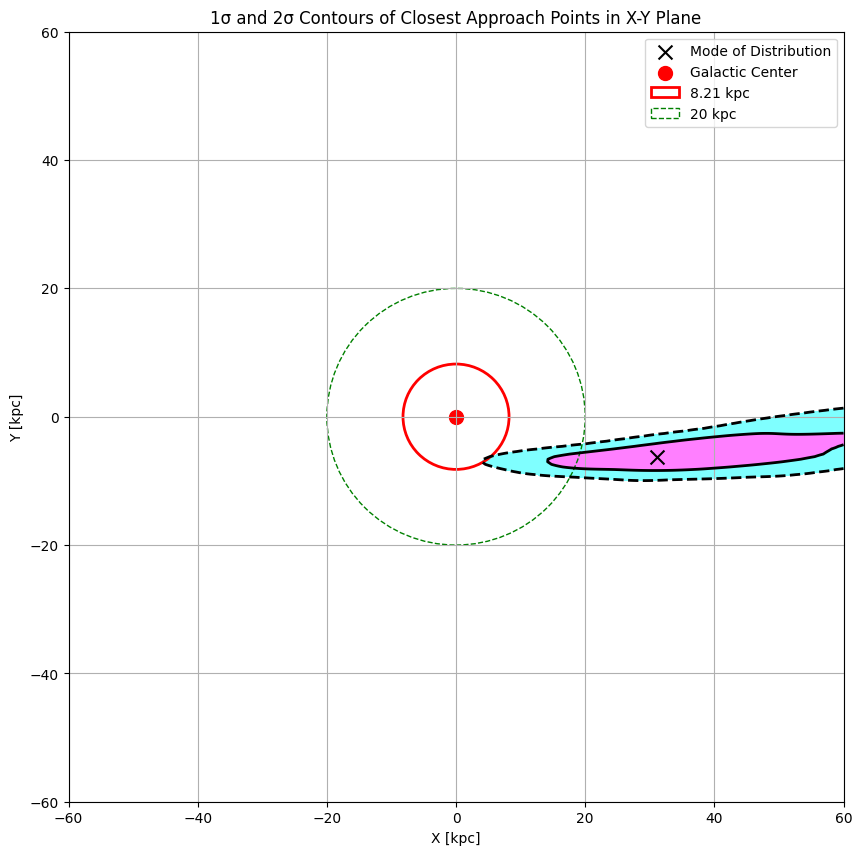

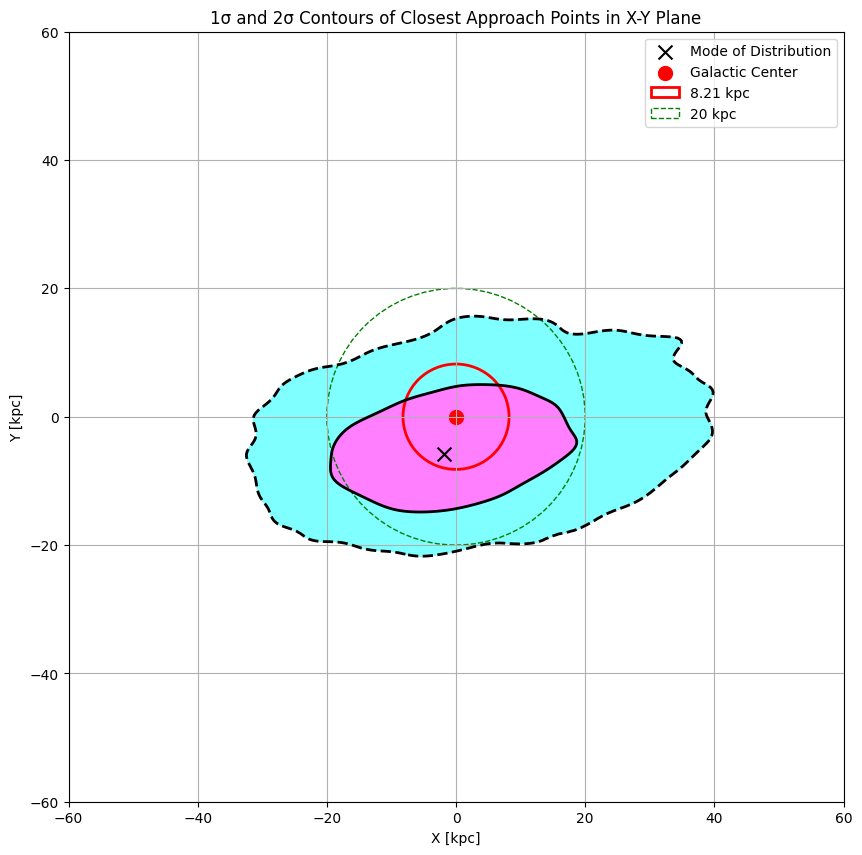

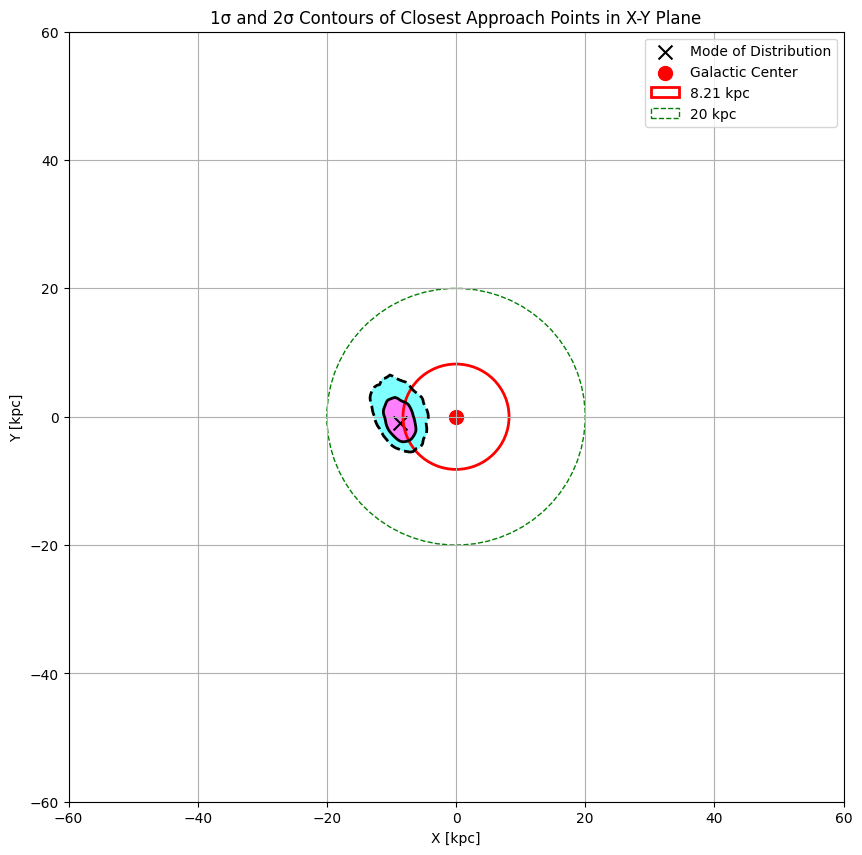

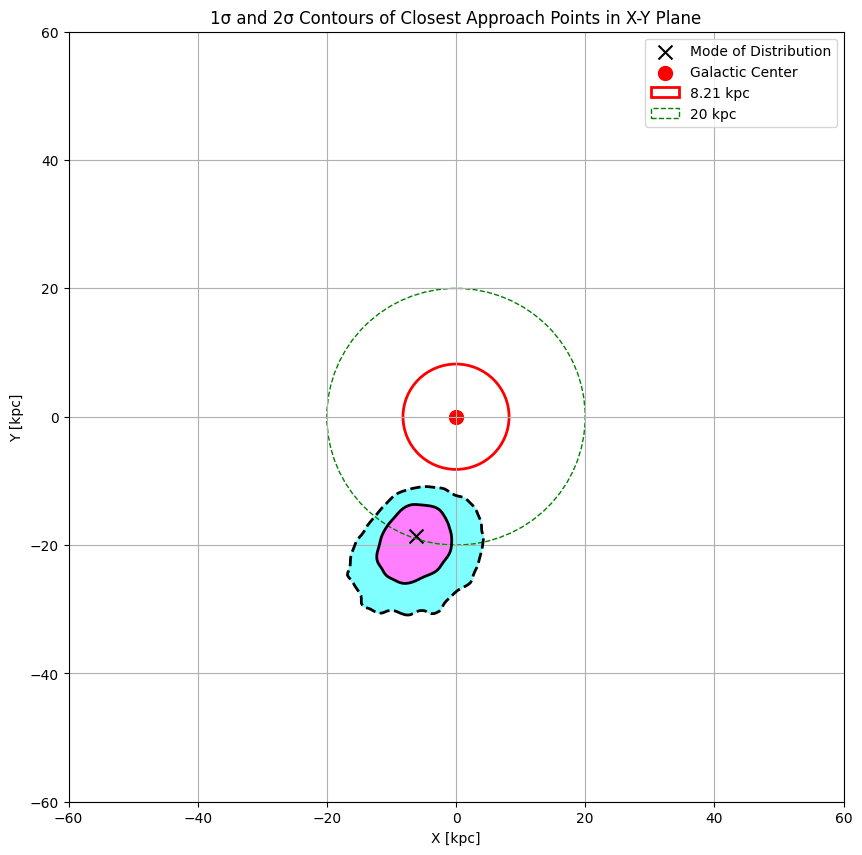

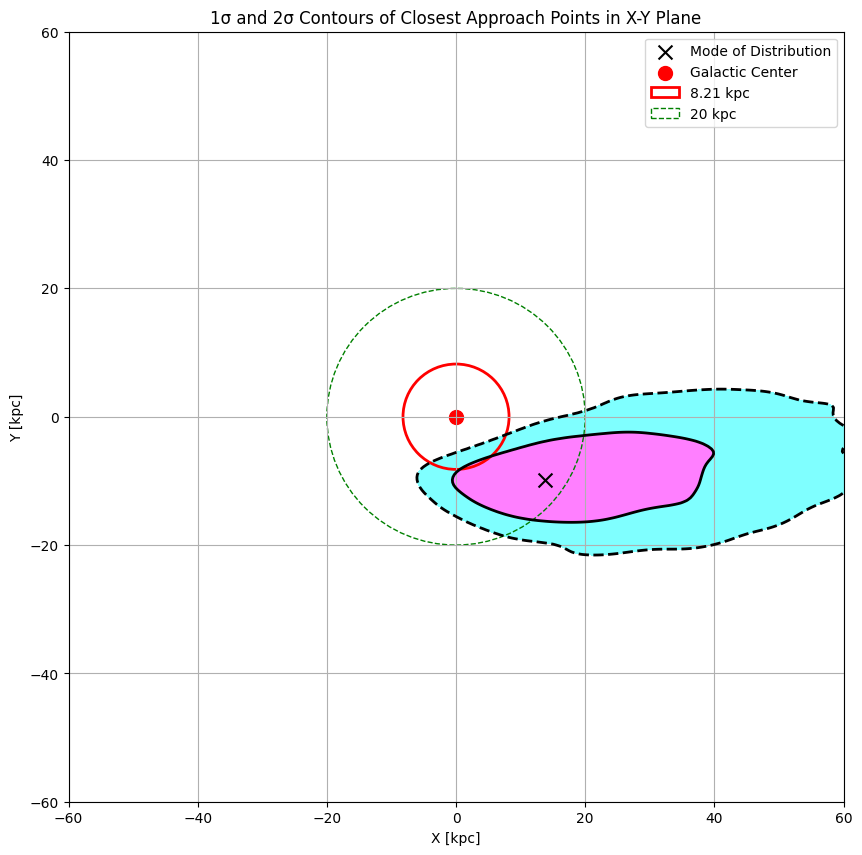

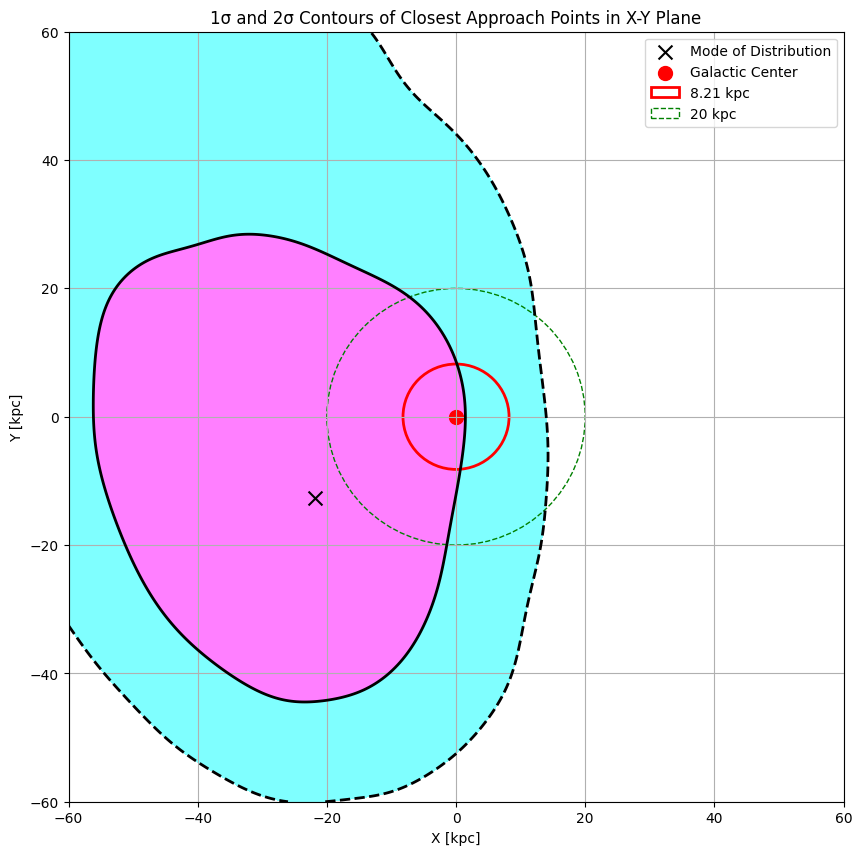

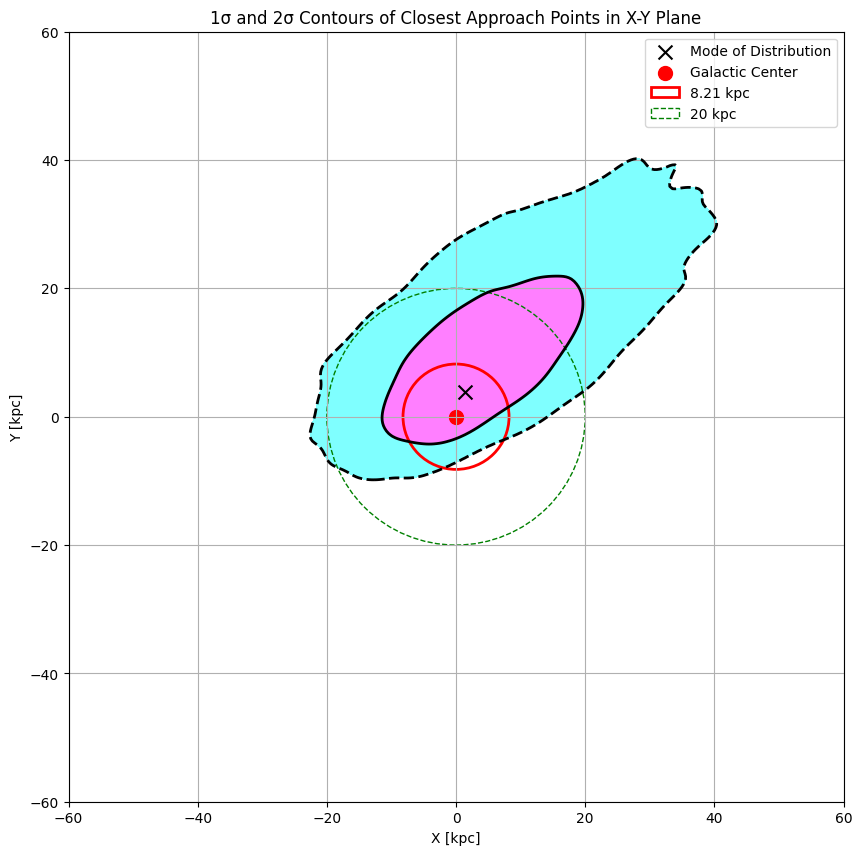

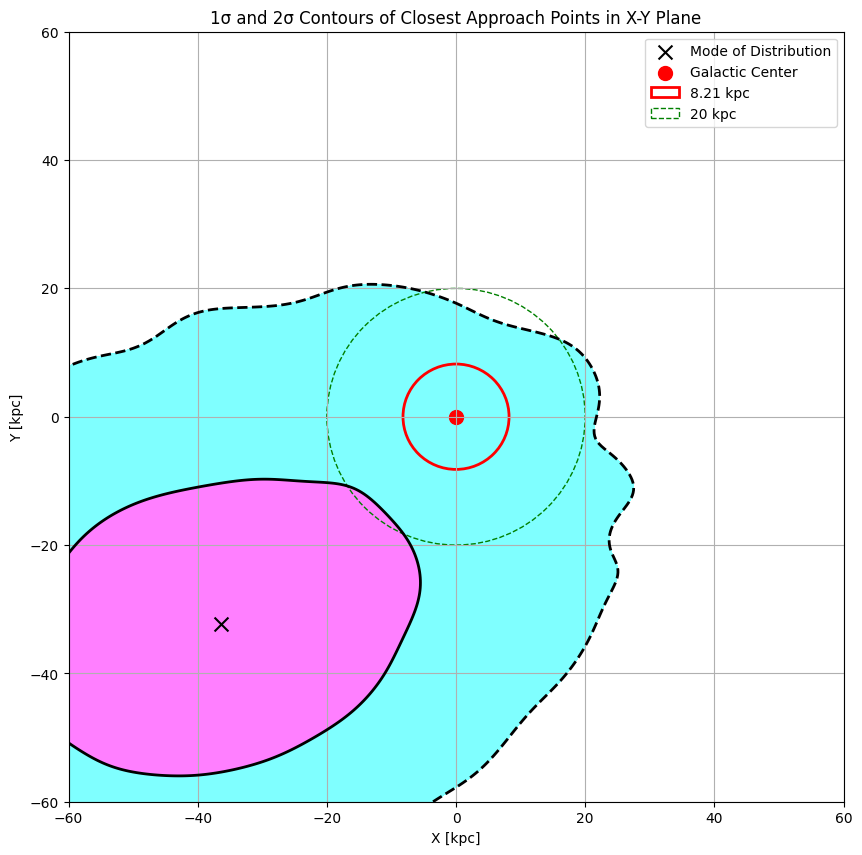

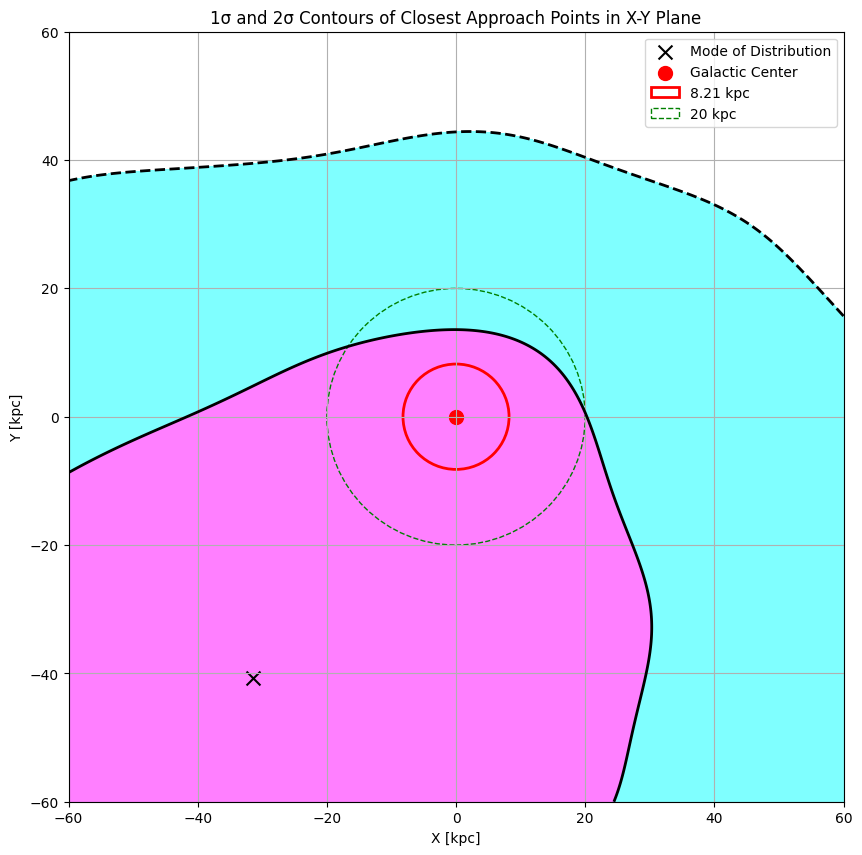

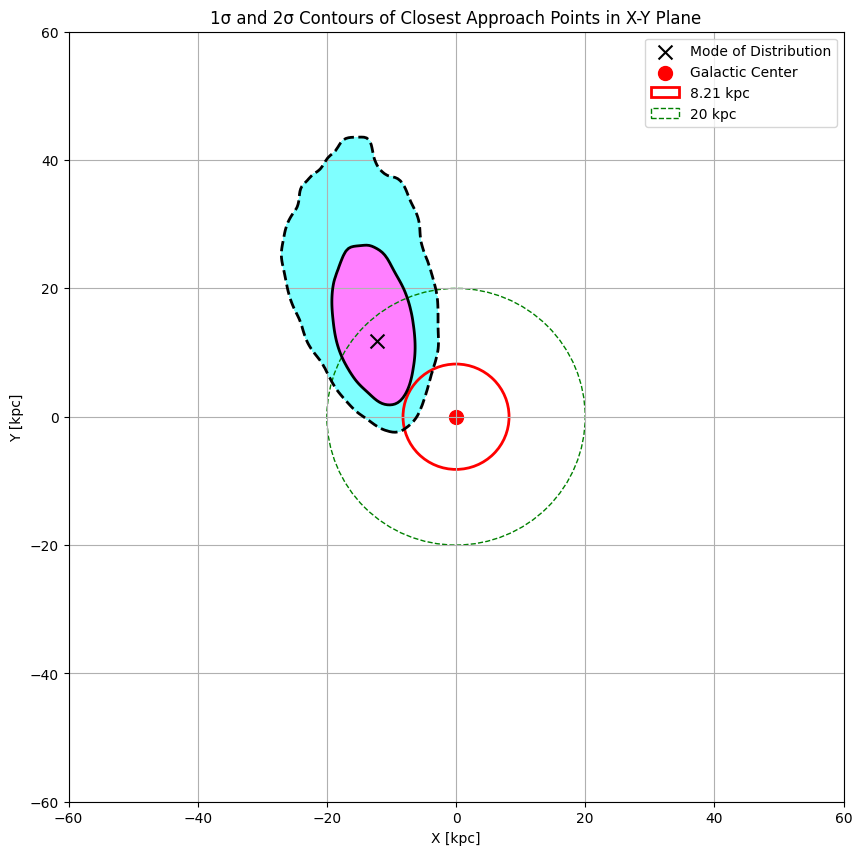

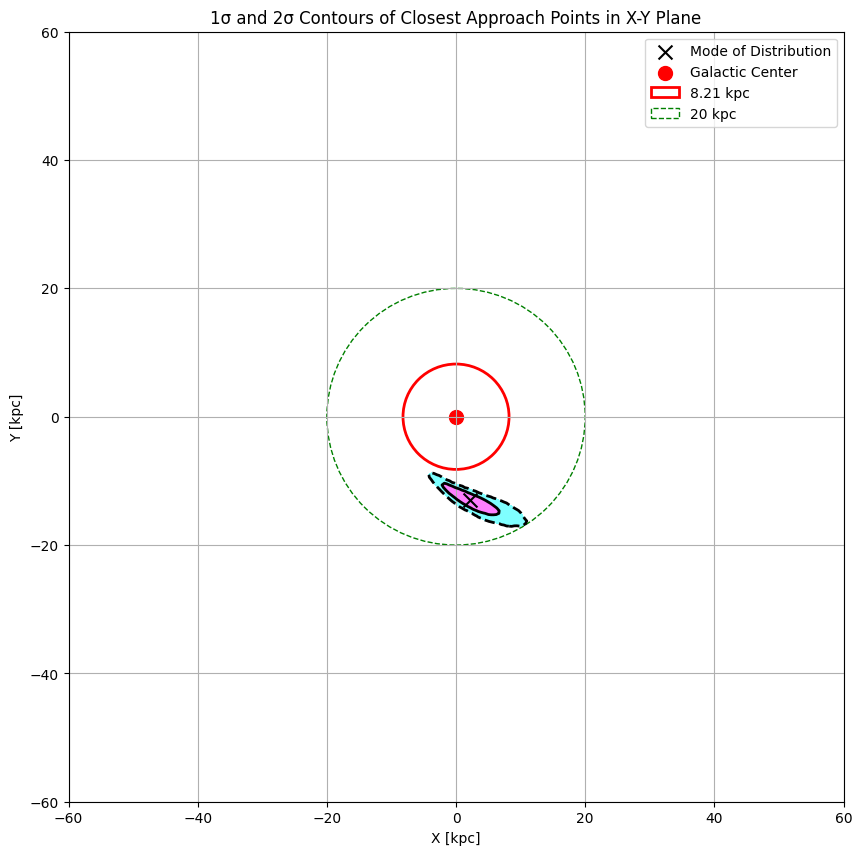

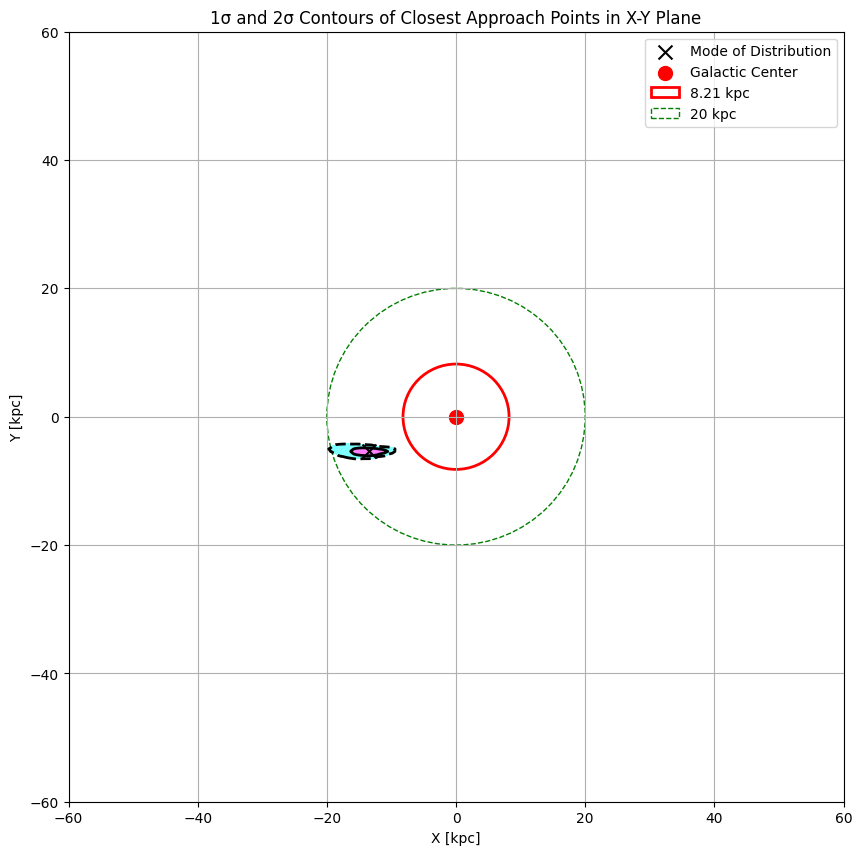

ValueError during contour plotting: Contour levels must be increasing


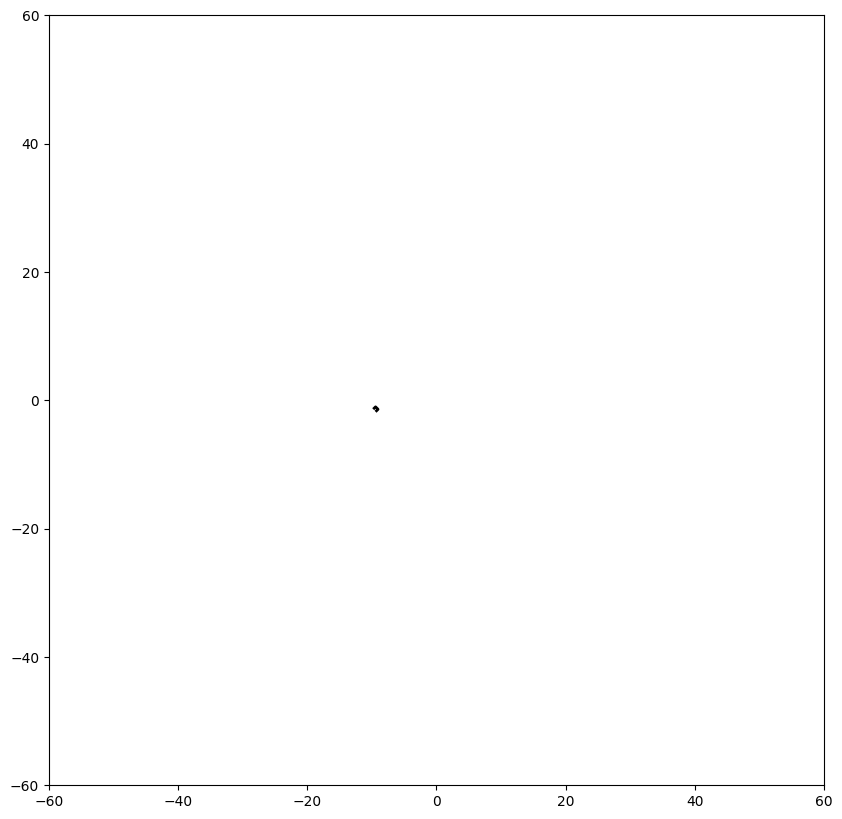

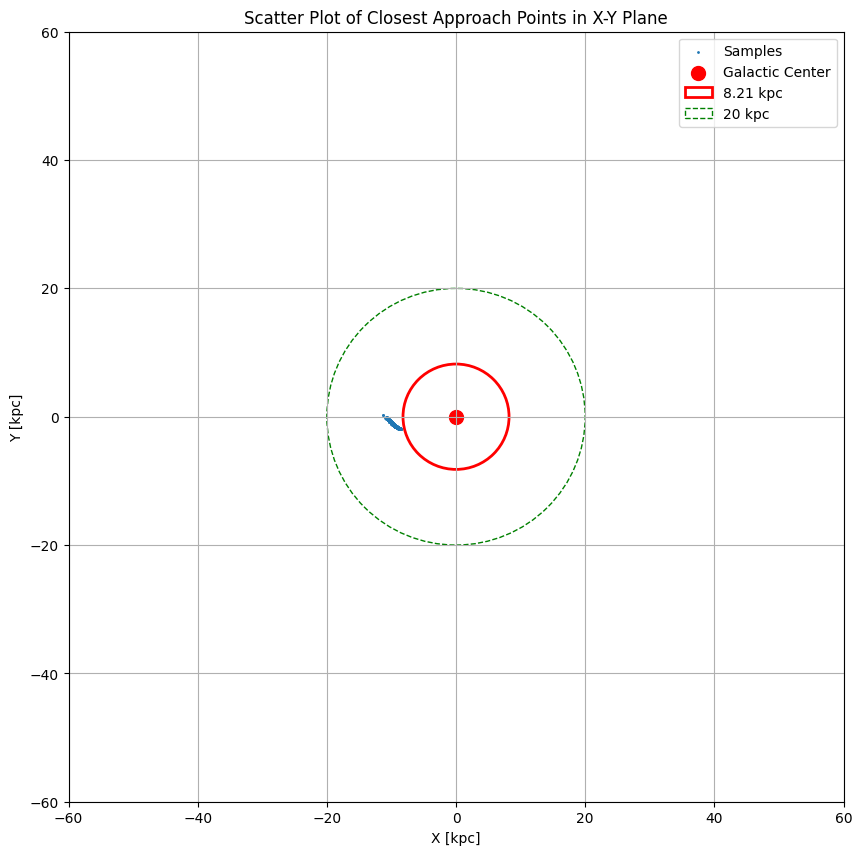

In [11]:
save_path = 'Plots/brown_stars/brown_potential_gaia_dr3_pm'
for i in range(len(brown_data)):
    plot_sigma_contours(plane_crossings[i], star_name=brown_data.iloc[[i]].ID.values[0], save_path=save_path)

In [ ]:
# test new plotting function
save_path = 'Plots/brown_stars/brown_potential_gaia_dr3_pm_m'
for i in range(len(brown_data)):
    try:
        oia.plot_sigma_contours_m(plane_crossings[i], star_name=brown_data.iloc[[i]].ID.values[0], save_path=save_path, save = True)
    except ValueError as e:
        print(f"ValueError during contour plotting: {e}")
        scatter_plot_origin(plane_crossings[i], save=True, star_name=brown_data.iloc[[i]].ID.values[0], save_path=save_path)
        continue

# Plane crossing using Gaia DR3 and McMillan17 potential

In [14]:
# compute orbits for all brown stars using HST proper motions, this should give the exact same contours as Figure 4 in the paper
plane_crossings = []
for i in range(len(brown_data)):
    star = brown_data.iloc[[i]]
    plane_crossings.append(oia.integrate_orbits_to_plane_crossing_agama_parallel(star, n_samples=10000,
                                                        integration_time=-0.3,  
                                                        pmra_col='pmra',
                                                        pmdec_col='pmdec',
                                                        pmra_error_col='pmra_error',
                                                        pmdec_error_col='pmdec_error', 
                                                        potential_file='Agama/McMillan2011.pot'))

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 809.70it/s]


  0%|                                                                                                              | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_22892/3213116668.py:53: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()], colors=['k', 'k', 'k'],
 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 14/15 [01:30<00:06,  6.43s/it]


ValueError: Contour levels must be increasing

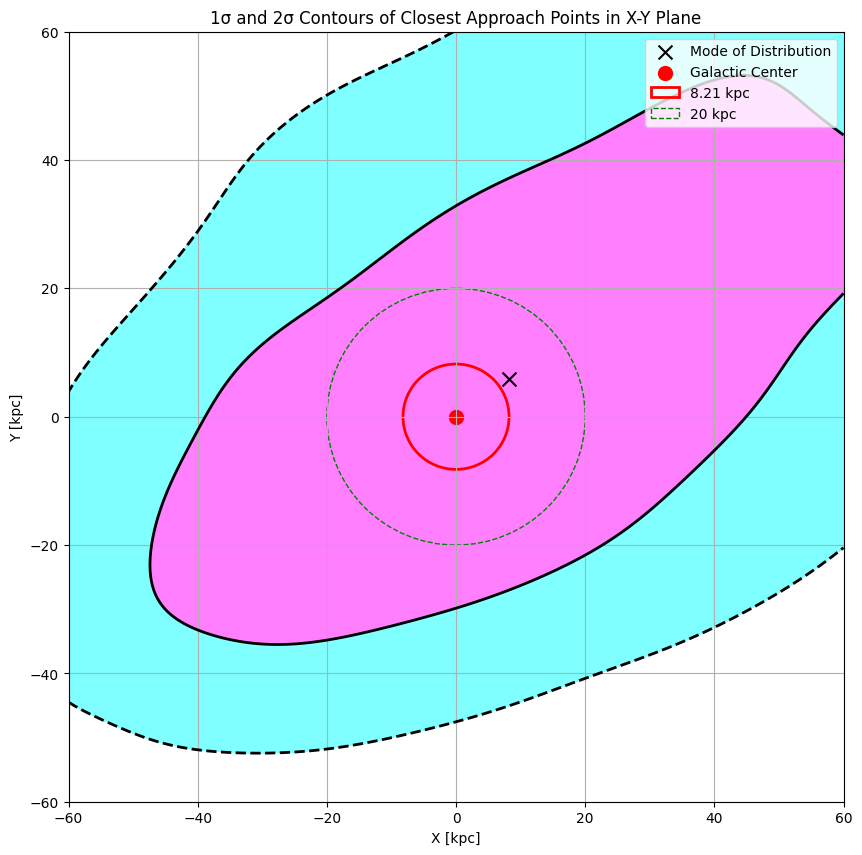

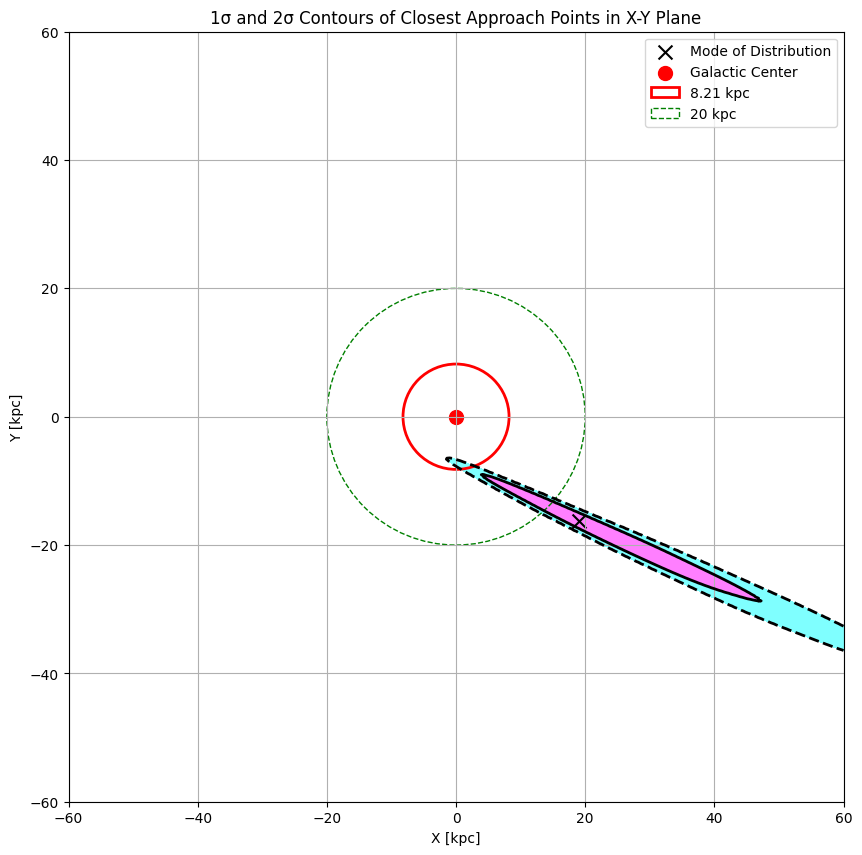

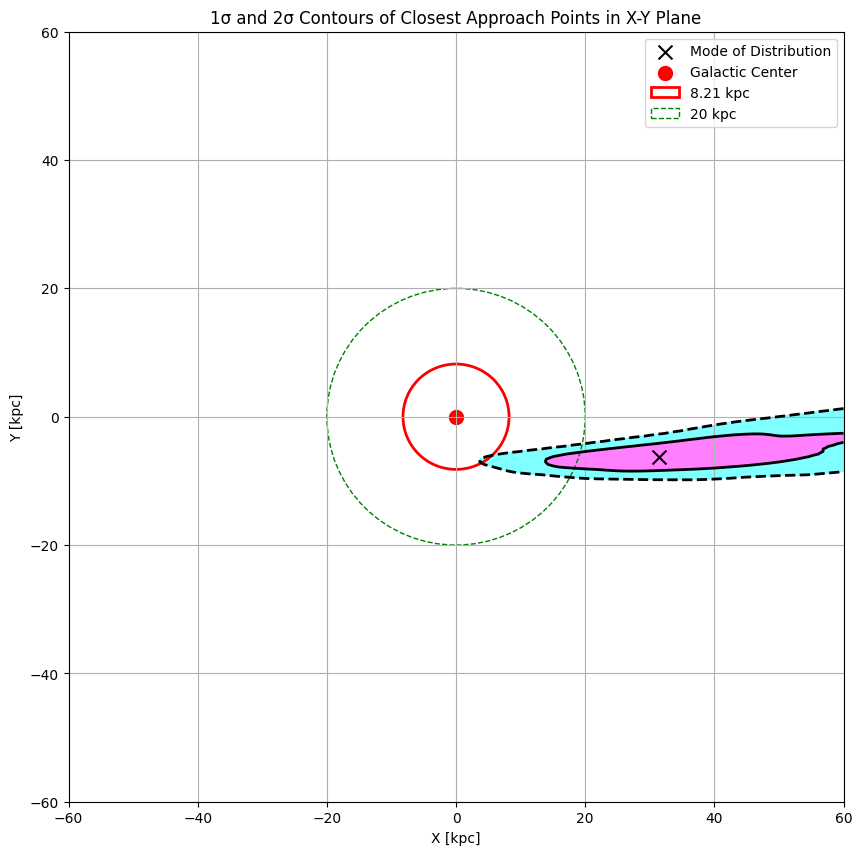

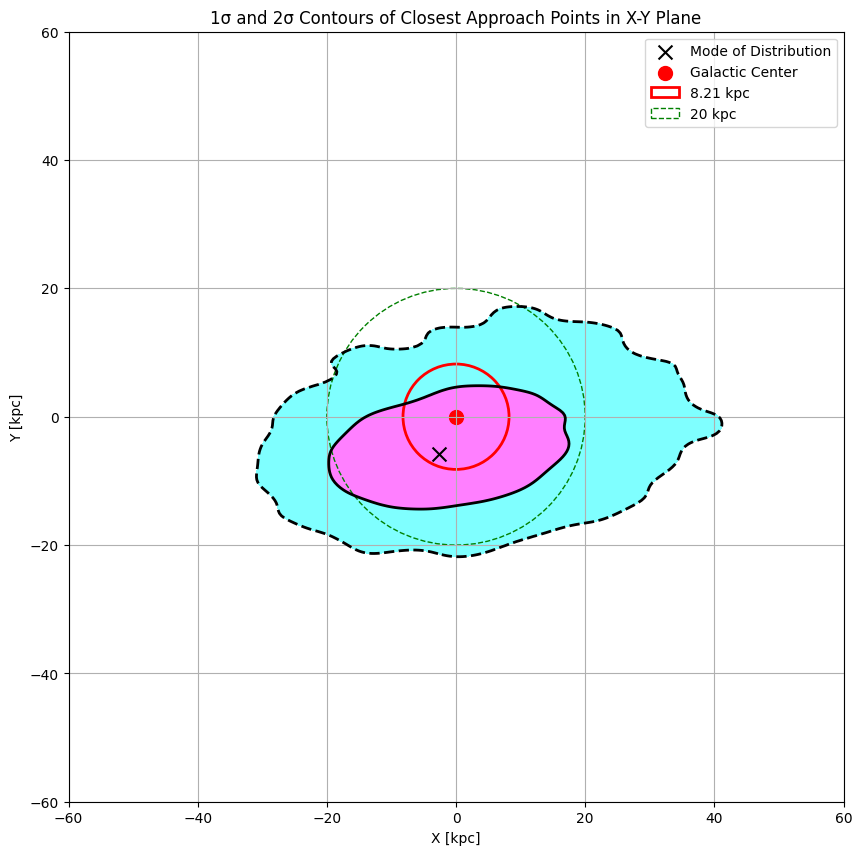

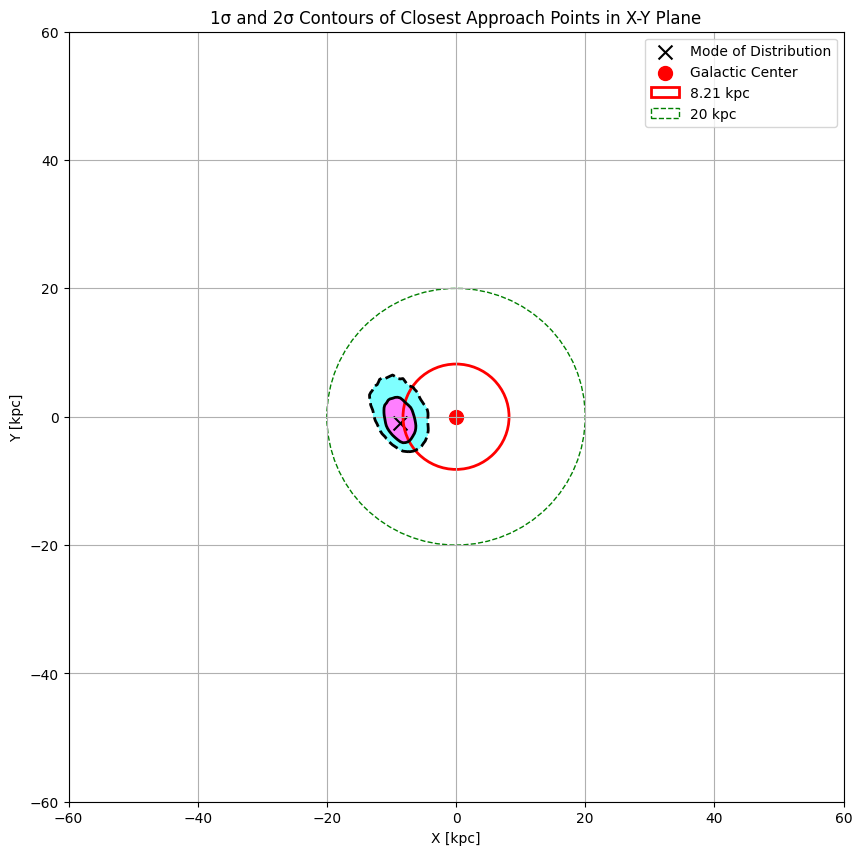

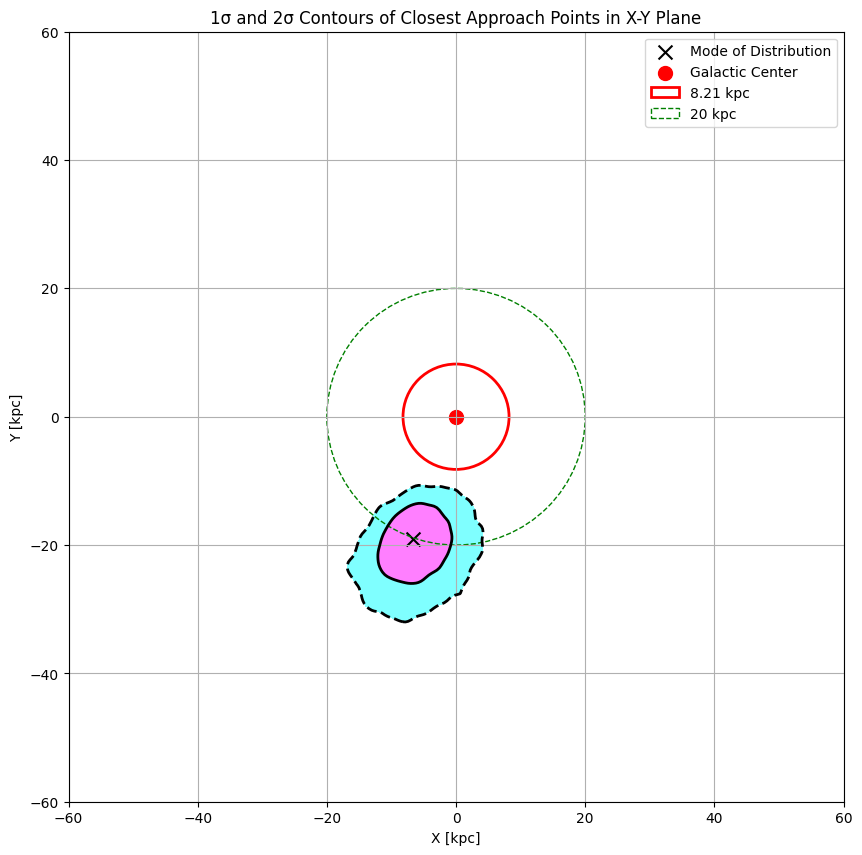

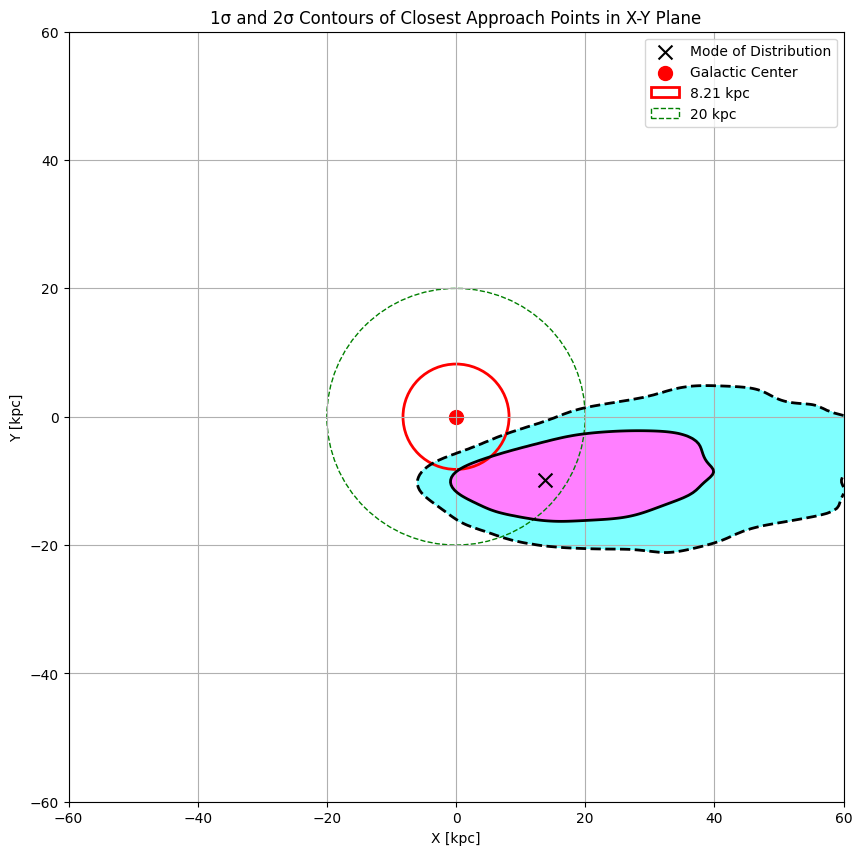

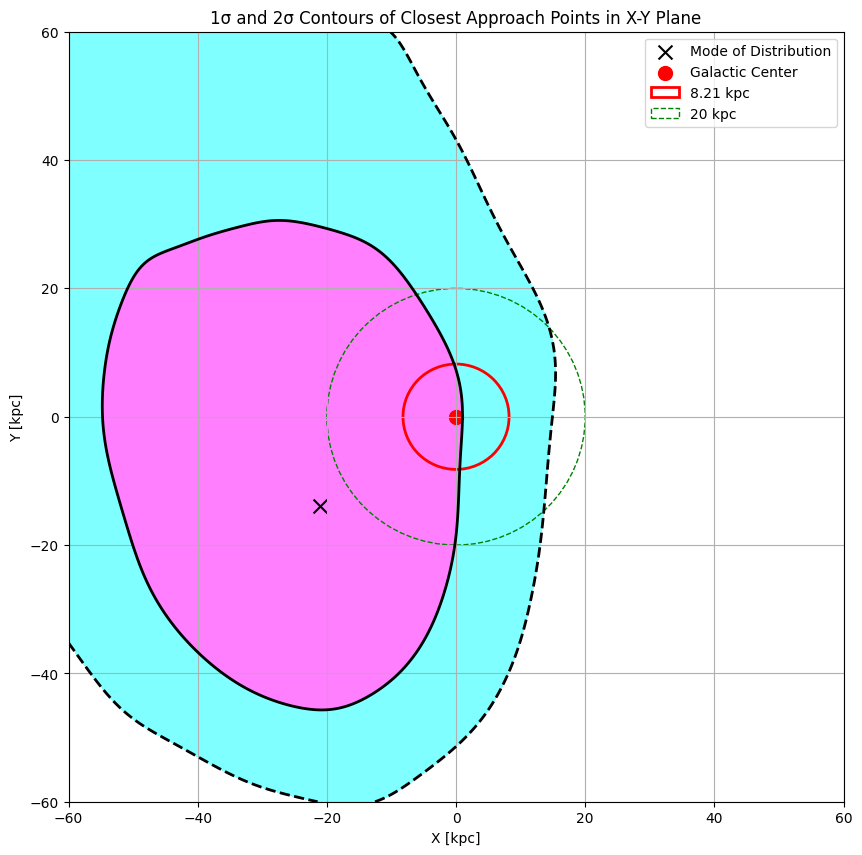

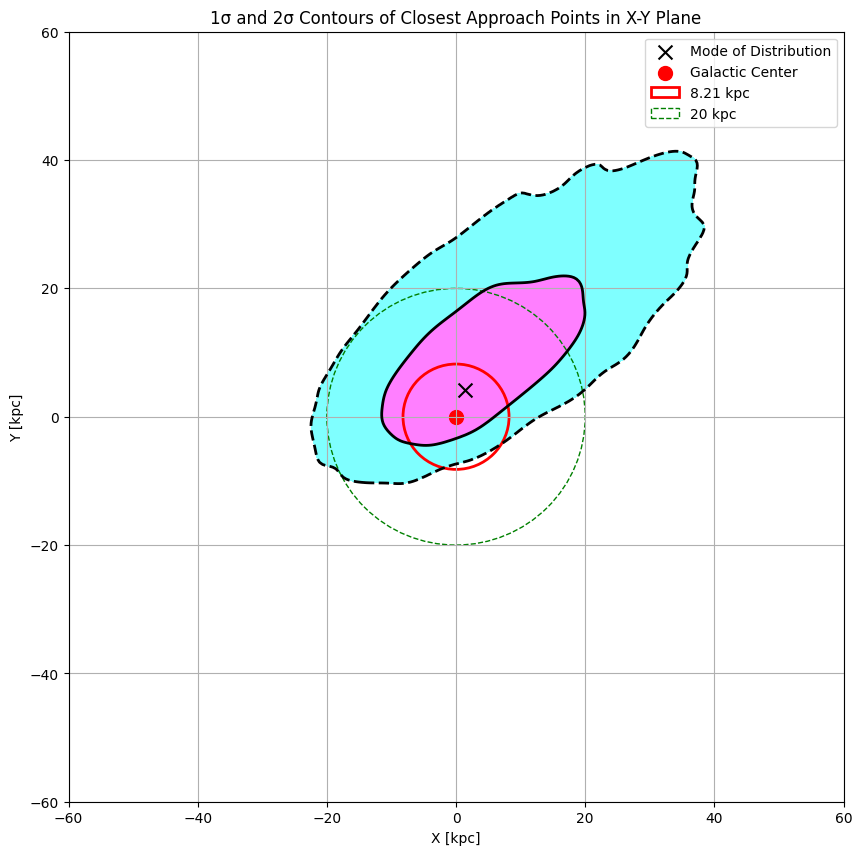

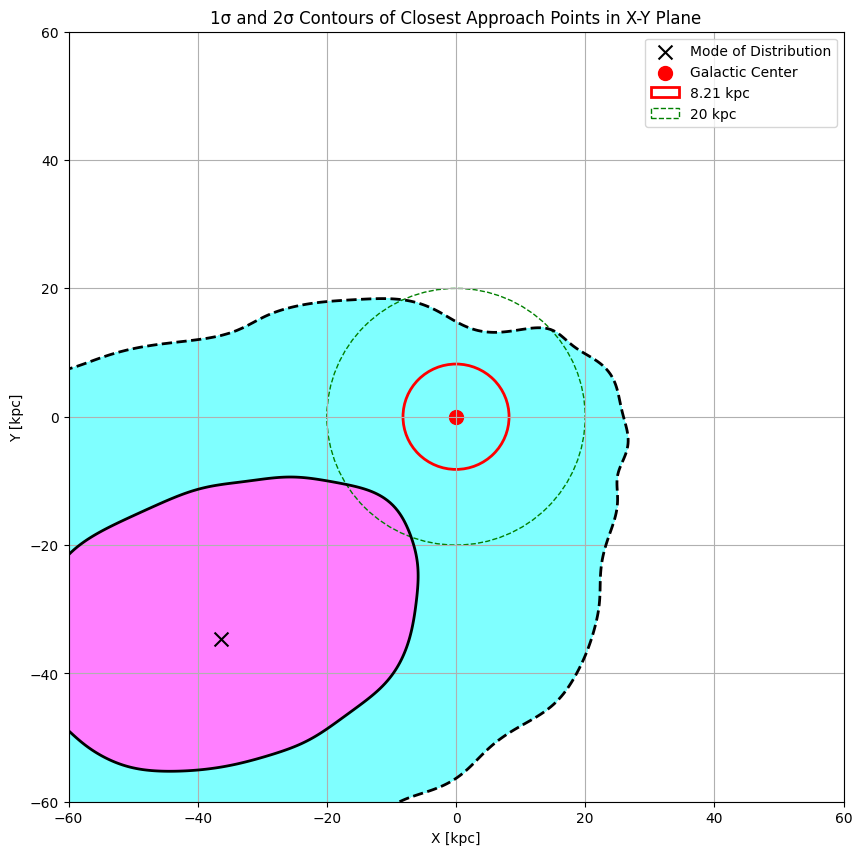

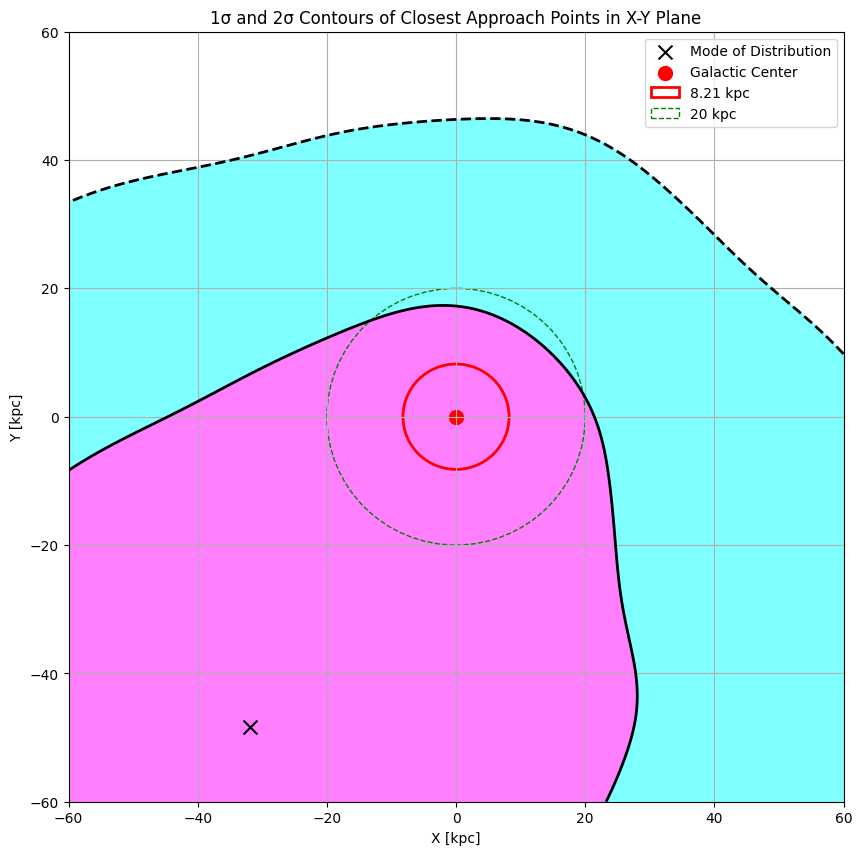

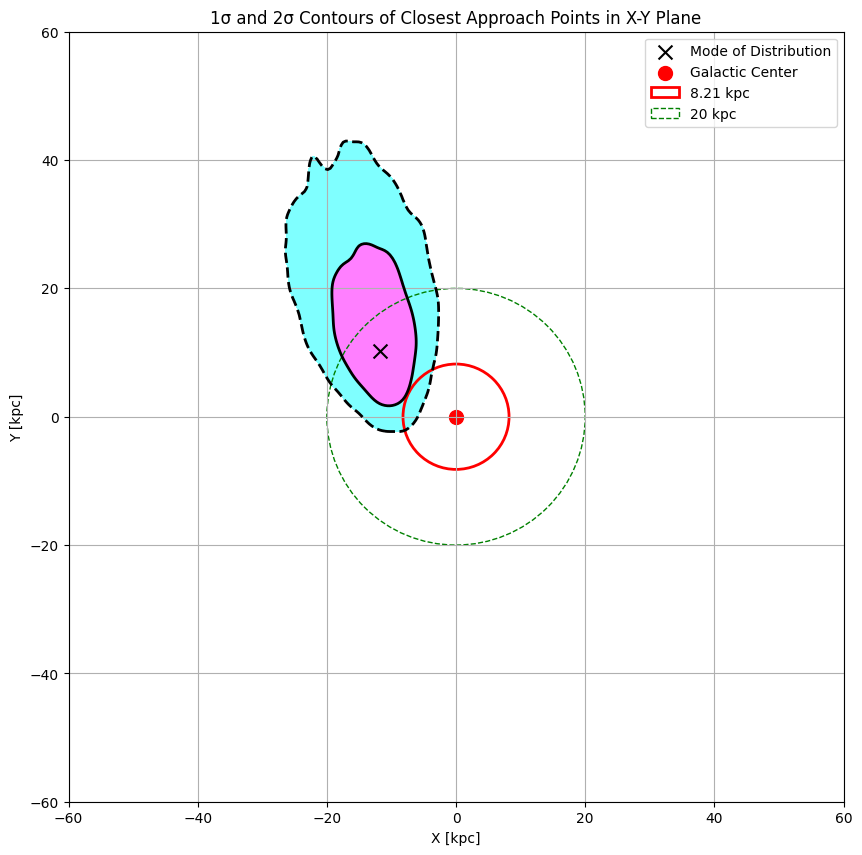

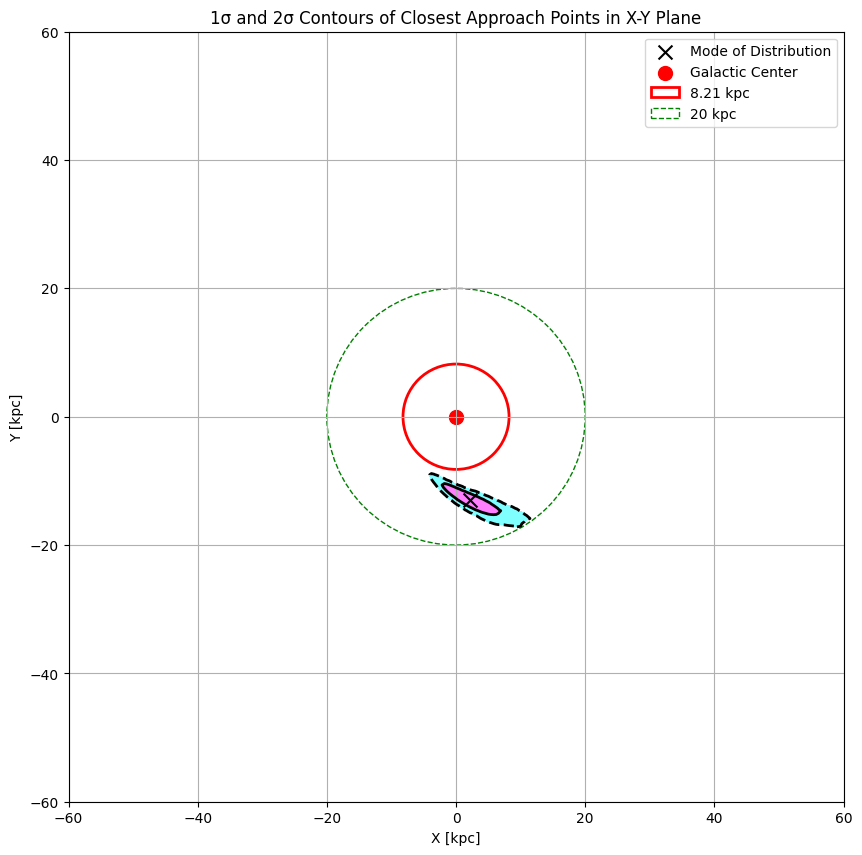

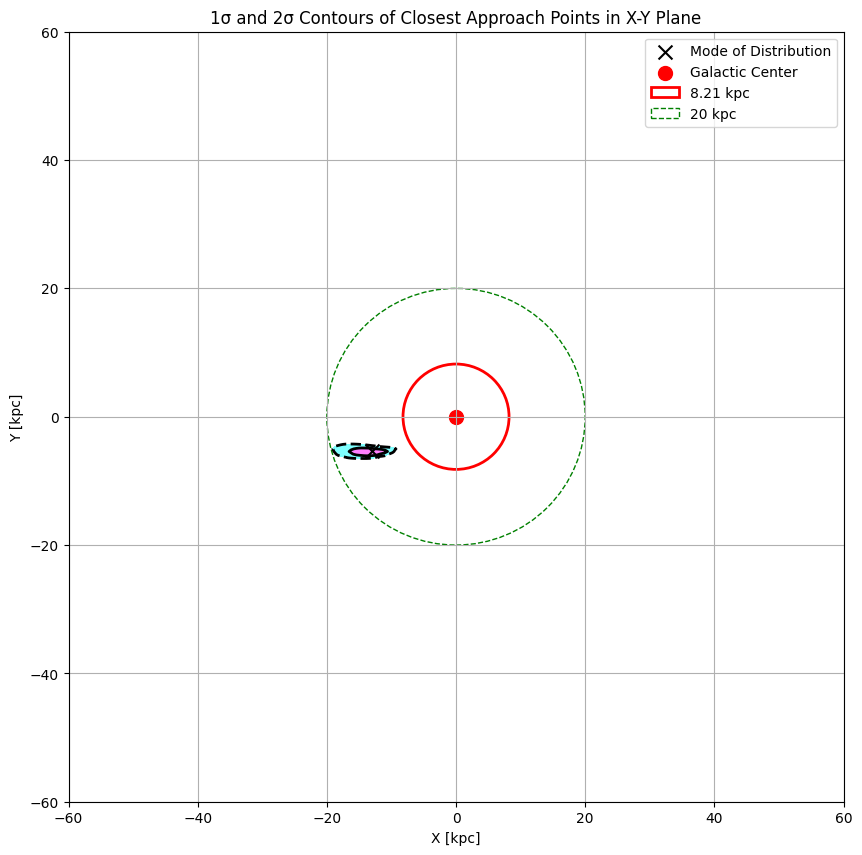

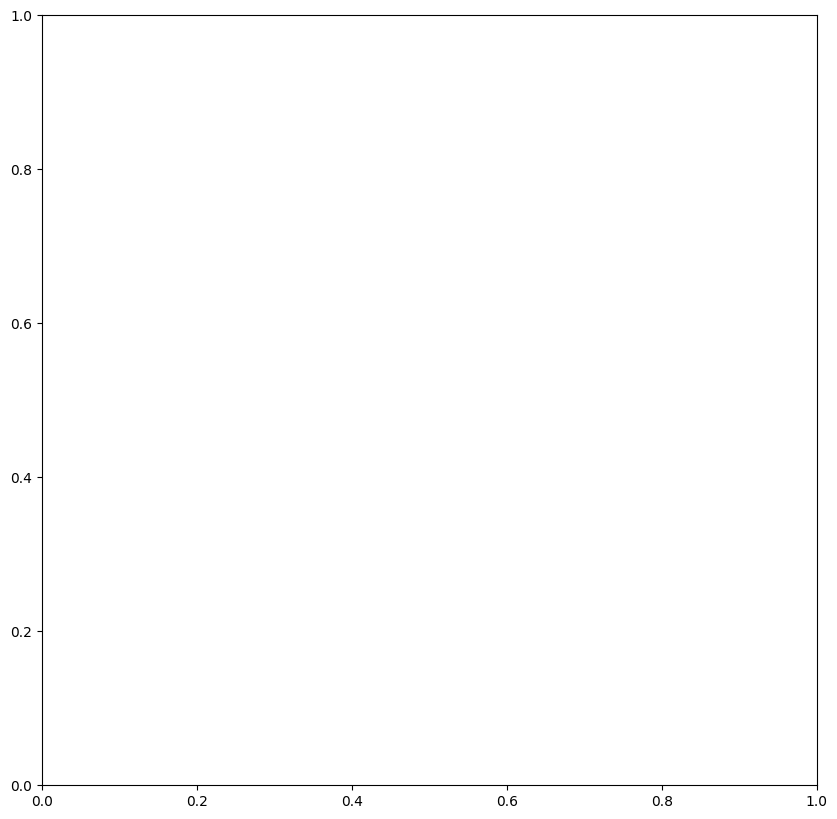

In [ ]:
save_path = 'Plots/brown_stars/mcmillan2017_potential_gaia_dr3_pm'
for i in tqdm(range(len(brown_data))):
    plot_sigma_contours(plane_crossings[i], star_name=brown_data.iloc[[i]].ID.values[0], save_path=save_path, save=True)

# Compute plane crossing positions with HST + Gaia proper motions

## HVS1

In [51]:
# load hvs1 data, this one does not applied a rewind
hvs1 = Table.read('Data/Brown_targets/hvs1_hubblexgaia.fits')
hvs1 = hvs1.to_pandas()
hvs1.rename(columns={'ra_1': 'ra', 'dec_1': 'dec'}, inplace=True)

plane_crossings_hvs1 = oia.integrate_orbits_to_plane_crossing_agama_parallel(hvs1, n_samples=10000,
                                                        integration_time=-0.1,  
                                                        pmra_col='hst_gaia_pmra_median',
                                                        pmdec_col='hst_gaia_pmdec_median',
                                                        pmra_error_col='hst_gaia_pmra_median_error',
                                                        pmdec_error_col='hst_gaia_pmdec_median_error', 
                                                        potential_file='Agama/brown2015.pot')
                                                        

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1079.12it/s]


In [ ]:
hvs1

SOURCE_ID           l          b          ra  ra_error       dec  \
0  577294697514301440  227.335374  31.331994  136.937465  0.450432  2.751909   

   dec_error  parallax  parallax_error      pmra  ...  Mg_error         g0  \
0   0.318181  0.190676        0.580638 -0.603939  ...      0.31  19.690001   

   g0_error d_helio d_helio_error           RA_2           DEC_2         RAx  \
0      23.0   102.0          15.0  b'9:07:44.99'  b'+02:45:06.9'  136.937458   

       DECx  Separation  
0  2.751917     0.03775  

[1 rows x 133 columns]

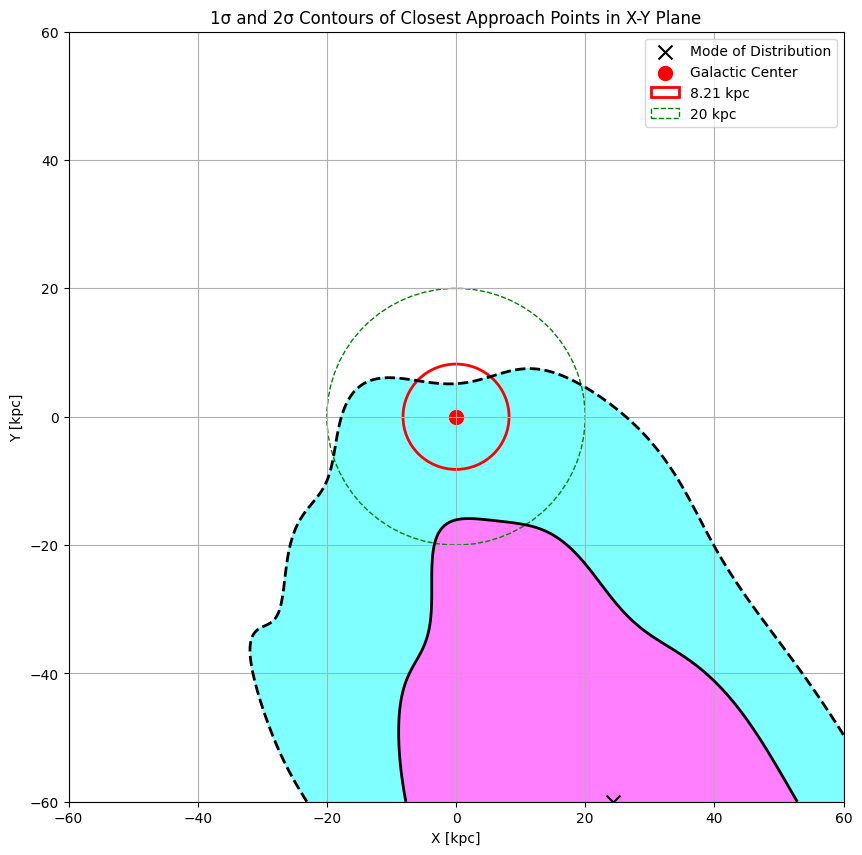

In [53]:
plot_sigma_contours(plane_crossings_hvs1)

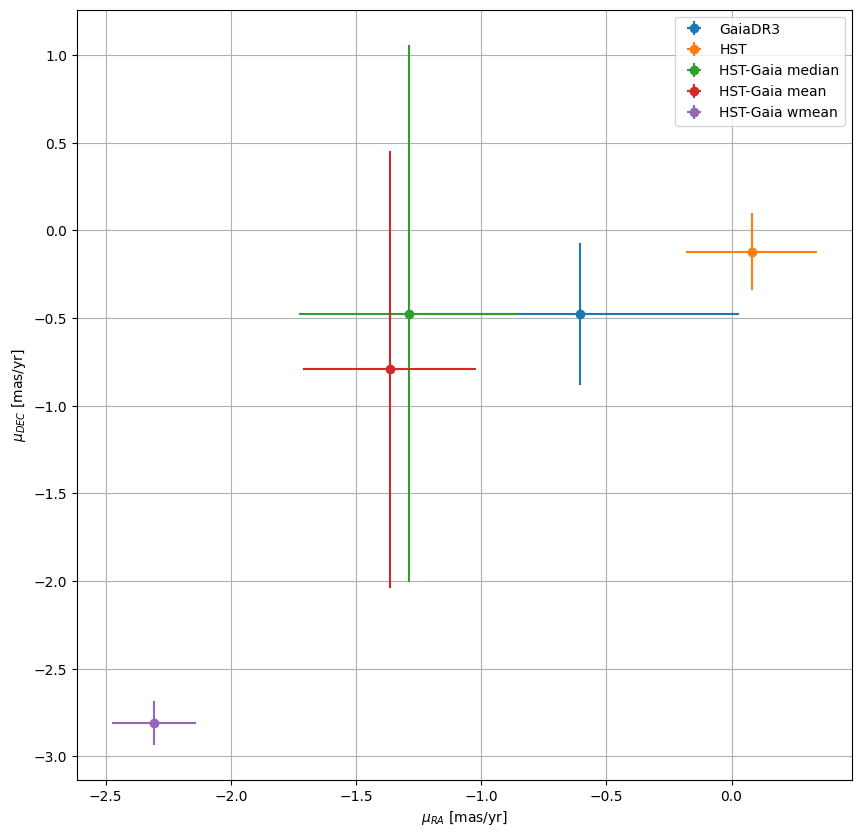

In [32]:
# Lets start by looking at how different are the proper motions from Gaia Hub, HST and GaiaDR3
hvs1_brown = brown_data[brown_data.ID == 'HVS1']
plt.figure(figsize=(10, 10))
plt.errorbar(hvs1.pmra, hvs1.pmdec, xerr=hvs1.pmra_error, yerr=hvs1.pmdec_error, fmt='o', label='GaiaDR3')
plt.errorbar(hvs1_brown.mu_ra, hvs1_brown.mu_dec, xerr=hvs1_brown.mu_ra_error, yerr=hvs1_brown.mu_dec_error, fmt='o', label='HST')

plt.errorbar(hvs1.hst_gaia_pmra_median, hvs1.hst_gaia_pmdec_median, xerr=hvs1.hst_gaia_pmra_median_error, yerr=hvs1.hst_gaia_pmdec_median_error, fmt='o', label='HST-Gaia median')
plt.errorbar(hvs1.hst_gaia_pmra_mean, hvs1.hst_gaia_pmdec_mean, xerr=hvs1.hst_gaia_pmra_mean_error, yerr=hvs1.hst_gaia_pmdec_mean_error, fmt='o', label='HST-Gaia mean')
plt.errorbar(hvs1.hst_gaia_pmra_wmean, hvs1.hst_gaia_pmdec_wmean, xerr=hvs1.hst_gaia_pmra_wmean_error, yerr=hvs1.hst_gaia_pmdec_wmean_error, fmt='o', label='HST-Gaia wmean')

plt.xlabel('$\mu_{RA}$ [mas/yr]')
plt.ylabel('$\mu_{DEC}$ [mas/yr]')
plt.legend()
plt.grid(True)
plt.show()

## HVS1 with McMillan

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1128.26it/s]


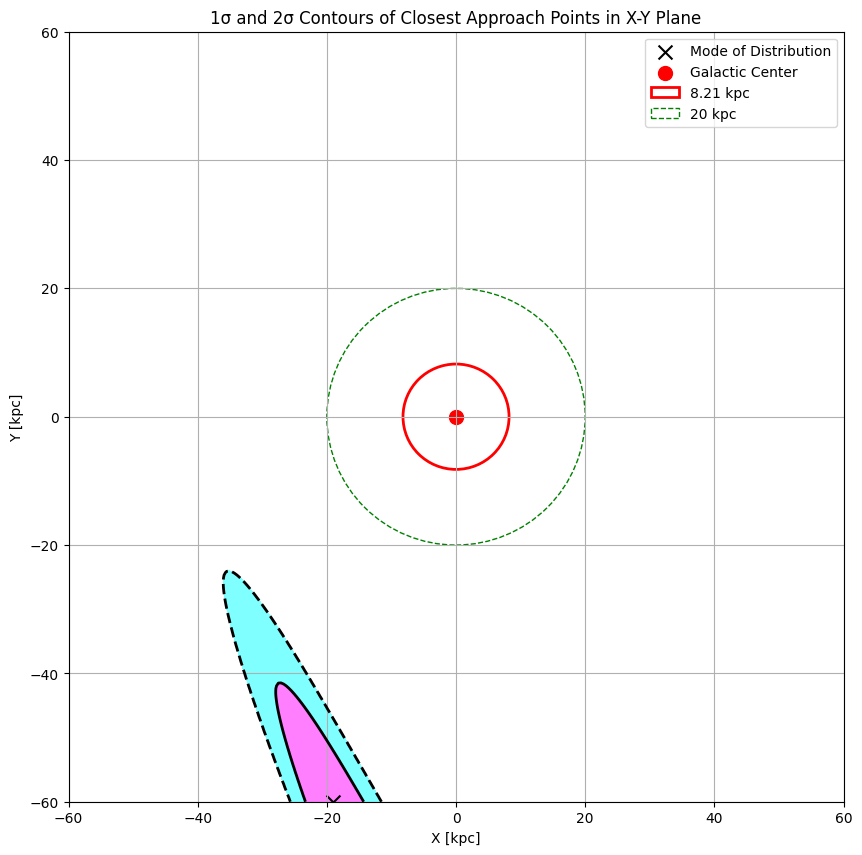

In [54]:
# load hvs1 data, this one does not applied a rewind
hvs1 = Table.read('Data/Brown_targets/hvs1_hubblexgaia.fits')
hvs1 = hvs1.to_pandas()
hvs1.rename(columns={'ra_1': 'ra', 'dec_1': 'dec'}, inplace=True)

plane_crossings_hvs1 = oia.integrate_orbits_to_plane_crossing_agama_parallel(hvs1, n_samples=10000,
                                                        integration_time=-0.05,  
                                                        pmra_col='hst_gaia_pmra_median',
                                                        pmdec_col='hst_gaia_pmdec_median',
                                                        pmra_error_col='hst_gaia_pmra_median_error',
                                                        pmdec_error_col='hst_gaia_pmdec_median_error', 
                                                        potential_file='Agama/McMillan2011.pot')
plot_sigma_contours(plane_crossings_hvs1)
                                                        

## HVS4

In [15]:
# load data for HVS 4
# load data 
hvs4 = Table.read('Data/Brown_targets/hvs4_hubblexgaia_rewind.fits')
hvs4 = hvs4.to_pandas()
hvs4.rename(columns={'ra_1': 'ra', 'dec_1': 'dec'}, inplace=True)

In [30]:
plane_crossings_hvs4 = oia.integrate_orbits_to_plane_crossing_agama_parallel(hvs4, n_samples=10000,
                                                        integration_time=-0.3,  
                                                        pmra_col='hst_gaia_pmra_wmean',
                                                        pmdec_col='hst_gaia_pmdec_wmean',
                                                        pmra_error_col='hst_gaia_pmra_wmean_error',
                                                        pmdec_error_col='hst_gaia_pmdec_wmean_error', 
                                                        potential_file='Agama/brown2015.pot')
                                                        

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 965.18it/s]


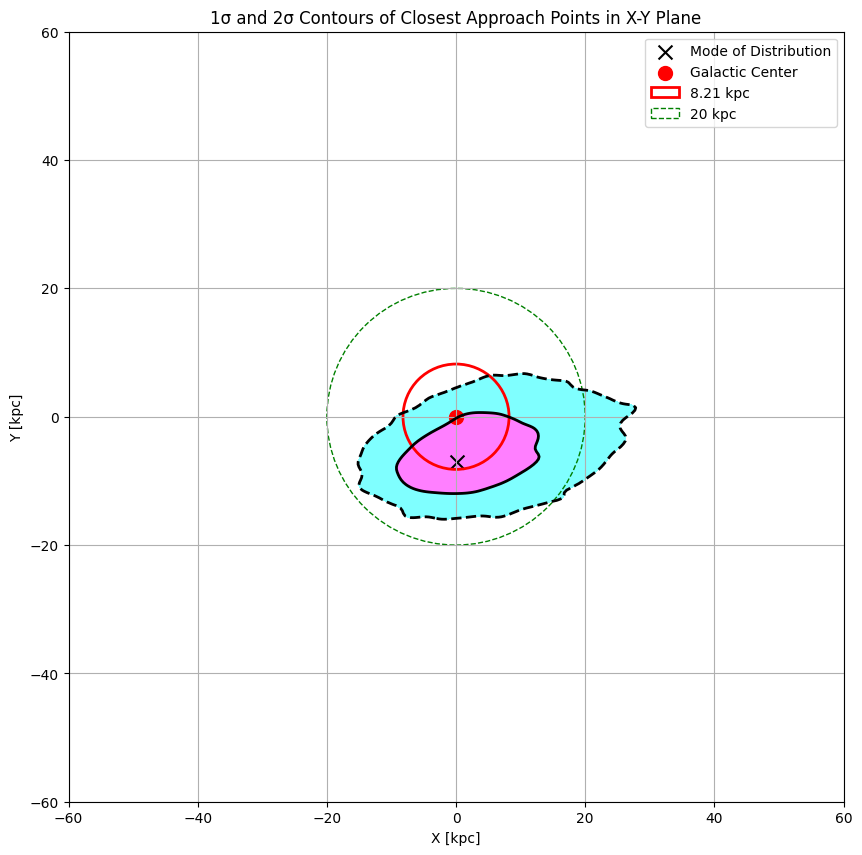

In [31]:
plot_sigma_contours(plane_crossings_hvs4)

## HVS4 with McMillan

In [18]:
plane_crossings_hvs4 = oia.integrate_orbits_to_plane_crossing_agama_parallel(hvs4, n_samples=10000,
                                                        integration_time=-0.3,  
                                                        pmra_col='hst_gaia_pmra_wmean',
                                                        pmdec_col='hst_gaia_pmdec_wmean',
                                                        pmra_error_col='hst_gaia_pmra_wmean_error',
                                                        pmdec_error_col='hst_gaia_pmdec_wmean_error', 
                                                        potential_file='Agama/McMillan2011.pot')
                                                        

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1146.97it/s]


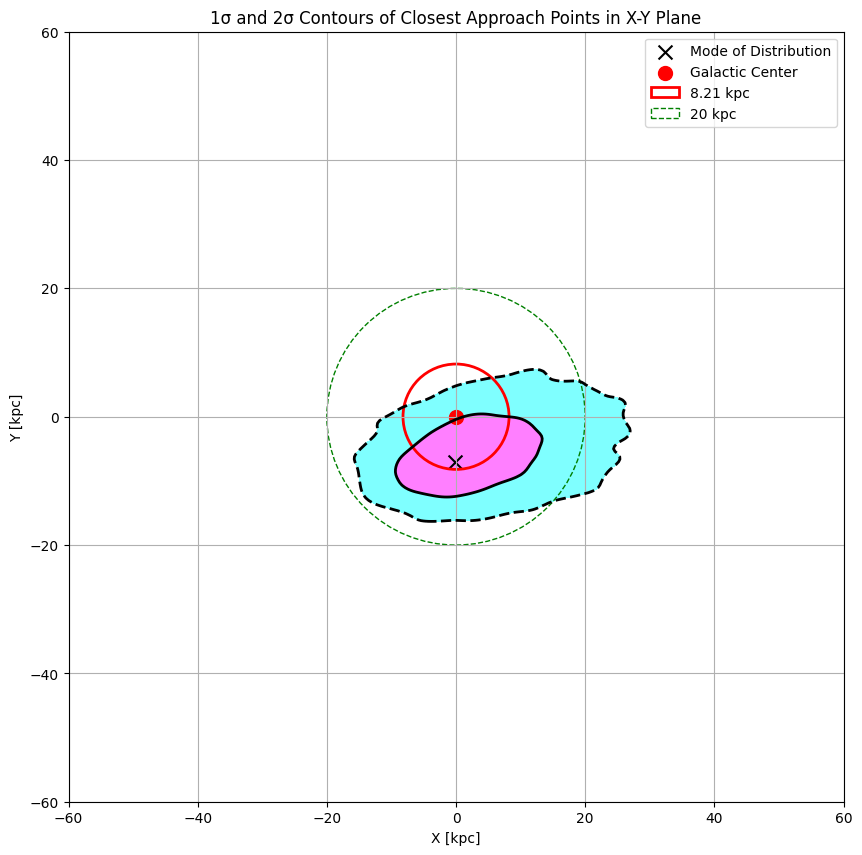

In [19]:
plot_sigma_contours(plane_crossings_hvs4)

## HVS2

In [20]:

# load data for HVS 4
# load data 
def origin_hvs_hst(file_path):
    hvs = Table.read(file_path)
    hvs = hvs.to_pandas()
    hvs.rename(columns={'ra_1': 'ra', 'dec_1': 'dec'}, inplace=True)
    plane_crossings_hvs = oia.integrate_orbits_to_plane_crossing_agama_parallel(hvs, n_samples=10000,
                                                        integration_time=-0.3,  
                                                        pmra_col='hst_gaia_pmra_wmean',
                                                        pmdec_col='hst_gaia_pmdec_wmean',
                                                        pmra_error_col='hst_gaia_pmra_wmean_error',
                                                        pmdec_error_col='hst_gaia_pmdec_wmean_error', 
                                                        potential_file='Agama/brown2015.pot')
    
    plot_sigma_contours(plane_crossings_hvs)


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [18:12<00:00,  9.15it/s]


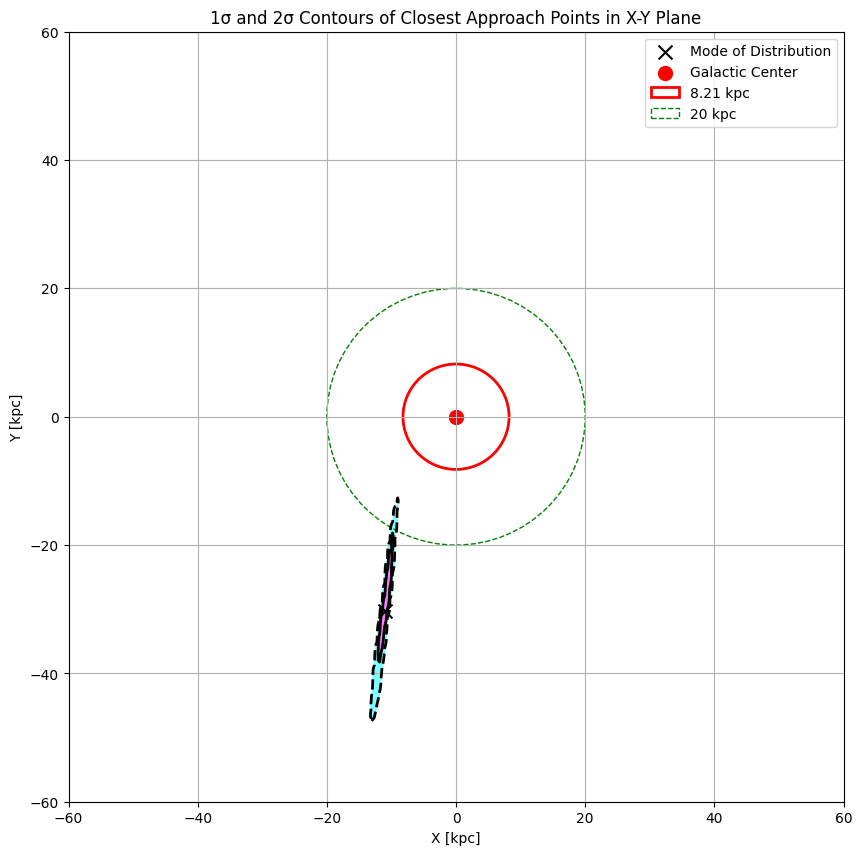

In [21]:
hvs2_file_path = 'Data/Brown_targets/hvs2_hubblexgaia.fits'
origin_hvs_hst(hvs2_file_path)

# S5 HVS1

In [6]:
s5_hvs1 = Table.read('Data/Gaia_tests/s5hvs1-result.fits')
s5_hvs1 = s5_hvs1.to_pandas()

In [19]:
# convert distance from log10(dist/1kpc) to kpc
s5_hvs1_logdist = 0.936
s5_hvs1_logdist_error = 0.015
s5_hvs1['dist_error'] = (10**(s5_hvs1_logdist + s5_hvs1_logdist_error) - 10**(s5_hvs1_logdist))
s5_hvs1['dist'] = 10**(s5_hvs1_logdist)

# add heliocentric velocity
s5_hvs1['v_helio'] = 1017
s5_hvs1['v_helio_error'] = 2.7


In [20]:
plane_crossings_s5_hvs1 = oia.integrate_orbits_to_plane_crossing_agama_parallel(s5_hvs1, n_samples=10000,
                                                        integration_time=-0.2,  
                                                        pmra_col='pmra',
                                                        pmdec_col='pmdec',
                                                        pmra_error_col='pmra_error',
                                                        pmdec_error_col='pmdec_error',
                                                        d_col='dist',
                                                        d_col_error='dist_error',
                                                        potential_file='Agama/McMillan2011.pot')
                                                        

100%|███████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1111.85it/s]


In [10]:
# Turn plane crossings from list of tuples to two lists to save into a dataframe
# Extract X, Y positions
x = np.array([origin[0] for origin in plane_crossings_s5_hvs1])
y = np.array([origin[1] for origin in plane_crossings_s5_hvs1])

# Save into astropy Table
#s5_hvs1_plane_crossings = Table([x, y], names=('X', 'Y'))
#s5_hvs1_plane_crossings.write('Data/orbits/plane_crossings/s5_hvs1_plane_crossings.fits', overwrite=True)


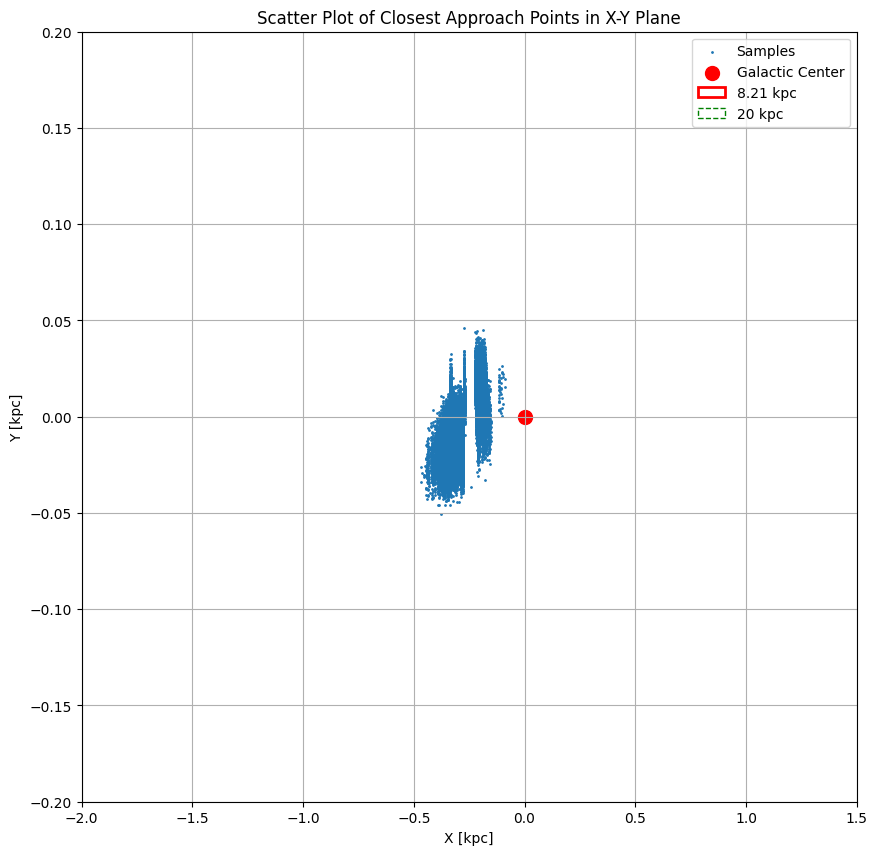

In [16]:
scatter_plot_origin(plane_crossings_s5_hvs1, xlim=(-2, 1.5), ylim=(-0.2, 0.2))

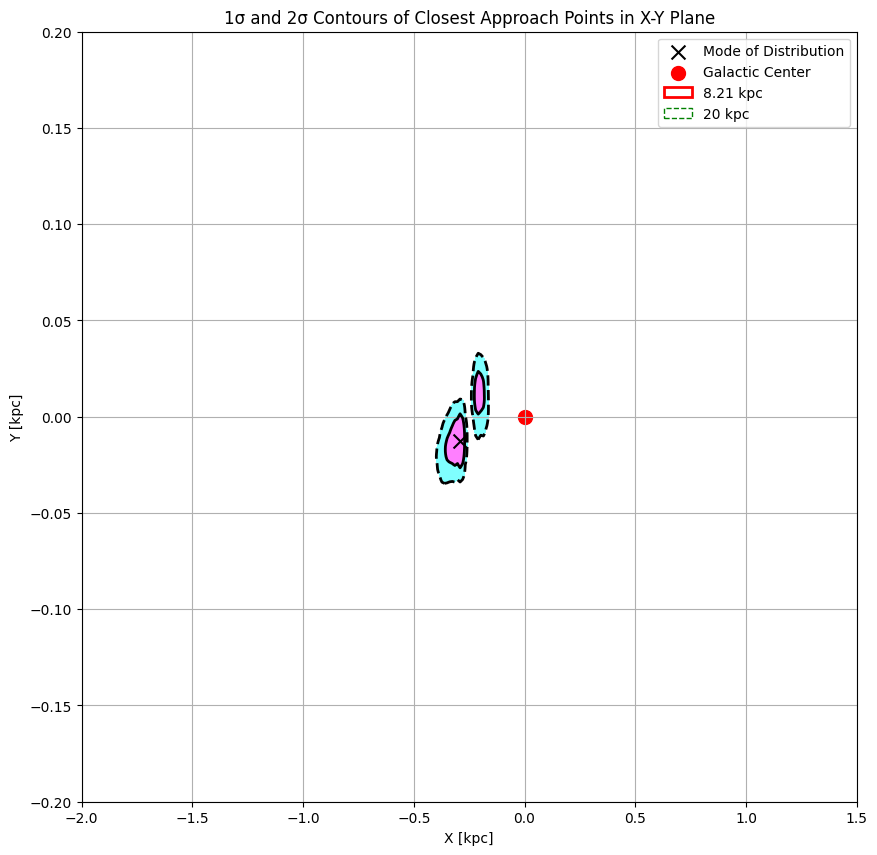

In [17]:
plot_sigma_contours(plane_crossings_s5_hvs1, xlim=(-2, 1.5), ylim=(-0.2, 0.2))

# Sill candidates

In [6]:
import numpy as np

def parallax_to_distance_array(parallax, parallax_error):
    """
    Convert parallax to distance and calculate average distance error for arrays.
    Returns NaN for distances and errors where parallax is <= 0.
    
    Parameters:
        parallax (array-like): Parallax in milliarcseconds (mas).
        parallax_error (array-like): Parallax error in milliarcseconds (mas).
    
    Returns:
        distance (numpy.ndarray): Distances in kiloparsecs (kpc).
        distance_error (numpy.ndarray): Average distance errors in kiloparsecs (kpc).
    """
    parallax = np.array(parallax, dtype=float)
    parallax_error = np.array(parallax_error, dtype=float)
    
    # Initialize outputs as NaN
    distance = np.full_like(parallax, np.nan)
    distance_error = np.full_like(parallax, np.nan)
    
    # Valid parallax values (parallax > 0)
    valid = parallax > 0
    
    # Calculate distances and errors only for valid parallax values
    distance[valid] = 1.0 / parallax[valid]
    distance_plus_error = np.where(valid, 1.0 / (parallax[valid] - parallax_error[valid]), np.inf)
    distance_minus_error = np.where(valid, 1.0 / (parallax[valid] + parallax_error[valid]), np.nan)
    
    # Calculate average distance error for valid values
    distance_error[valid] = (np.abs(distance_plus_error - distance[valid]) + 
                             np.abs(distance_minus_error - distance[valid])) / 2.0
    
    return distance, distance_error

# Example usage:
parallax = [0.5, 0.0, -0.1, 1.0, 2.0]  # mas


In [7]:
sill_stars = Table.read('Data/Sill Candidates/Sill_candidates_gaia_radial.fits')
# remove stars with negative parallax
sill_stars = sill_stars[sill_stars['parallax'] > 0]
sill_stars = sill_stars.to_pandas()


# compute distance and distance error from parallax
# sill_stars['helio_dist'] = np.abs(1/sill_stars.parallax) # distance in kpc since parallax is in mas
# sill_stars['helio_dist_error'] = np.abs(1/(sill_stars.parallax + sill_stars.parallax_error) - 1/(sill_stars.parallax - sill_stars.parallax_error))/1000
sill_stars['d_helio'], sill_stars['d_helio_error'] = parallax_to_distance_array(sill_stars.parallax, sill_stars.parallax_error)


# select only stars with positive parallax
#sill_stars = sill_stars.loc[sill_stars['dist'] > 0]

# #remove stars with distance <= 0
sill_stars = sill_stars.loc[sill_stars['d_helio'] > 0.1]
print(min(sill_stars.d_helio))
print(max(sill_stars.d_helio))


# drop nans in the coordinates required for orbit integration
sill_stars = sill_stars.dropna(subset=['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'parallax_error', 'pmra_error', 'pmdec_error', 'Vr_1', 'Vr_err', 'd_helio', 'd_helio_error'])
# # remove stars with distance beyond 200 kpc
# sill_stars = sill_stars.loc[sill_stars['helio_dist'] < 200000]





#print(min(sill_stars.dist))
df_fails = pd.DataFrame()
# compute orbits for all brown stars using HST proper motions, this should give the exact same contours as Figure 4 in the paper
plane_crossings = []
for i in range(len(sill_stars)):
    star = sill_stars.iloc[[i]]
    try:
        plane_crossings.append(oia.integrate_orbits_to_plane_crossing_agama_parallel(star, n_samples=10000,
                                                            integration_time=-0.3,  
                                                            pmra_col='pmra',
                                                            pmdec_col='pmdec',
                                                            pmra_error_col='pmra_error',
                                                            pmdec_error_col='pmdec_error',
                                                            v_col='Vr_1',
                                                            v_col_error='Vr_err',
                                                            d_col='d_helio',
                                                            d_col_error='d_helio_error',
                                                            potential_file='Agama/brown2015.pot'))
    except ValueError as e:
        print(f"ValueError during orbit integration: {e}")
        df_fails = pd.concat([df_fails, star])
        continue


1.7551866019261748
1011.1839652038913


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1441.62it/s]


3517385736465747456
35    317.5
Name: Vr_1, dtype: float32
True


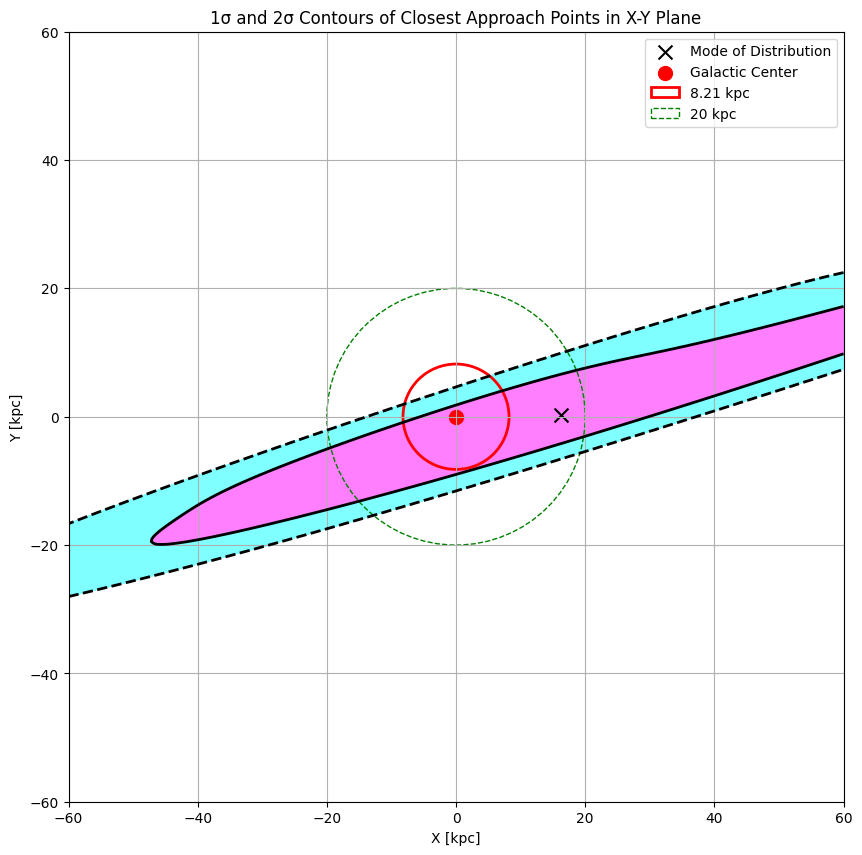

4842148023592665600
36    362.5
Name: Vr_1, dtype: float32
False


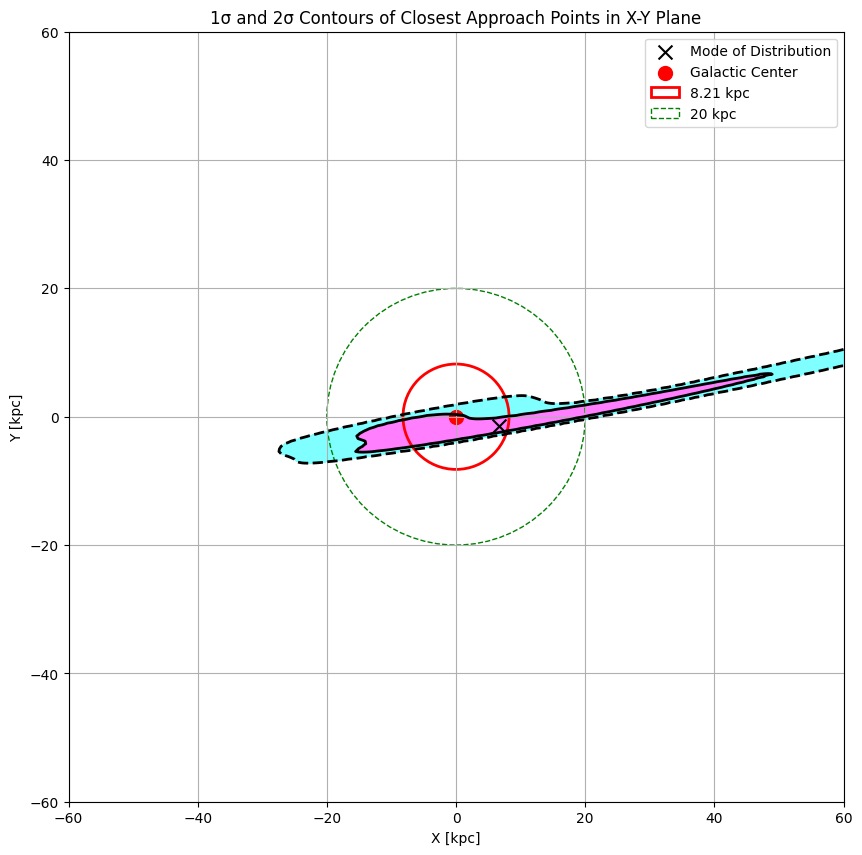

5280863024321039872
41    351.100006
Name: Vr_1, dtype: float32
True


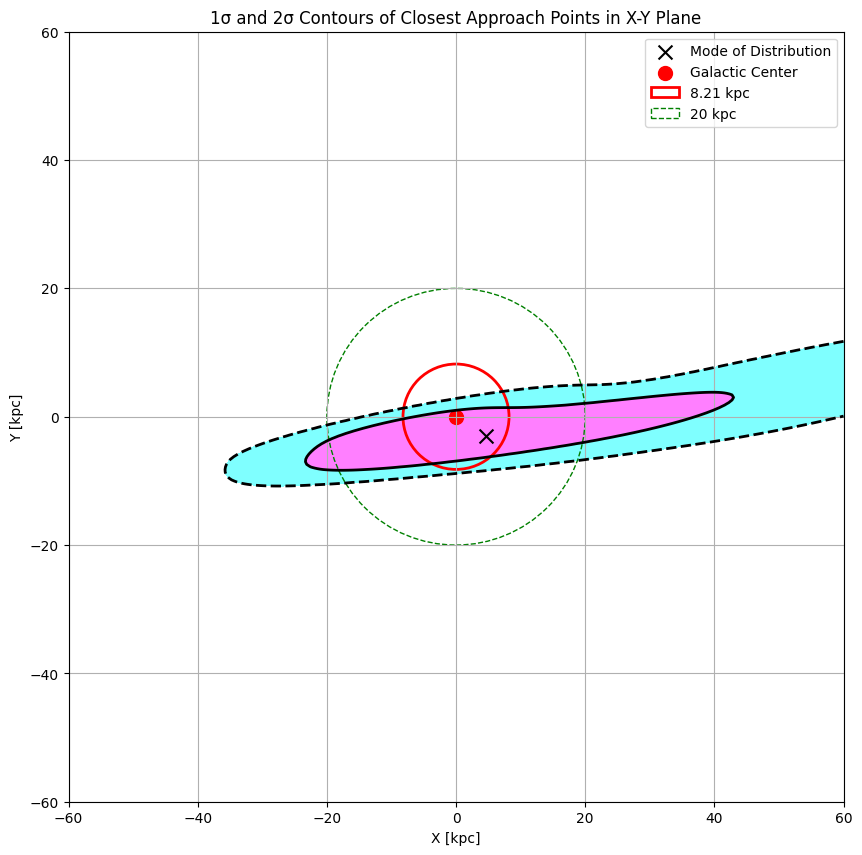

3509202552456394368
45    371.399994
Name: Vr_1, dtype: float32
True


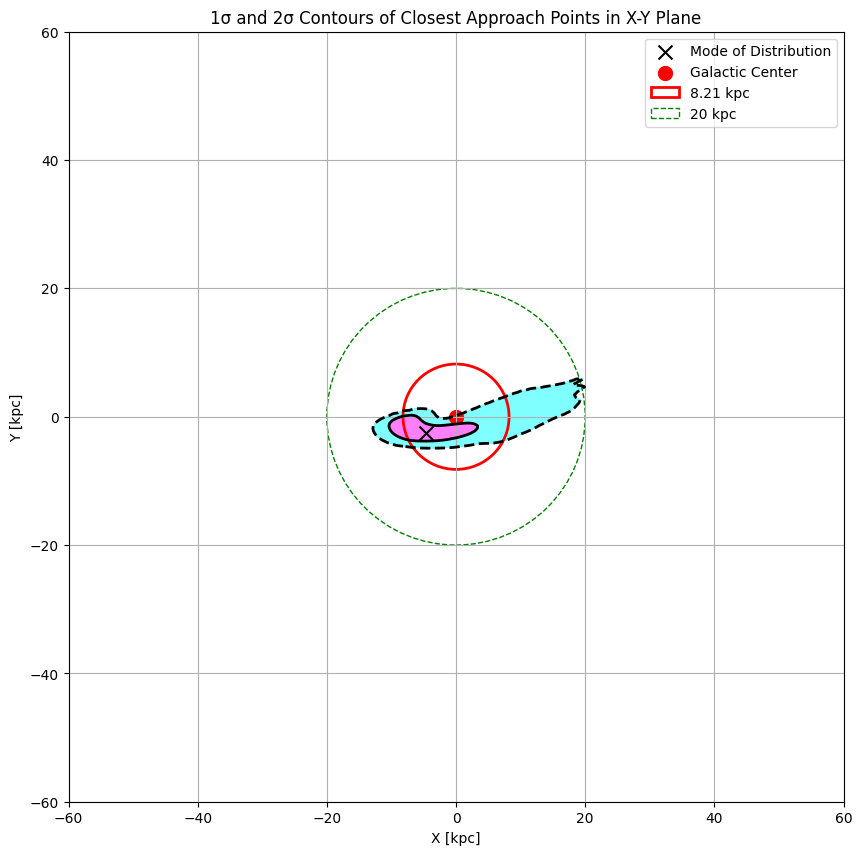

5486643046433857920
50    425.799988
Name: Vr_1, dtype: float32
False


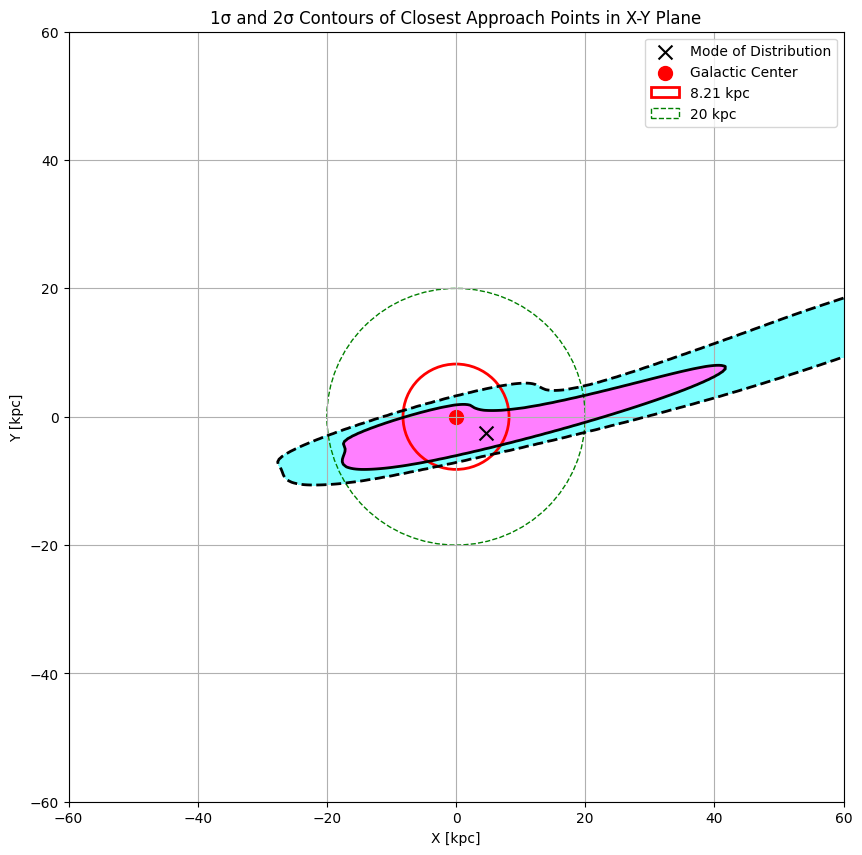

3489258270522883968
51    326.0
Name: Vr_1, dtype: float32
True


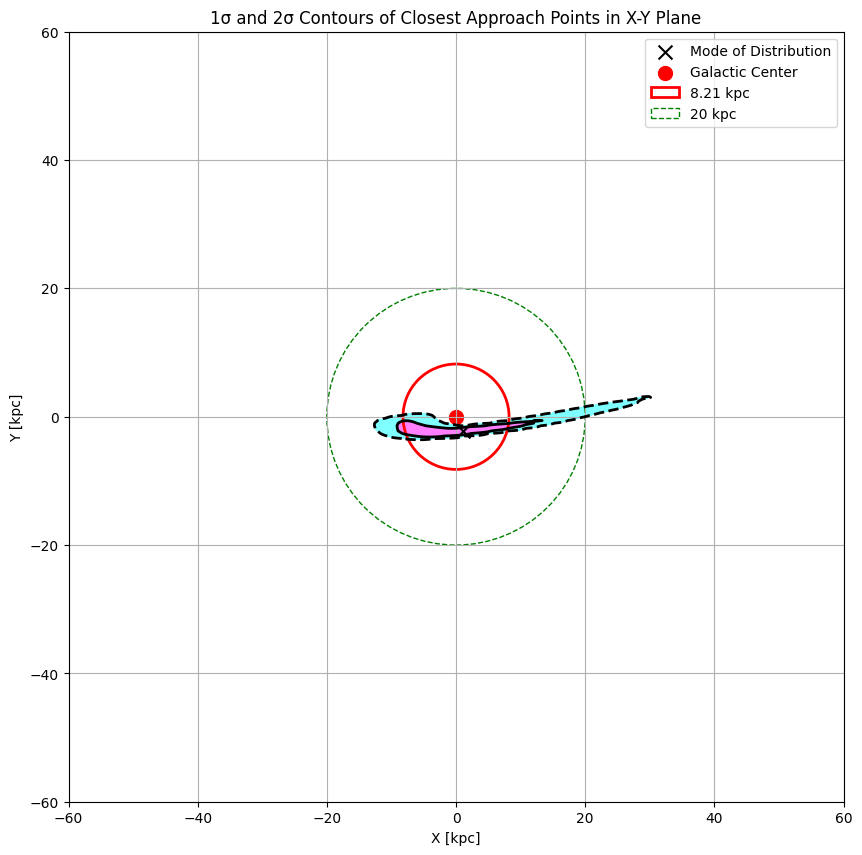

6412888099986311424
75    349.5
Name: Vr_1, dtype: float32
True


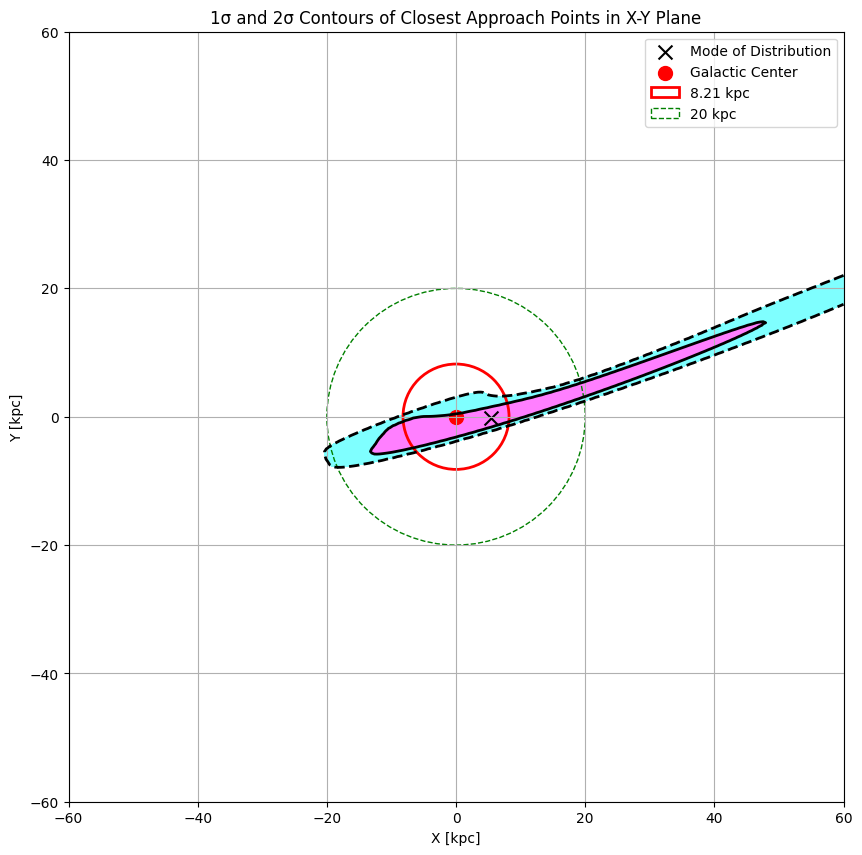

6409893923665251200
79    360.700012
Name: Vr_1, dtype: float32
True


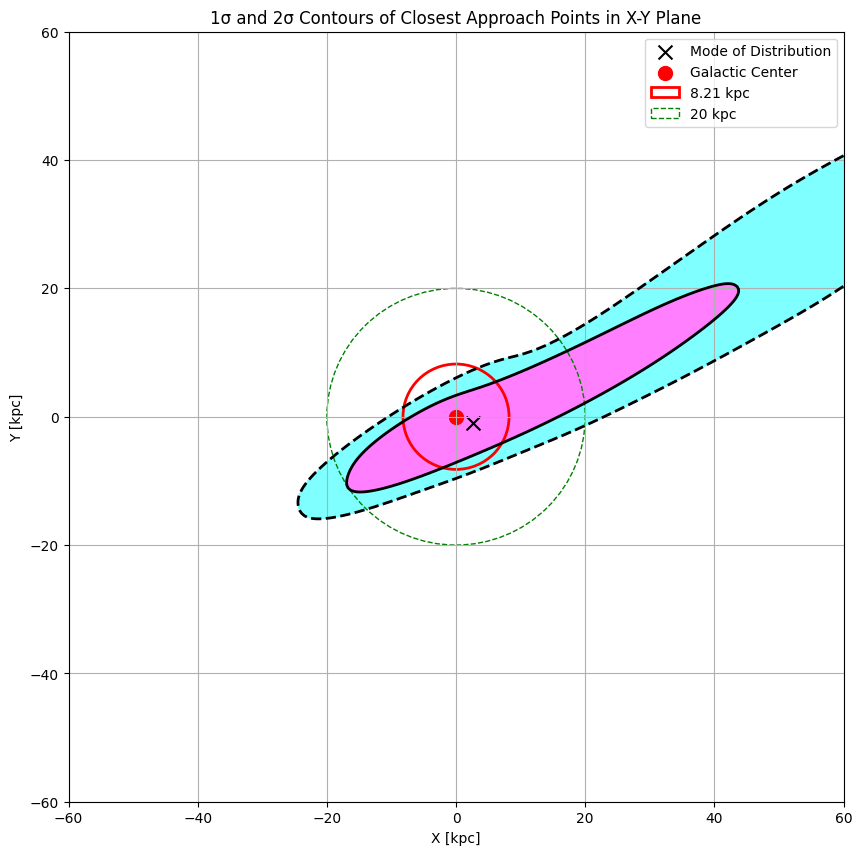

6402416115022000384
89    406.299988
Name: Vr_1, dtype: float32
False


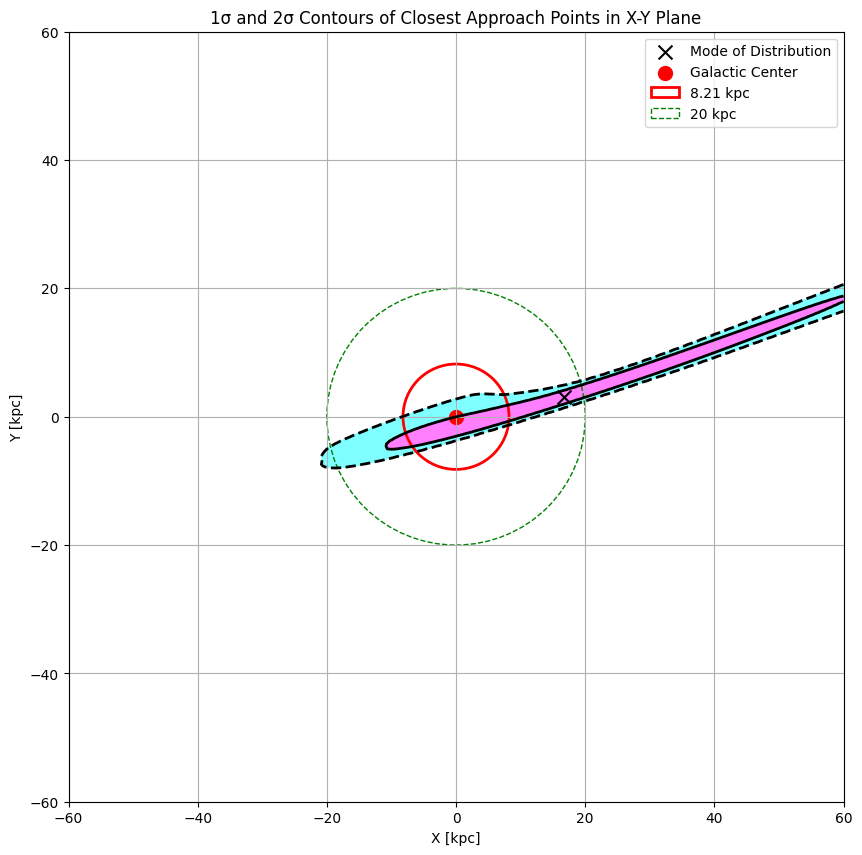

5477480717256679680
103    510.0
Name: Vr_1, dtype: float32
True


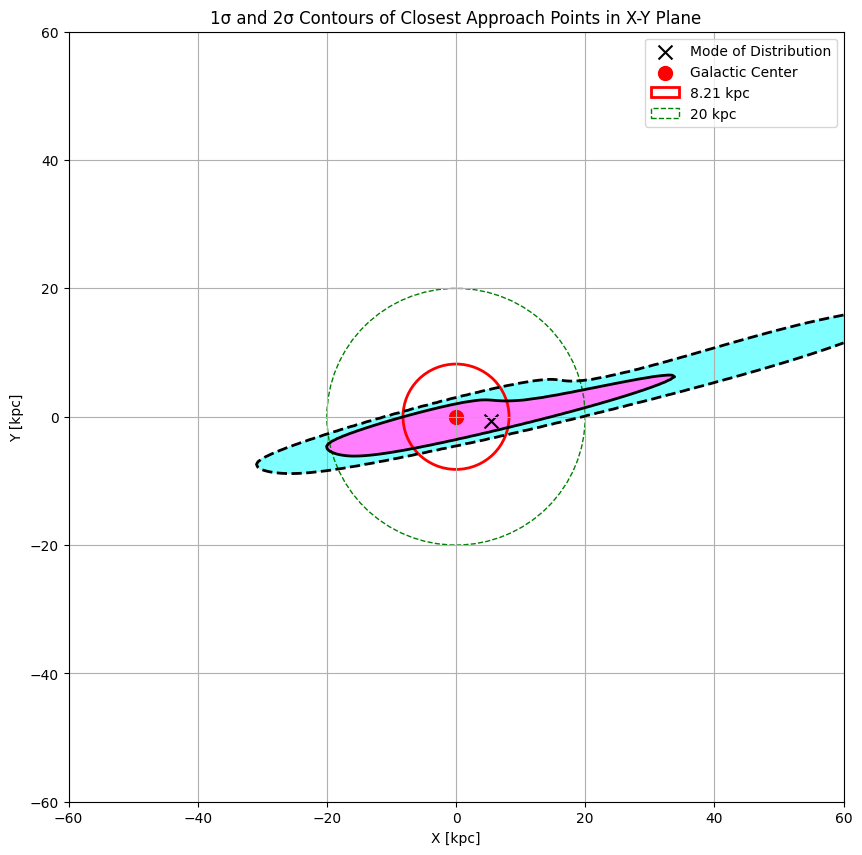

3496514390135141888
110    304.600006
Name: Vr_1, dtype: float32
True


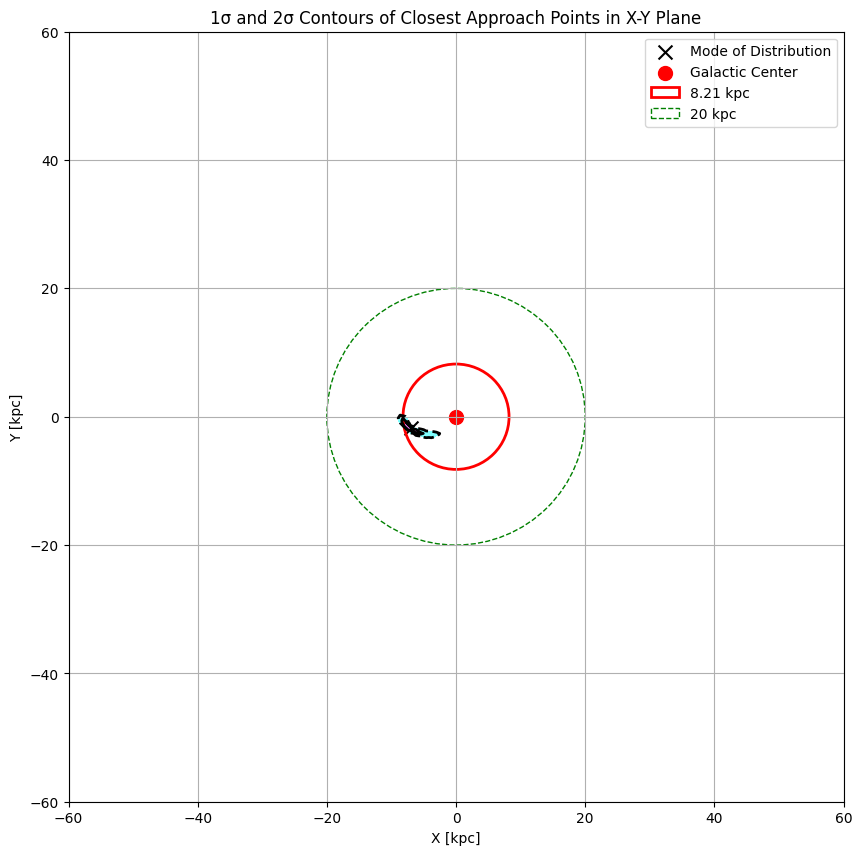

6673700744951769472
117    346.600006
Name: Vr_1, dtype: float32
True


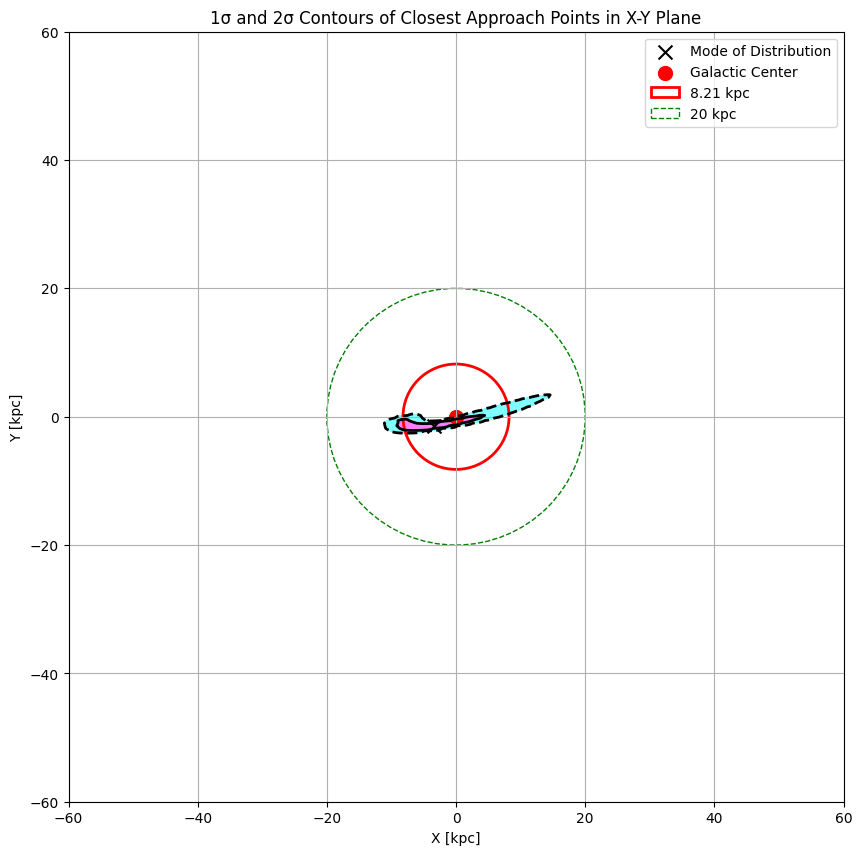

6513109241989477504
129    982.0
Name: Vr_1, dtype: float32
False


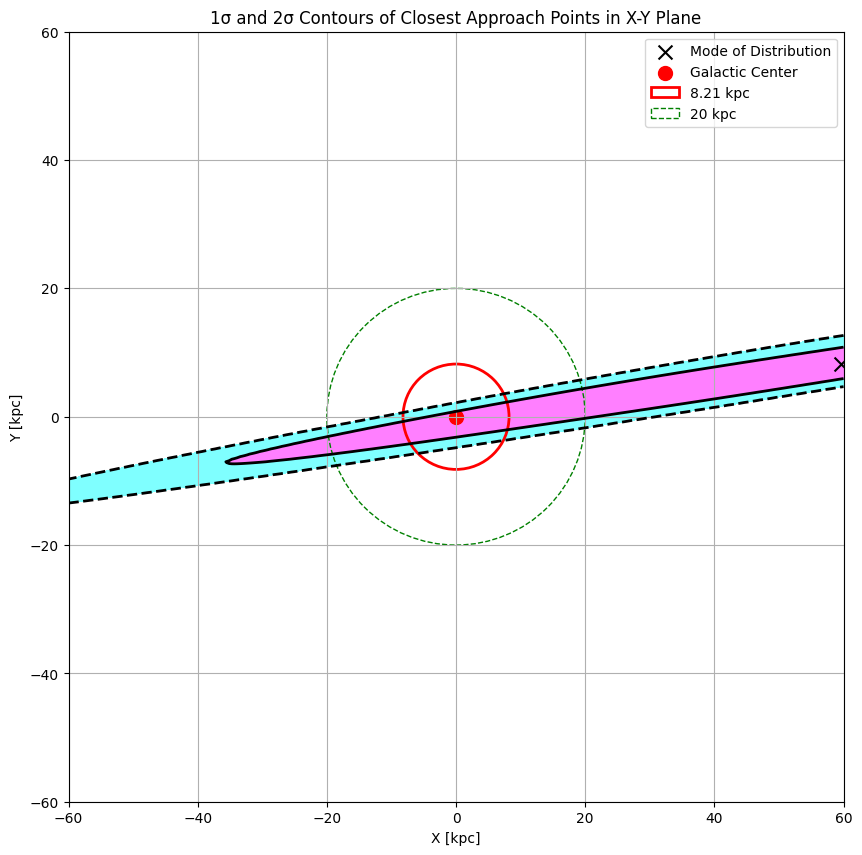

3508441896568320256
149    360.899994
Name: Vr_1, dtype: float32
True


KeyboardInterrupt: 

In [45]:
for i, plane_crossing in enumerate(plane_crossings):
    star = sill_stars.iloc[[i]]
    if star.Vr_1.values[0] > 300:
        print(star.source_id.values[0])
        print(star.Vr_1)
        positions, ts, trajectory, Rs, vels, bound, potential_energy, kinetic_energy, total_energy = orbits_sill_stars[i]
        print(bound)
        plot_sigma_contours(plane_crossing, star_name=star.source_id.values[0], save=True)
    #plot_sigma_contours(plane_crossing)

# Obit for the central values

In [21]:
def integrate_orbit(
    star, ra_col='ra', dec_col='dec', pmra_col='pmra',
    pmdec_col='pmdec', d_col='d_helio', v_col='v_helio', integration_time=-0.5,
    potential = None, potential_file = None
):
    """
    Integrate orbits of a star back in time using AGAMA and find the closest approach to X, Y, Z = 0.

    Parameters:
    - star: pandas.DataFrame
      Single-row DataFrame with columns ['RAx', 'DECx', 'pmra', 'pmdec', 'd_helio', 'v_helio'].
    - output_path: str
      Path to save orbit files (optional).
    - n_samples: int
      Number of Monte Carlo samples for error propagation.
    - integration_time: float
      Integration time into the past (negative for backward integration) in Myr.
    - n_steps: int
      Number of time steps for orbit integration.
      
    Returns:
    - closest_origins: list
      List of positions (X, Y, Z) at the closest approach for each sample.
    """


    #potential = agama.Potential(file='Agama/McMillan2011.pot')  # Adjust file path if needed
    # just in case
    agama.setUnits(mass=1, length=1, velocity=1)  # kpc, km/s, 1e10 M_sun
    
    # Define AGAMA potential (McMillan17 equivalent)
    if potential is None:
      potential_file = 'Agama/McMillan2011.pot'
      potential = agama.Potential(potential_file)

    from astropy import units as u

    ### galpy uses these units, so instruct agama to do the same
    #agama.setUnits( mass=1., length=1, velocity=1)  # Msun, kpc, km/s


    
    # Extract data and errors
    ra = star[ra_col].iloc[0]
    dec = star[dec_col].iloc[0]
    pmra = star[pmra_col].iloc[0]
    pmdec = star[pmdec_col].iloc[0]
    d_helio = star[d_col].iloc[0]
    v_helio = star[v_col].iloc[0]

    # Transform coordinates to Galactocentric frame
    c = SkyCoord(
        ra=ra * u.deg, dec=dec * u.deg, 
        distance=d_helio * u.kpc, pm_ra_cosdec=pmra * u.mas / u.yr, 
        pm_dec=pmdec * u.mas / u.yr, radial_velocity=v_helio * u.km / u.s
    )
    galactic = c.transform_to(Galactocentric())
    x, y, z = galactic.x.to_value(u.kpc), galactic.y.to_value(u.kpc), galactic.z.to_value(u.kpc)
    vx, vy, vz = galactic.v_x.to_value(u.km / u.s), galactic.v_y.to_value(u.km / u.s), galactic.v_z.to_value(u.km / u.s)

    # Prepare initial conditions for AGAMA
    ic = np.array([x, y, z, vx, vy, vz])  # Initial conditions
    
    # Integrate orbit
    orbit = agama.orbit(potential=potential, ic=ic, time=integration_time, dtype = object)#, trajsize=n_steps)

    # extract time steps and trajectory
    ts=np.array([t for t in orbit])
    trajectory=orbit(orbit)[:,:3]
    rs=np.linalg.norm(trajectory,axis=1)
    Rs=np.linalg.norm(trajectory[:,:2],axis=1)
    vels=orbit(orbit)[:,3:]


    # Split trajectory into positions and velocities
    x_vals, y_vals, z_vals = trajectory[:, 0], trajectory[:, 1], trajectory[:, 2]
    positions = [x_vals, y_vals, z_vals]


    return positions, ts, trajectory, Rs, vels

In [38]:
def integrate_orbit(
    star, ra_col='ra', dec_col='dec', pmra_col='pmra',
    pmdec_col='pmdec', d_col='d_helio', v_col='v_helio', integration_time=-0.5,
    potential=None, potential_file=None
):
    """
    Integrate orbits of a star back in time using AGAMA and determine if it is bound to the given potential.

    Parameters:
    - star: pandas.DataFrame
      Single-row DataFrame with columns ['RAx', 'DECx', 'pmra', 'pmdec', 'd_helio', 'v_helio'].
    - integration_time: float
      Integration time into the past (negative for backward integration) in Myr.
    - potential: agama.Potential
      AGAMA potential object.
    - potential_file: str
      Path to the potential file if `potential` is not provided.
      
    Returns:
    - positions: list
      Positions (X, Y, Z) at various time steps during the integration.
    - ts: array
      Time steps of the integration.
    - trajectory: array
      3D positions of the trajectory.
    - Rs: array
      Radial distances in the X-Y plane.
    - vels: array
      Velocities at each time step.
    - bound: bool
      Whether the star is bound to the potential.
    """

    # Set up the potential
    if potential is None:
        if potential_file is None:
            raise ValueError("Either a potential object or a potential_file must be provided.")
        potential = agama.Potential(potential_file)

    agama.setUnits(mass=1, length=1, velocity=1)  # kpc, km/s, 1e10 M_sun

    from astropy import units as u

    # Extract data
    ra = star[ra_col].iloc[0]
    dec = star[dec_col].iloc[0]
    pmra = star[pmra_col].iloc[0]
    pmdec = star[pmdec_col].iloc[0]
    d_helio = star[d_col].iloc[0]
    v_helio = star[v_col].iloc[0]

    # Transform coordinates to Galactocentric frame
    c = SkyCoord(
        ra=ra * u.deg, dec=dec * u.deg, 
        distance=d_helio * u.kpc, pm_ra_cosdec=pmra * u.mas / u.yr, 
        pm_dec=pmdec * u.mas / u.yr, radial_velocity=v_helio * u.km / u.s
    )
    galactic = c.transform_to(Galactocentric())
    x, y, z = galactic.x.to_value(u.kpc), galactic.y.to_value(u.kpc), galactic.z.to_value(u.kpc)
    vx, vy, vz = galactic.v_x.to_value(u.km / u.s), galactic.v_y.to_value(u.km / u.s), galactic.v_z.to_value(u.km / u.s)

    # Calculate the total energy (E_total = K + U) at the initial position
    kinetic_energy = 0.5 * (vx**2 + vy**2 + vz**2)  # Kinetic energy per unit mass
    potential_energy = potential.potential(np.array([x, y, z]))  # Potential energy per unit mass
    total_energy = kinetic_energy + potential_energy

    bound = total_energy < 0  # Star is bound if E_total < 0

    # Prepare initial conditions for AGAMA
    ic = np.array([x, y, z, vx, vy, vz])

    # Integrate orbit
    orbit = agama.orbit(potential=potential, ic=ic, time=integration_time, dtype=object)

    # Extract time steps and trajectory
    ts = np.array([t for t in orbit])
    trajectory = orbit(orbit)[:, :3]
    Rs = np.linalg.norm(trajectory[:, :2], axis=1)
    vels = orbit(orbit)[:, 3:]

    # Split trajectory into positions
    x_vals, y_vals, z_vals = trajectory[:, 0], trajectory[:, 1], trajectory[:, 2]
    positions = [x_vals, y_vals, z_vals]

    return positions, ts, trajectory, Rs, vels, bound, potential_energy, kinetic_energy, total_energy


In [53]:
orbits_sill_stars = []
for i in range(len(sill_stars)):
    star = sill_stars.iloc[[i]]
    if star.Vr_1.values[0] > 300:
        orbits_sill_stars.append(integrate_orbit(star,
                                                            integration_time=-0.3,  
                                                            pmra_col='pmra',
                                                            pmdec_col='pmdec',
                                                            v_col='Vr_1',
                                                            d_col='d_helio',
                                                            potential_file='Agama/brown2015.pot'))


Source 4933884436226779776 is not bound
Radial velocity: 139.89999389648438
The potential energy per unit mass is -163262.37449747688
The kinetic energy per unit mass is 182702.624207226
The total energy per unit mass is 19440.24970974913


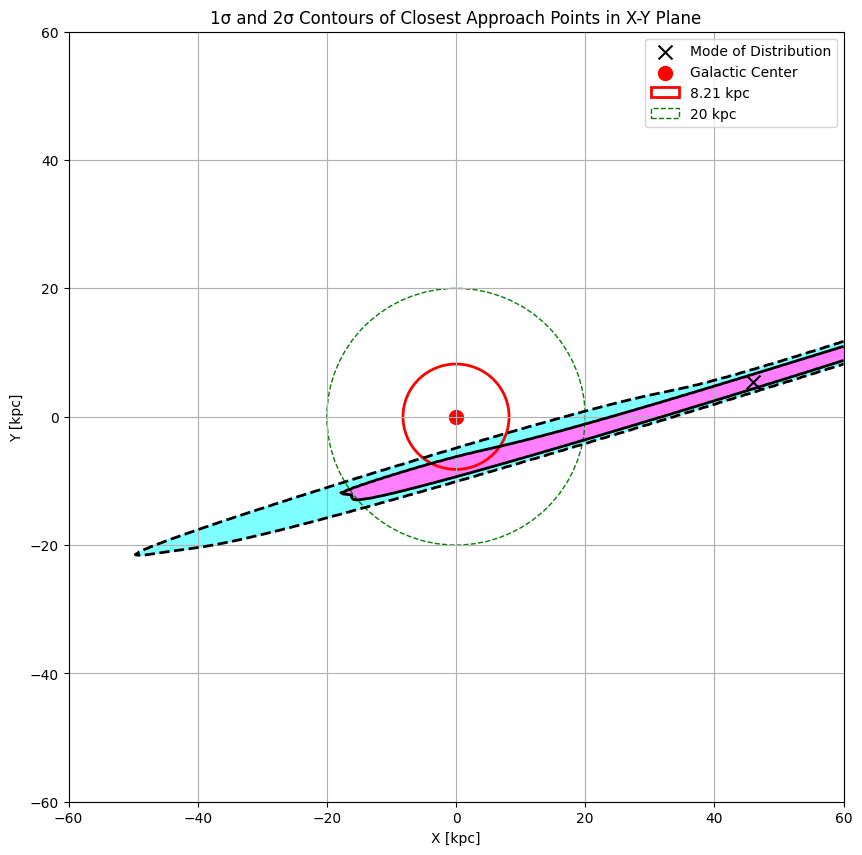

Source 4933884436226779776 is not bound
Radial velocity: 139.89999389648438
The potential energy per unit mass is -127481.98683921689
The kinetic energy per unit mass is 152370.8124337422
The total energy per unit mass is 24888.825594525304


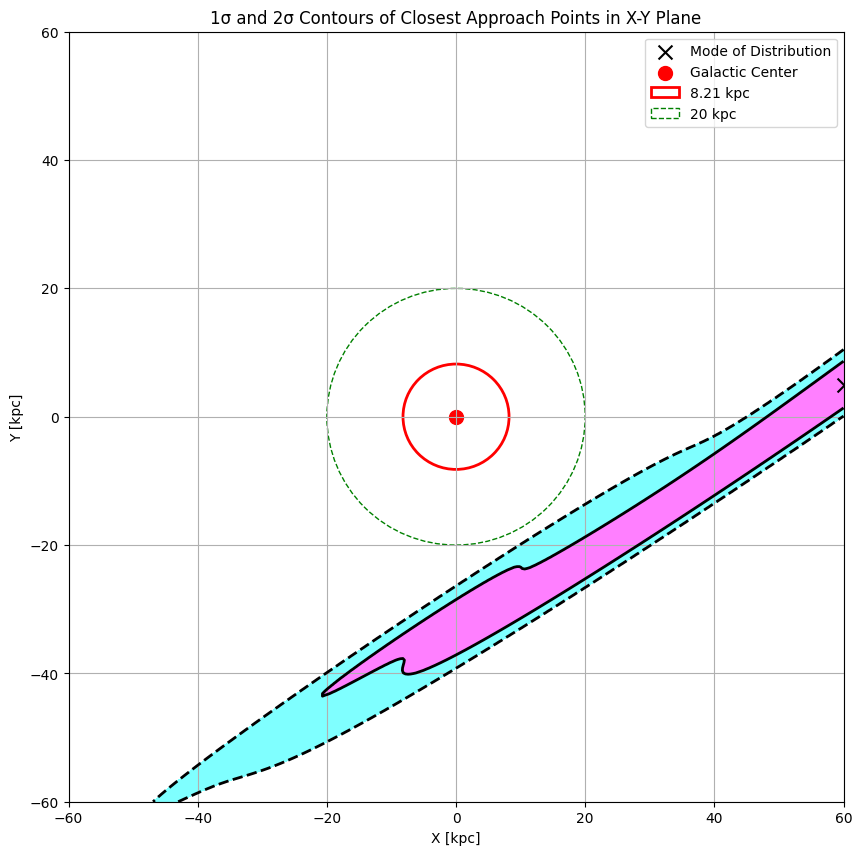

Source 4933884436226779776 is not bound
Radial velocity: 139.89999389648438
The potential energy per unit mass is -162851.65115845474
The kinetic energy per unit mass is 197305.93715268967
The total energy per unit mass is 34454.28599423493


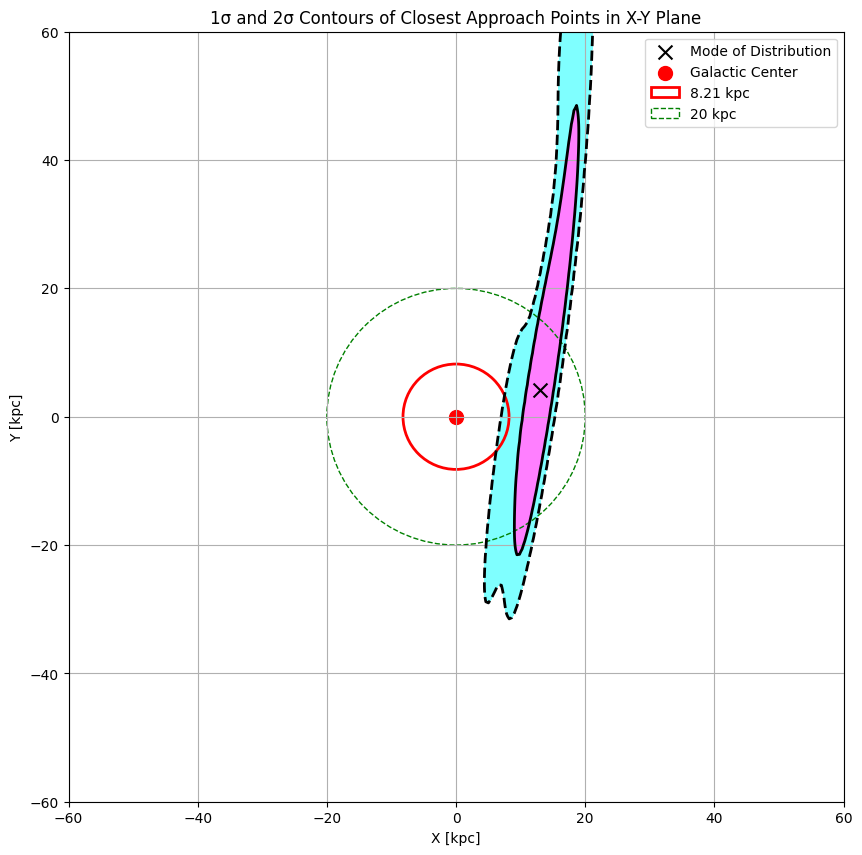

Source 4933884436226779776 is not bound
Radial velocity: 139.89999389648438
The potential energy per unit mass is -148533.1776922445
The kinetic energy per unit mass is 11520408.31556439
The total energy per unit mass is 11371875.137872146


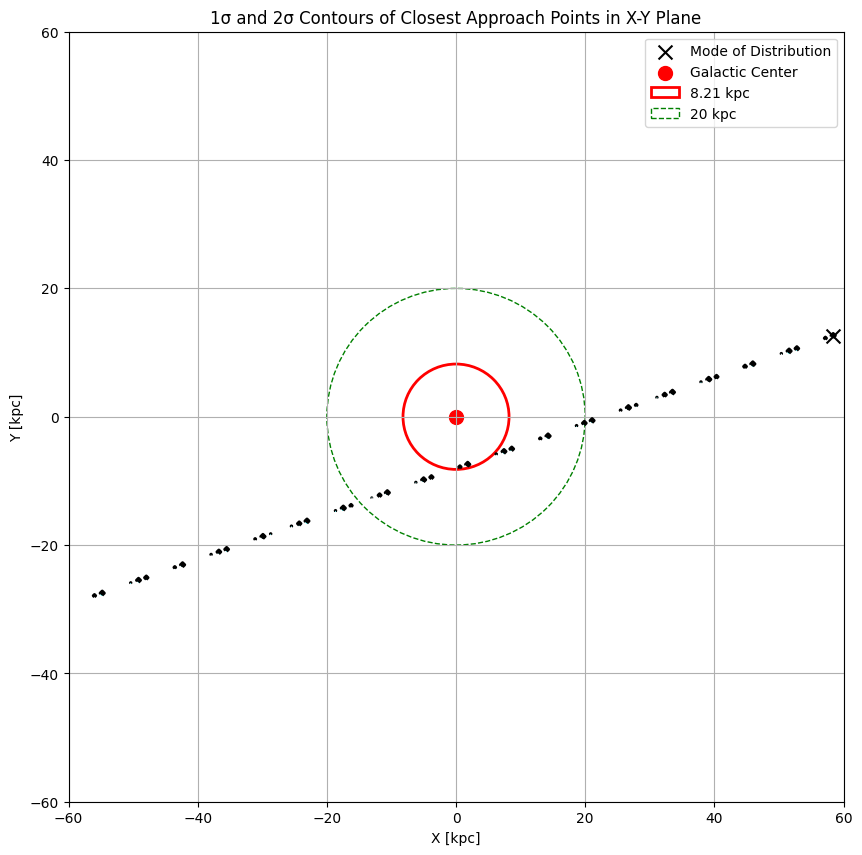

In [57]:
for orbit in orbits_sill_stars:
    positions, ts, trajectory, Rs, vels, bound, potential_energy, kinetic_energy, total_energy = orbit
    if bound == False:
        print(f'Source {star.source_id.values[0]} is not bound')
        print(f'Radial velocity: {star.Vr_1.values[0]}')

        print('The potential energy per unit mass is',potential_energy)
        print('The kinetic energy per unit mass is',kinetic_energy)
        print('The total energy per unit mass is', total_energy)
        plot_sigma_contours(trajectory, star_name=star.source_id.values[0], save=True)

35    317.5
Name: Vr_1, dtype: float32
Source 3517385736465747456 is bound
317.5


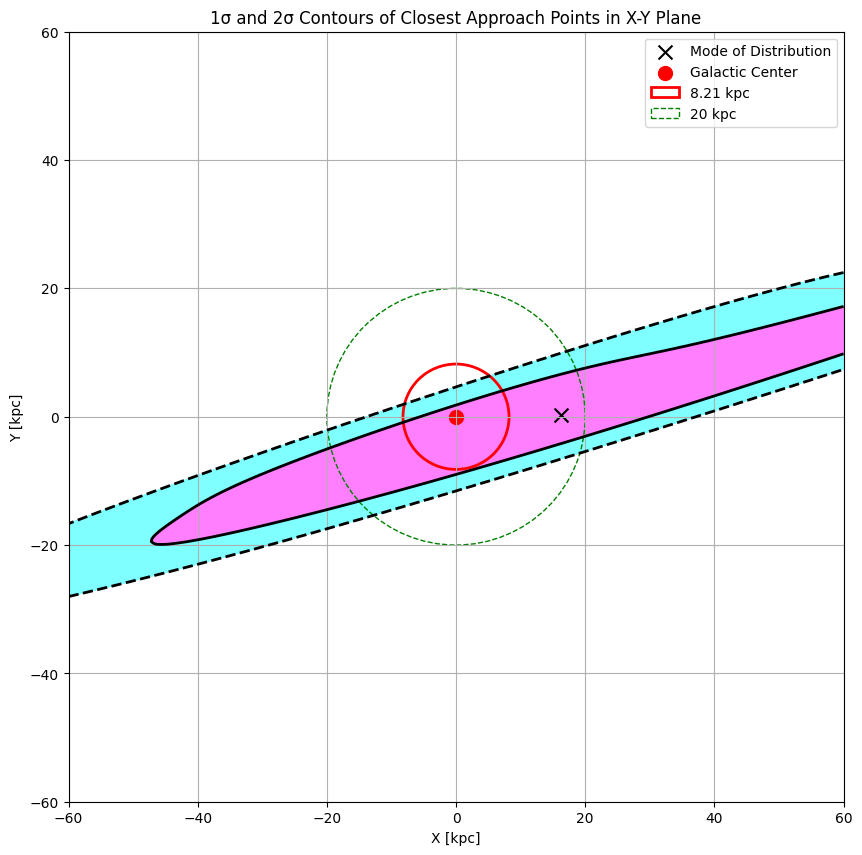

36    362.5
Name: Vr_1, dtype: float32
Source 4842148023592665600 is bound
The potential energy per unit mass is -163262.37449747688
The kinetic energy per unit mass is 182702.624207226
The total energy per unit mass is 19440.24970974913
362.5


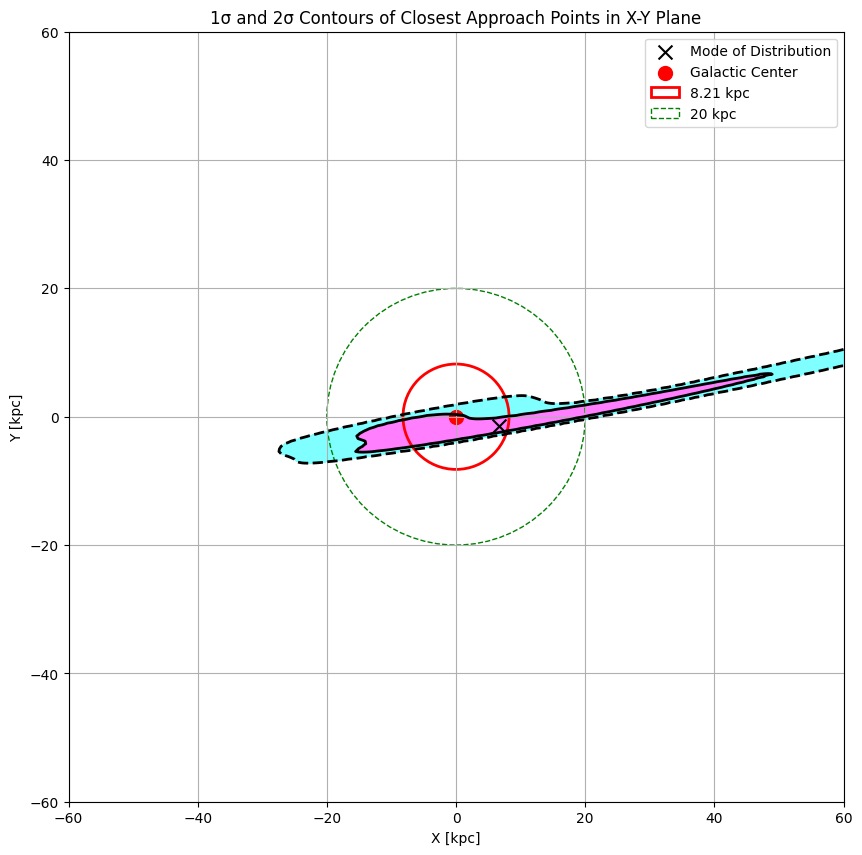

41    351.100006
Name: Vr_1, dtype: float32
Source 5280863024321039872 is bound
351.1


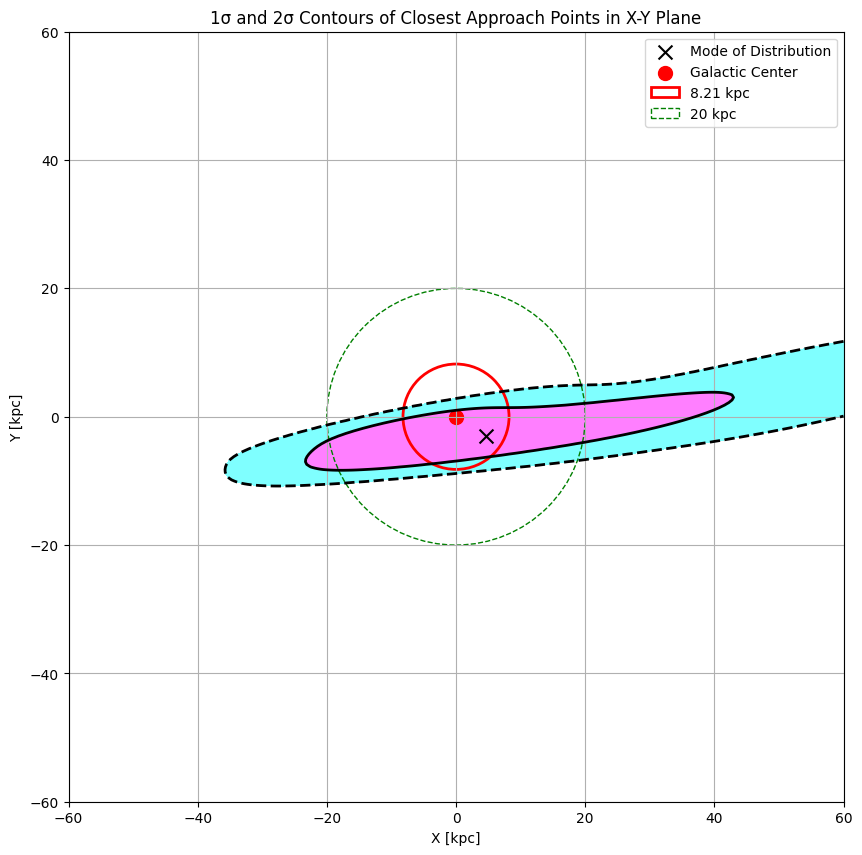

45    371.399994
Name: Vr_1, dtype: float32
Source 3509202552456394368 is bound
371.4


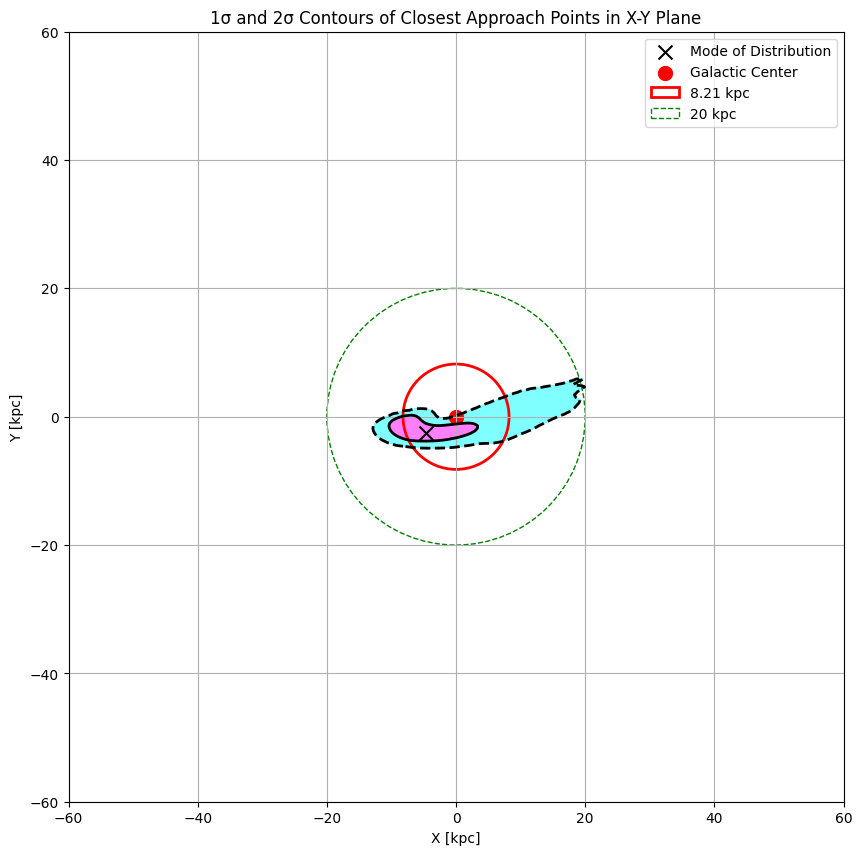

50    425.799988
Name: Vr_1, dtype: float32
Source 5486643046433857920 is bound
The potential energy per unit mass is -127481.98683921689
The kinetic energy per unit mass is 152370.8124337422
The total energy per unit mass is 24888.825594525304
425.8


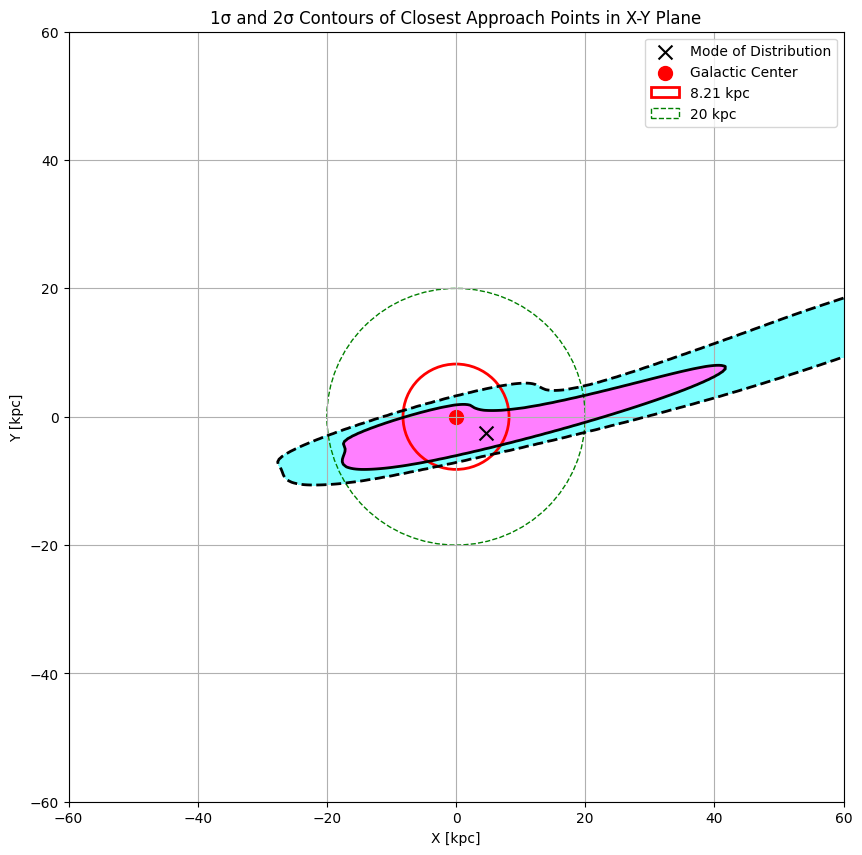

51    326.0
Name: Vr_1, dtype: float32
Source 3489258270522883968 is bound
326.0


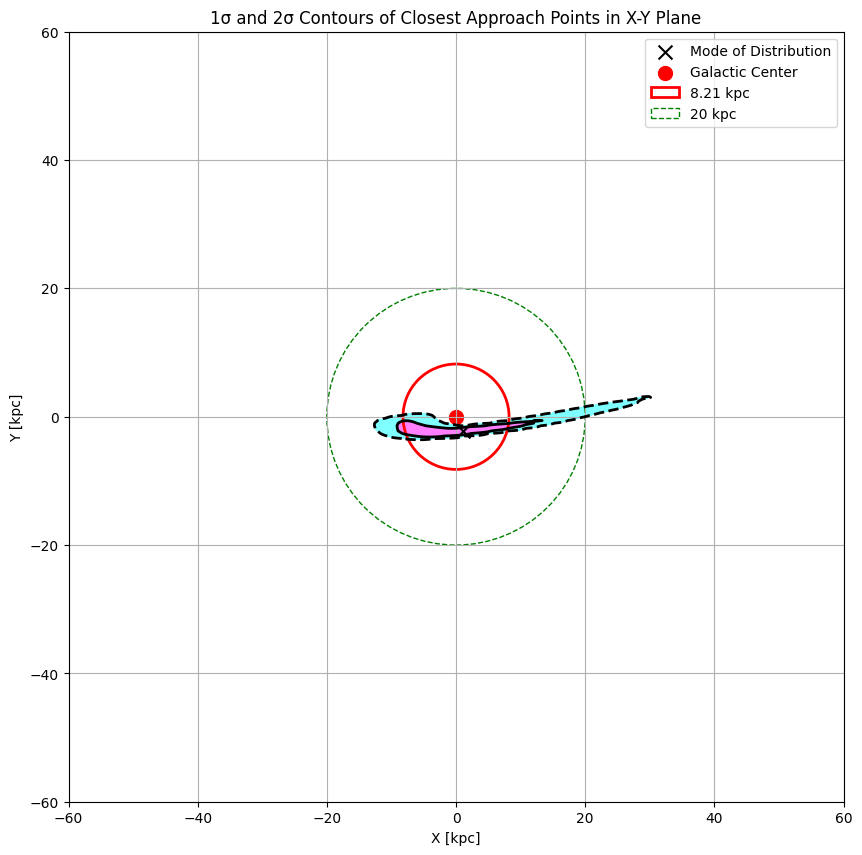

75    349.5
Name: Vr_1, dtype: float32
Source 6412888099986311424 is bound
349.5


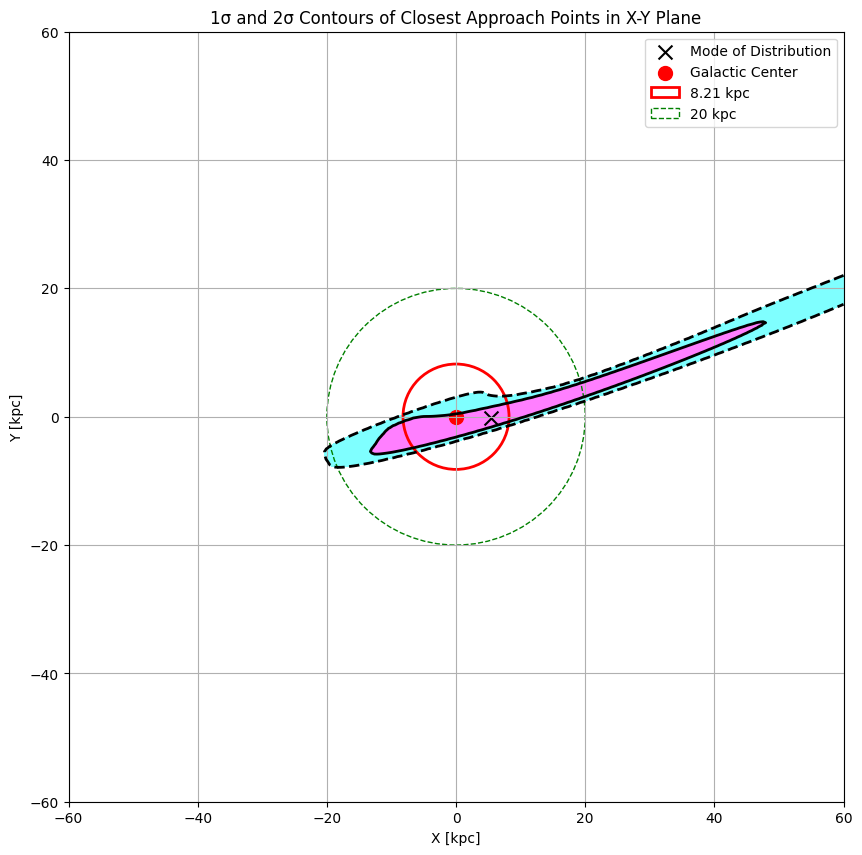

79    360.700012
Name: Vr_1, dtype: float32
Source 6409893923665251200 is bound
360.7


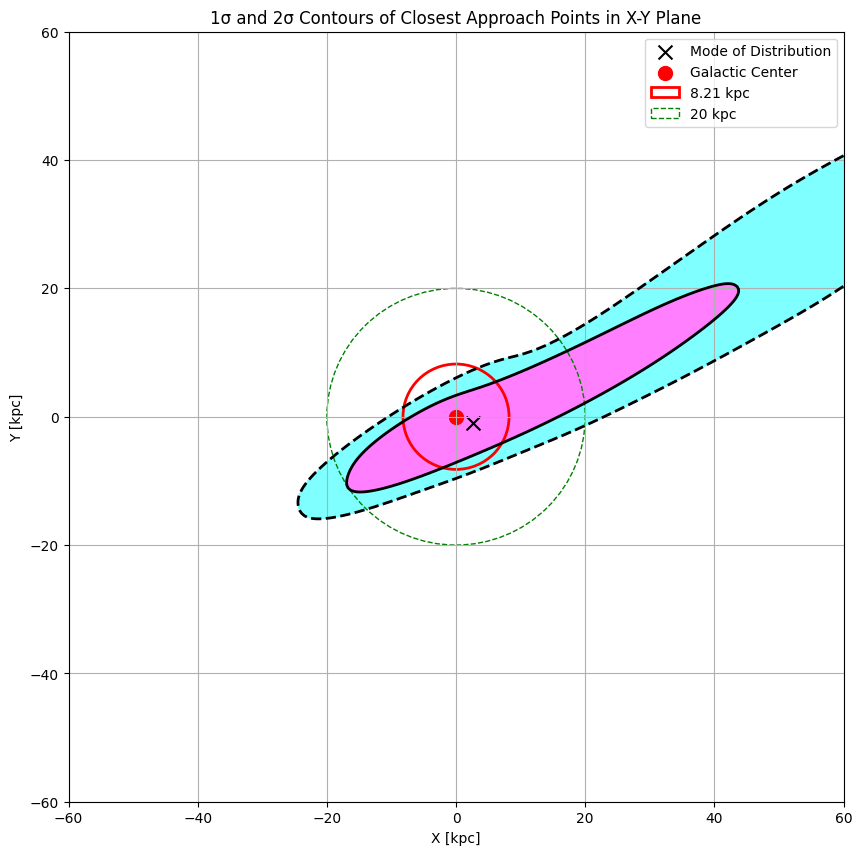

89    406.299988
Name: Vr_1, dtype: float32
Source 6402416115022000384 is bound
The potential energy per unit mass is -162851.65115845474
The kinetic energy per unit mass is 197305.93715268967
The total energy per unit mass is 34454.28599423493
406.3


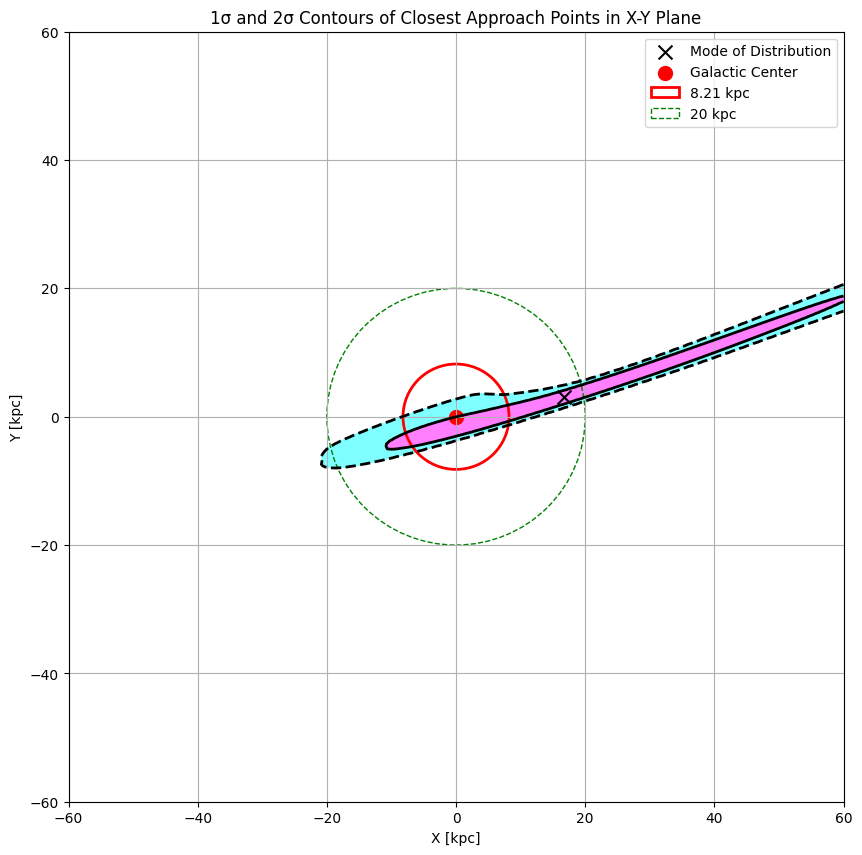

103    510.0
Name: Vr_1, dtype: float32
Source 5477480717256679680 is bound
510.0


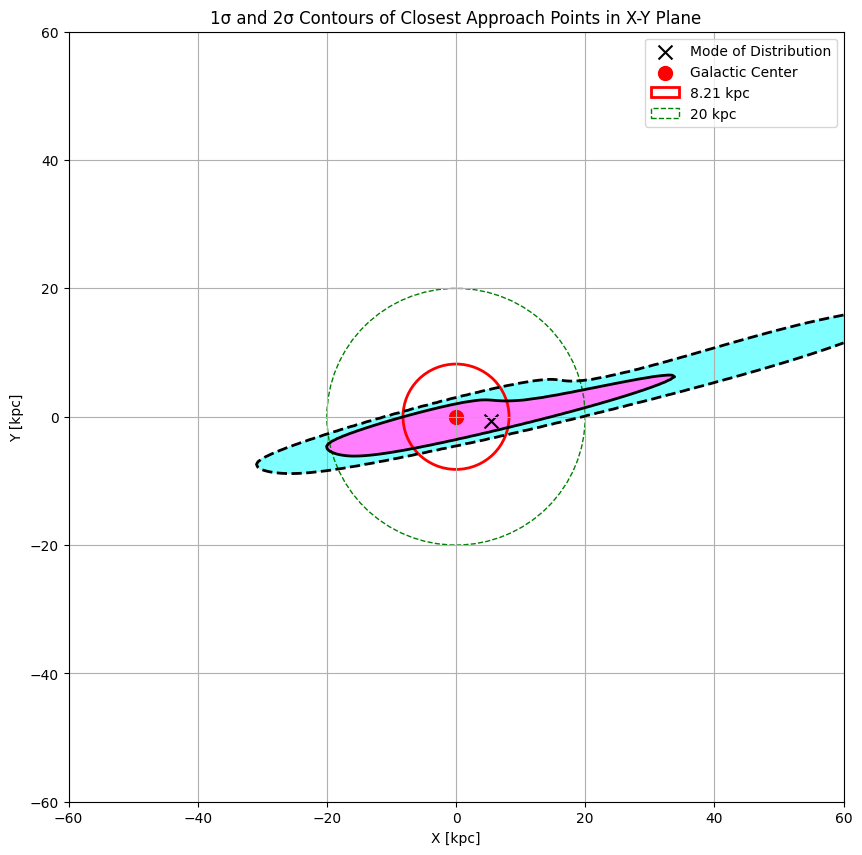

110    304.600006
Name: Vr_1, dtype: float32
Source 3496514390135141888 is bound
304.6


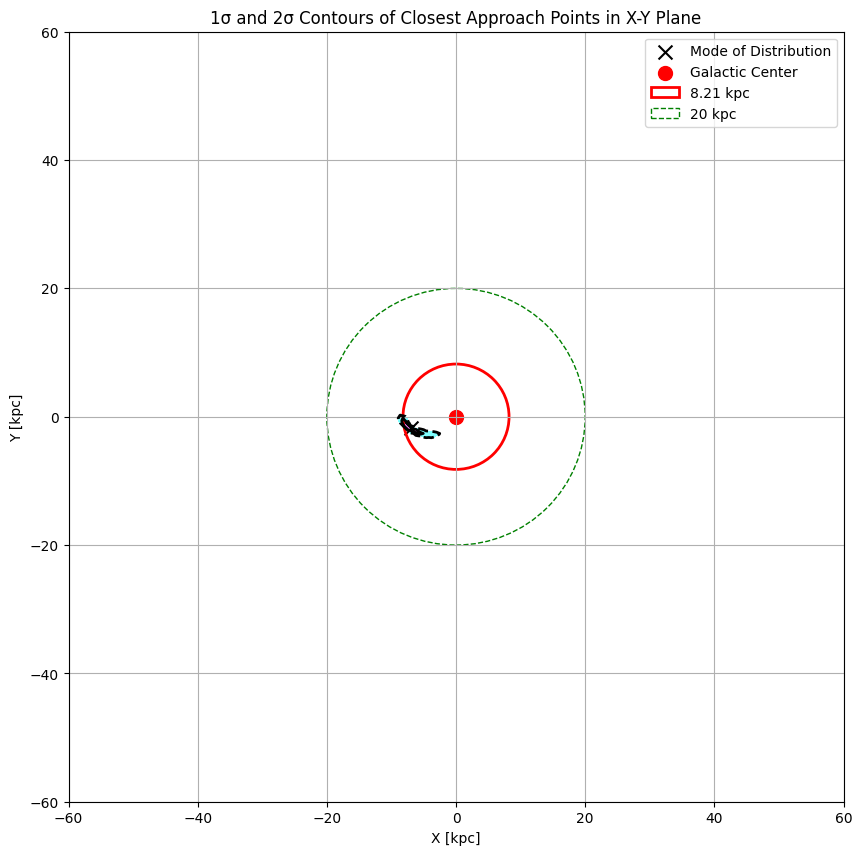

117    346.600006
Name: Vr_1, dtype: float32
Source 6673700744951769472 is bound
346.6


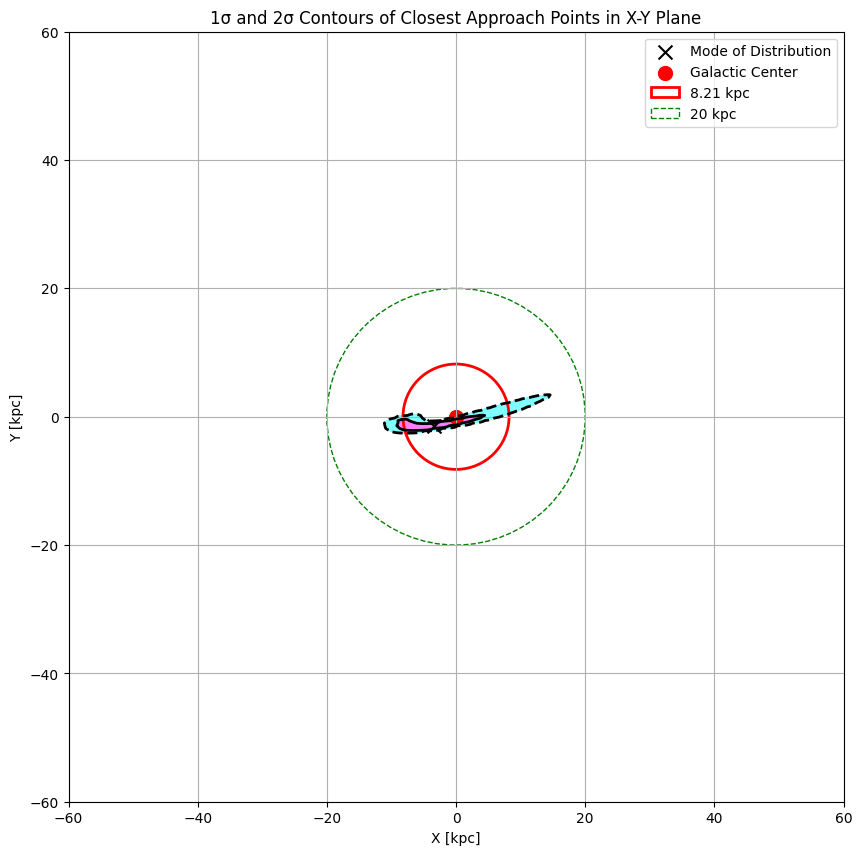

129    982.0
Name: Vr_1, dtype: float32
Source 6513109241989477504 is bound
The potential energy per unit mass is -148533.1776922445
The kinetic energy per unit mass is 11520408.31556439
The total energy per unit mass is 11371875.137872146
982.0


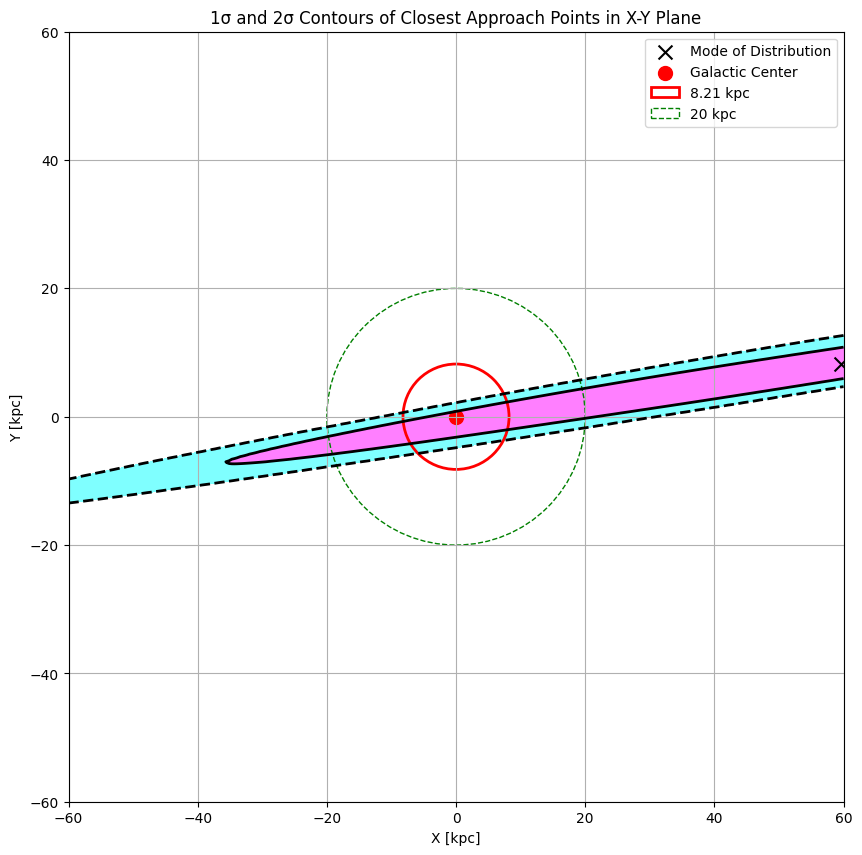

149    360.899994
Name: Vr_1, dtype: float32
Source 3508441896568320256 is bound
360.9


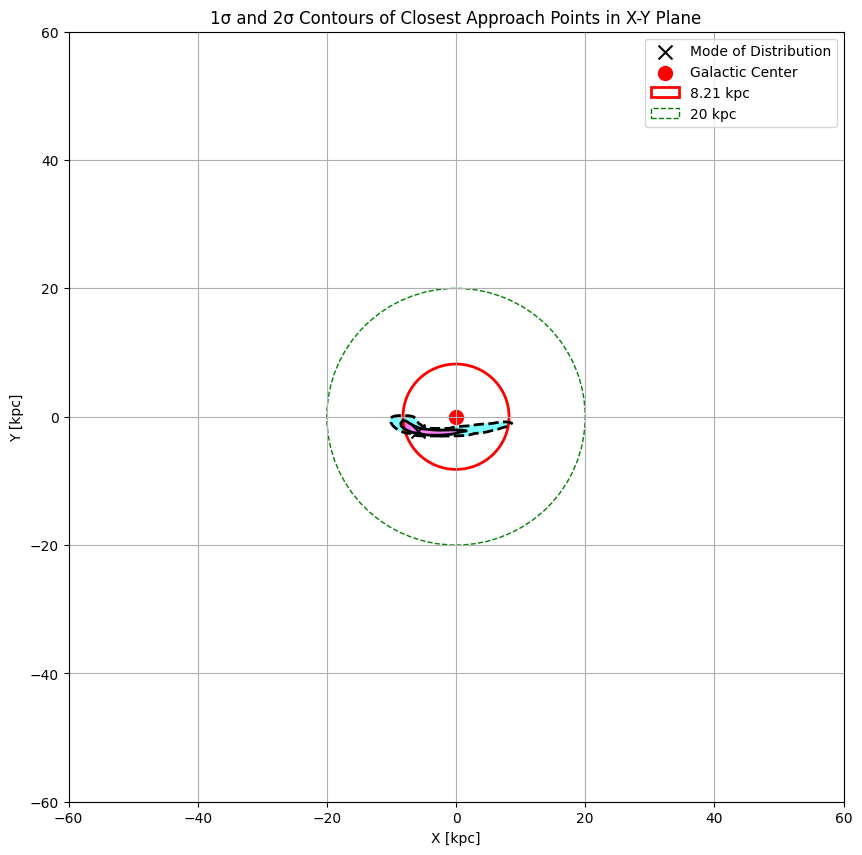

In [62]:
for i, plane_crossing in enumerate(plane_crossings):
    star = sill_stars.iloc[[i]]
    if star.Vr_1.values[0] > 300:
        #print(star.source_id.values[0])
        print(star.Vr_1)
        positions, ts, trajectory, Rs, vels, bound, potential_energy, kinetic_energy, total_energy = integrate_orbit(star,
                                                            integration_time=-0.3,  
                                                            pmra_col='pmra',
                                                            pmdec_col='pmdec',
                                                            v_col='Vr_1',
                                                            d_col='d_helio',
                                                            potential_file='Agama/brown2015.pot')
        if not bound:
            print(f'Source {star.source_id.values[0]} is bound')
            print('The potential energy per unit mass is',potential_energy)
            print('The kinetic energy per unit mass is',kinetic_energy)
            print('The total energy per unit mass is', total_energy)
        else:
            print(f'Source {star.source_id.values[0]} is bound')
        print(star.Vr_1.values[0])
        plot_sigma_contours(plane_crossing, star_name=star.source_id.values[0], save=True)
    #plot_sigma_contours(plane_crossing)

In [50]:
total_energy

np.float64(-174743.99918697734)

In [ ]:
# make a 3d plot showing the orbit of the central values with the inital and final position, along with the plane crossings for that object